# Projeto 3 - MC886

## Alunos: 
&emsp;&emsp;&emsp;&emsp;Felipe Escórcio de Sousa - RA:171043\
&emsp;&emsp;&emsp;&emsp;Miguel Augusto S Guida&nbsp;&nbsp;&nbsp;- RA:174847

## Objetivo
&emsp;Este projeto tem como objetivo aplicar os conceitos de Algoritmos Evolutivos e Métodos de Aprendizagem por Reforço para treinar um modelo capaz de jogar Pac-Man. O trabalho foi então dividido em duas partes:

<li>
    <ul>Parte 1: Modelo Evolutivo</ul>
    <ul>Parte 2: Modelo de Aprendizagem por Reforço</ul>
</li>

## Jogo do Pacman
&emsp;PACMAN MELHOR JOGO PQP 
&emsp;&emsp;Falar de estado e acao. Nao deixamos a acao STOP como uma opcao disponivel. Como funciona o jogo, quais variaveis de estado utilizamos. 

## Parte 1 - Modelo Evolutivo
Essa etapa tem o objetivo de utilizar algoritmos evolutivos para criar um agente que consiga jogar e vencer uma partida de pacman.

Nossa ideia inicial de algoritmo evolutivo foi gerar uma sequência de ações para o pacman seguir e percorrer o labirinto proposto, gerando um vetor que guardaria a sequência de ações que deveria ser tomada pelo indivíduo, porém, esta ideia não se provou muito apropriada, pois a natureza dos outros agentes (fantasmas) é não determinística, inviabilizando a ideia inicial.

Assim, nos inspiramos no paper de Brandstetter e Ahmadi para implementar um algoritmo genético baseado em árvores genéticas, possibilitando ao agente tomar decisões baseado nos estados do jogo e não mais apenas no percurso. 

Também utilizamos do paper o princípio de tomar ações simples e direcionais apenas, não dependendo de definir estratégias mais complexas e subjetivas ao jogo, como também da adoção de constantes para os cálculos. No entanto, adotamos menos variáveis dos estados para definir a movimentação do pacman, simplificando ou ignorando algumas adotadas pelos autores.


In [1]:
from search import *
from game import *
from util import *
from pacman import *
import util, layout
import sys, types, time, random, os
import numpy as np
import math
import matplotlib.pyplot as plt
from random import random, randint, seed, choice
import matplotlib.pyplot as plt
import graphicsDisplay

## Biblioteca
Para a implementação do algoritmo evolutivo utilizamos uma estrutura de árvores genéticas a partir do algoritmo encontrado em [Tiny_GP](https://github.com/moshesipper/tiny_gp), com algumas pequenas alterações, além de também usar de referência o artigo Reactive Control of Ms. Pac Man using Information Retrieval based on Genetic Programming de Brandstetter e Ahmadi.

Mantemos da biblioteca a classe GPTree, com seus métodos básicos, fazendo alterações na mutação e na computação dos nós da árvore a partir dos terminais (bottom-up), e semelhantemente ao artigo, buscamos calcular atomicamente as próximas ações a partir dos estados atuais.

Essa biblioteca nos chamou a atenção pela implementação do método random_tree, pois este método gera árvores genéticas aleatoriamente atribuindo as funções aos nós intermediários e os terminais aos nós folhas ( muito útil na inicialização e mutação dos indivíduos). Além desse método, o método scan_tree também nos pareceu muito interessante, pois este é muito útil para o crossover (seleção e troca dos genes).

### Funções
As funções são as operações executadas nos nós da árvore (add, sub e mul).

### Terminais
Os terminais são os tipos possíveis de nós folha, determinados pelas variáveis de estado e por constantes para possibilitar a associação de pesos às variáveis de estado.

Decidimos calcular terminais a partir, basicamente, da posição atual do pacman, posição e score futuros do pacman, distância aos fantasmas (comestível ou não), às pílulas e à comida, além de se haverá encontro com alguma comida ou ao fantasma.

In [2]:
# tiny genetic programming by © moshe sipper, www.moshesipper.com
MIN_DEPTH       = 2    # minimal initial random tree depth
MAX_DEPTH       = 5    # maximal initial random tree depth

def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y

FUNCTIONS = [add, sub, mul]
TERMINALS = ['actionScore', 
             'eatFood', 
             'minGhostDist', 
             'minDistToFood', 
             'distToPill', 
             'minDistEdibleGhost', 
             'encounterGhost',
             -1.0, 0.5, 1.0, 2.0] # 0.0,  -0.5,

STATE_VARS = ['actionScore', 
              'eatFood', 
              'minGhostDist', 
              'minDistToFood', 
              'distToPill', 
              'minDistEdibleGhost', 
              'encounterGhost']

class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def setLeft(self, tree):
        self.left = tree
        
    def setRight(self, tree):
        self.right = tree
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def computeTree(self, stateVars): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.computeTree(stateVars), self.right.computeTree(stateVars))
        elif (self.data in STATE_VARS): 
            return stateVars[self.data]
        else: return self.data
        
    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r
    
    def random_tree(self, grow, max_depth=MAX_DEPTH, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)
            
    def getSubtree(self):
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.getSubtree()
        if self.right: t.right = self.right.getSubtree()
        return t
    
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.getSubtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)
            return ret
        
    def mutation(self, probability=0.1):
        if random() < probability: # mutate at this node
            self.random_tree(grow = True, max_depth= 3)
        else:
            if random() < 0.5:
                if self.left: self.left.mutation(probability)
                elif self.right: self.right.mutation(probability)
            else:
                if self.right: self.right.mutation(probability)
                elif self.left: self.left.mutation(probability)
        

## O Agente
Nosso agente, para cada movimento possível, calcula os score relacionados à escolha de cada e a partir disso retorna a função de maior score possível ou escolhe aleatoriamente dentre as que tiverem maior score empatadas a fim de evitar comportamentos excessivamente repetitivos do agente dado algum estado. 

Para o cálculo de cada ação, buscamos levar em conta o estado atual (distâncias e recursos disponíveis) do pacman, do mapa e dos fantasmas, como também o estado futuro destes se escolhida tal ação. De posse destas variáveis, então realizamos o cálculo segundo a equação dada pela árvore que representa os genes do indivíduo.

Em princípio, usamos um cálculo de distâncias bem mais simples (distância manhattan) que até então parecia suficiente, porém, para atingir resultados melhores, foi necessário utilizar de uma forma mais precisa de cálculo, daí então escolhemos utilizar o algoritmo de busca em profundidade.

Também, percebemos conforme a implementação que algumas variáveis que indicassem que o pacman comeria alguma comida ou encontrasse um fantasma com a ação também ajudavam com a performance, aumentando os scores ou a evasão, por exemplo.

In [3]:
" AGENTE & FUNÇÕES AUXILIARES "
n = Directions.NORTH
s = Directions.SOUTH
e = Directions.EAST
w = Directions.WEST

def minDistBFS(agentPos, positions, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):
                        return h
                
    return 0

def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True

    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):
                    return h
                
    return 0

def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())

def normalizeDistance(x):
    if x == 0:
        return 0
    return 1/(x**2)


class MyGoWestAgent(Agent):
    "An agent that goes West until it can't."
    def __init__(self, tree = None):
        self.tree = tree
        
    def setTree(self, tree):
        selt.tree = tree

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."
        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        stateVars = {}
        for action in legalActions:
            
            futureState = state.generatePacmanSuccessor(action)
            
            future_pos = futureState.getPacmanPosition()
            
            futureScore = futureState.getScore() - state.getScore()
            eatFood = state.getNumFood() - futureState.getNumFood()
            
            ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
            foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
            pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
            edibleGhost = getMinDistEdibleGhost(future_pos,futureState)
            if ghostDist == 1 and ghostDist != edibleGhost:
                encounterGhost = 1
                futureScore -= 200
            else:
                encounterGhost = 0
                
            
            stateVars[STATE_VARS[0]] = futureScore/200
            stateVars[STATE_VARS[1]] = eatFood
            stateVars[STATE_VARS[2]] = -normalizeDistance(ghostDist)
            stateVars[STATE_VARS[3]] = normalizeDistance(foodDist)
            stateVars[STATE_VARS[4]] = normalizeDistance(pillDist)
            stateVars[STATE_VARS[5]] = normalizeDistance(edibleGhost)
            stateVars[STATE_VARS[6]] = encounterGhost

            treeValue = self.tree.computeTree(stateVars)
            actionScore.append(treeValue)
        
        maxScore = max(actionScore)
        if actionScore.count(maxScore) > 1:
            indexes = [i for i, j in enumerate(actionScore) if j == maxScore]
            maxIndex = choice(indexes)
        else:
            maxIndex = actionScore.index(maxScore)
        
        action = legalActions[maxIndex]
        if action in state.getLegalPacmanActions():
            return action
        else:
            return Directions.STOP

### População Inicial
Iniciamos uma primeira geração com um número N de indivíduos gerados aleatóriamente com uma altura máxima inicial pré estabelecida de 4. Escolhemos esta quantidade inicial de indivíduos pois nos pareceu uma quantidade razoável dada nossa capacidade computacional e tempo disponíveis para a realização dos treinos, garantindo certa variabilidade aos indivíduos, assim como também a altura da árvore, que nos garante variabilidade e também complexidade comportamental a estes.  

In [4]:
def initialPopulation(populationSize=32,treeDepth=3):
    population = []
    for _ in range(populationSize):
        tree = GPTree()
        tree.random_tree(True, treeDepth)
        population.append(tree)
    return population

### Técnica de seleção
Como técnica de seleção para o pais dos indivíduos da próxima geração utilizamos a técnica de torneio. implementamos o torneio selecionando um número aleatório de indivíduos determinado por um parametro, e escolhemos o indíviduo com o maior fitness (score final). 

In [5]:
def tournament(population, fitness, size):
    indexes = np.random.choice(range(0,len(population)),size,False)
    chosen = [fitness[i] for i in indexes]
    return population[indexes[chosen.index(max(chosen))]]

def getParent(population, fitness,size=4):
    return tournament(population, fitness, size)

### Crossover
Para função de crossover da população, selecionamos dois indivíduos por meio do torneio e a partir destes criamos dois novos filhos, repetindo isso até que tenhamos completado o número de indivíduos menos dois da próxima geração. 
O crossover propriamente dito se dá pela função scan_tree, que percorre cada uma das árvores buscando por algum nó aleatório e então os troca, gerando os novos filhos a partir dessa combinação.

In [6]:
def crossover(treeA, treeB):
    child1 = treeA.getSubtree()
    child2 = treeB.getSubtree()
    
    geneA = child1.scan_tree([randint(1, treeA.size())], None) # 1st random subtree
    geneB = child2.scan_tree([randint(1, treeB.size())], None) # 2nd random subtree
    child1.scan_tree([randint(1, treeA.size())], geneB) # 2nd subtree "glued" inside 1st tree
    child2.scan_tree([randint(1, treeB.size())], geneA) # 1st subtree "glued" inside 2nd tree
    
    return child1, child2

### Treino
O treino é realizado por meio de 5 jogos por padrão, salvando sempre ao final a taxa de vitórias do indivíduo, retornando ao final o score médio das partidas.

In [7]:
winsDict = {}
def trainIndividual(ind, gen, layoutType='smallClassic', numGames=5):
    if gen < GEN_TRAIN_OFFSET:
        numGames = 2
    else:
        numGames=NUM_GAMES
    
        
    gameLayout = layout.getLayout( layoutType )
    print("------------------------------------------ train ---------------------------------------------")
    ind.print_tree()

    pacman = MyGoWestAgent(ind)

    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

    import textDisplay
    textDisplay.SLEEP_TIME = 0.1
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
    scores = [game.state.getScore() for game in games]
    wins = [game.state.isWin() for game in games]
    winRate = wins.count(True)/ float(len(wins))
    
    winsDict[str(gen)].append(winRate)
    
    avgScore = sum(scores) / float(len(scores))
    return avgScore

### Fitness Function
Para calcularmos a função de fitness para cada indivíduo utilizamos prontamente o valor de média dos scores finais de cada partida realizada por esse ao final da quantidade de partidas estipuladas.


In [8]:
def getFitness(individuo, gen, gameLayout= 'smallClassic'):
    return trainIndividual(individuo, gen, gameLayout)

def getPopFitness(population, gen, gameLayout= 'smallClassic'):
    return [getFitness(population[i], gen, gameLayout) for i in range(0,len(population))]

## Nova População
A nova população será composta pelos filhos gerados através do crossover e os dois indivídos com maior fitness da população anterior (elitismo).

### Mutação
O processo de mutação se dá pela escolha de um número determinado por um parâmetro dentre os indivíduos da próxima população, que poderão ter algum de seus nós aleatoriamente substituídos por uma nova sub-árvore a depender de uma taxa de mutação pré estipulada, alterando ou gerando novos genes nos indivíduos.

In [9]:
pops = []
def generationLoop(gameLayout = 'smallClassic', population=None):
    if population == None:
        population = initialPopulation(POP_SIZE, TREE_SIZE) # popSize, tam GPTree
    
    genFits = []
    maxFits = []
    minFits = []
    
    count = 1
    
    winsDict[str(count)] = []
    
    for p in population:
        p.print_tree()
        print(" - - - - ")
    print("G - ",count,"    ============================================  ")
    
    # train population to get fitness
    fitness = getPopFitness(population, count, gameLayout)
    print("G",count," - FITNESS: ", fitness )
    pops.append(population)
    while count <= NUM_GEN:
        children = []
        
        # crossover
        for i in range(0,int(len(population)/2)-1):
            father = getParent(population, fitness,4)
            mother = getParent(population, fitness,4)
            
            child1, child2 = crossover(father, mother)
            children.append(child1)
            children.append(child2)
        
        # mutation
        indexes = np.random.choice(range(0,len(children)),int(len(children)*0.6),False)
        for i in indexes:
            children[i].mutation(0.1)
        
        # elitism
        maxIndex = fitness.index(max(fitness))
        children.append(population[maxIndex])
        
        fitness.remove(max(fitness))
        population.remove(population[maxIndex])
        
        maxIndex = fitness.index(max(fitness))
        children.append(population[maxIndex])
        
        count += 1
        
        winsDict[str(count)] = []
        
        # train population to get fitness
        print("G", count," - POPULATION")
        
        population = children[:]
        for p in population:
            p.print_tree()
            print(" - - - - ")
            
        fitness = getPopFitness(population, count, gameLayout)
        pops.append(population)
       
        print("FITNESS: ", fitness )
        avgFit = sum(fitness) / float(len(fitness))
        print("Avg: ", avgFit)
        genFits.append(avgFit)
        maxFit = max(fitness)
        print("Max: ", maxFit)
        maxFits.append(maxFit)
        minFit = min(fitness)
        print("Min: ", minFit)
        minFits.append(minFit)
    
    print("gen means: ", genFits)
    print("gen maxes: ", maxFits)
    print("gen mins: ", minFits)
    
    x = np.linspace(1, NUM_GEN, num= NUM_GEN, endpoint=True)
    y1 = np.array(genFits)
    y2 = np.array(maxFits)
    y3 = np.array(minFits)
    
    plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
    plt.legend(['mean', 'max', 'min'], loc='best')
    plt.show()
    
    return population, offset, x, y1, y2, y3

### Treinamentos

In [ ]:
NUM_GEN = 12
POP_SIZE = 16
TREE_SIZE = 5
GEN_TRAIN_OFFSET=5
NUM_GAMES = 3
population, fitness, x, y1, y2, y3 = generationLoop('smallClassic')
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

sub
   sub
      add
         add
            actionScore
            mul
               minDistToFood
               0.5
         mul
            encounterGhost
            sub
               1.0
               eatFood
      mul
         sub
            actionScore
            add
               0.5
               -1.0
         0.5
   sub
      0.5
      add
         add
            add
               distToPill
               distToPill
            add
               minDistToFood
               2.0
         mul
            sub
               0.5
               distToPill
            add
               -1.0
               -1.0
 - - - - 
add
   sub
      mul
         encounterGhost
         eatFood
      add
         sub
            mul
               encounterGhost
               minDistToFood
            encounterGhost
         eatFood
   add
      2.0
      -1.0
 - - - - 
sub
   mul
      sub
         1.0
         sub
            mul
               minDistToFood
               minG

Pacman died! Score: -501
Pacman died! Score: -497
Average Score: -499.0
Scores:        -501.0, -497.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
add
   mul
      encounterGhost
      mul
         sub
            1.0
            minDistEdibleGhost
         0.5
   mul
      1.0
      add
         0.5
         mul
            minDistToFood
            add
               minDistEdibleGhost
               minDistToFood
Pacman died! Score: -333
Pacman died! Score: -206
Average Score: -269.5
Scores:        -333.0, -206.0
Win Rate:      0/2 (0.00)
Record:        Loss, Loss
layout:  smallClassic
------------------------------------------ train ---------------------------------------------
mul
   add
      mul
         sub
            2.0
            eatFood
         0.5
      encounterGhost
   add
      -1.0
      eatFood
Pacman died! Score: -437
Pacman died! Score: -428

In [ ]:
plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
plt.legend(['mean', 'max', 'min'], loc='best')
plt.show()

In [ ]:
NUM_GEN = 8
GEN_TRAIN_OFFSET=4
NUM_GAMES = 5
population, fitness, x, y1, y2, y3 = generationLoop('mediumClassic', population)
winsDict = {}
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

In [ ]:
plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
plt.legend(['mean', 'max', 'min'], loc='best')
plt.show()

In [ ]:
NUM_GEN = 6
GEN_TRAIN_OFFSET=2
NUM_GAMES = 5
population, fitness, x, y1, y2, y3 = generationLoop('originalClassic', population)
winsDict = {}
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

In [ ]:
plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
plt.legend(['mean', 'max', 'min'], loc='best')
plt.show()

### Resultados

## Parte 2 - Modelo de Aprendizagem por Reforço
&emsp;&emsp;Para nosso modelo de aprendizagem por reforço, levamos em consideração que o agente do jogo precisava estar a par do ambiente para que ele tome uma decisão. Assim, utilizamos as mesmas variáveis de ambiente do algoritmo evolutivo para compor nosso algoritmo.\
&emsp;&emsp;Nossa ideia inicial seria implementar um algoritmo de aprendizagem por reforço que permitisse ao agente tomar decisões baseadas nas observações do estado atual e nas suposições do próximo estado, sem depender de uma tabela de valores para rankear os estados, já que o jogo é composto por inimigos que se movem aleatoriamente.\
&emsp;&emsp;Com isso em mente, adotamos o algoritmo Approximate Q-Learning para resolver o problema, pois ele é policy free e model free, e a atualização dos pesos de Q são obtidos a cada ação do agente.
### MDP (Markov Decision Process)
&emsp;&emsp;Definimos nosso estado como sendo o estado atual e os possíveis estados futuros, dado cada ação disponível para o agente no estado atual. O reforço foi calculado com base na feature *futureScore* que carrega também um reforço durante o treinamento.




### Features
&emsp;Escolhemos as features para nosso modelo de acordo com o que achamos mais importante para a sobrevivência e sucesso do agente durante o jogo. As features relacionadas a distância foram calculadas utilizando o algoritmo BFS (breadth first search), assim conseguimos calcular a distância entre o pacman e o objeto de interesse (fantasmas, comida ou pilula). As features escolhidas são:
- **futureScore**: composto pela diferença entre score futuro e score atual, somado com as variáveis minGhostDist$*200$ (caso minGhostDist = 1) e minDistToFood$*200$ (caso minGhostDist < 1)
- **minGhostDist**: distância para o fantasma perigoso mais próximo ou zero (caso minGhostDist = edibleGhost)
- **minDistToFood**: distância para a comida mais próxima 
- **distToPill**: distância para a pilula mais próxima.
- **edibleGhost**: distância para o fantasma comível mais próximo.

&emsp;Para nosso modelo aprender com mais facilidade, normalizamos o valor absoluto das features de distância entre 0 e 1, computando o valor das features através da funcao $f(x)=1/x^2$. Para o tratamento da feature *futureScore*, dividimos o valor calculado por 500, pois é o valor máximo absoluto do score de uma ação. Essas configurações foram implementadas na intenção de ajudar o modelo a convergir e encontrar valores em uma mesma escala para os pesos.

### Rewards
&emsp;&emsp;As Rewards são calculadas de acordo com a feature *futureScore*, recebendo o valor da feature sem a multiplicação com o peso. Como descrito, uma lógica de reforço positivo e negativo é realizada no cálculo da feature. Isso contribuiu para que o agente aprendesse a a fugir dos fantasmas e ao mesmo tempo fosse em busca das comidas.

In [2]:

"Calcula a distancia minima do agente para as posicoes na lista positionsInput. "
def minDistBFS(agentPos, positionsInput, wallGrid):
    positions = []
    for pos in positionsInput:
        positions.append((math.floor(pos[0]),math.floor(pos[1])))
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        if(agentPos in positions):
            return 1
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):    
                        return h
                
    return 0

"Calcula a distancia minima do agente para a comida mais proxima. "
def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if(foodGrid[agentPos[0]][agentPos[1]]):  
        return 1
    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):    
                    return h
                
    return 0

" Verifica se existem fantasmas comiveis e retorna a distancia minima para eles."
"         - Se nenhum fantasma for comivel, retorna 0 "
def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())

def normalizeDistance(x):
    if x == 0:
        return 0
    return 1/(x**2)

" Realiza todo o calculo das features e retorna um array (1,5) com as features tratadas."
def calcFeatures(state, action):
    futureState = state.generatePacmanSuccessor(action)
    pos = state.getPacmanPosition()
    future_pos = futureState.getPacmanPosition()
    
    futureScore = futureState.getScore() - state.getScore()
    ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
    edibleGhost = getMinDistEdibleGhost(future_pos,futureState)
    
    foodDist = normalizeDistance(foodDist)
    pillDist = normalizeDistance(pillDist)

    if ghostDist == edibleGhost:
        ghostDist = 0    # atribui zero para nao confundir fantasma comivel com perigoso
        
    else:
        if ghostDist == 1:
            futureScore -= 200 # reforco negativo
        else:
            futureScore += 200*foodDist # reforco positivo
        
        ghostDist = -normalizeDistance(ghostDist)

        
    edibleGhost = normalizeDistance(edibleGhost)    
    
    return np.array([[futureScore/500,ghostDist,foodDist,pillDist,edibleGhost]])

" Realiza todo o calculo das features e retorna um array (1,5) com as features tratadas."
" Necessario pois as vezes quando o pacman prede, o score final da morte nao eh previsto."
def calcFinalFeatures(state, action, lastScore, lastEatFood):
    pos = state.getPacmanPosition()
        
    futureScore = state.getScore() - lastScore
    ghostDist = minDistBFS(pos, state.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(pos, state.getCapsules(), state.getWalls())
    edibleGhost = 0

    ghostDist = -normalizeDistance(ghostDist)
    foodDist = normalizeDistance(foodDist)
    pillDist = normalizeDistance(pillDist)
    
    if lastEatFood > 0:
        foodDist = lastEatFood
    
    return np.array([[futureScore/500,ghostDist,foodDist,pillDist,edibleGhost]])

### Agente
&emsp;&emsp;Calculamos os scores das possiveis ações do agente no método *getAction*, que determina a ação do pacman a cada iteração do jogo.

In [3]:
class RLAgent(Agent):
    "An agent that rocks until it can't."
    def __init__(self, W = None, Q=0, ls=0):
        self.W = W
        self.Q = Q
        self.lastScore = ls
        self.n_train = 0
        self.isTrain=True
        self.numActions = 0
        
    def setW(self, W):
        if self.isTrain:
            self.W = W
        
    def setQ(self, Q):
        self.Q = Q
        
    def setLastScore(self, lastScore):
        self.lastScore = lastScore
        
    def setNTrain(self, n_train):
        self.n_train = n_train
        
    def setIsTrain(self, isTrain):
        self.isTrain = isTrain
        
    def setNumActions(self, numActions):
        self.numActions = numActions
        
    def setLastEatFood(self, lastEatFood):
        self.lastEatFood = lastEatFood

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."

        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        
        
        for action in legalActions:    
            stateVars = calcFeatures(state, action)
            actionValue = np.dot(self.W,stateVars.T)
            actionScore.append(actionValue[0][0])
            
        print("Action Score: ",actionScore)
        
        # --- Escolhe action ---
        #   - se estiver em modo de treino, utiliza logica do e-greedy, senao soh greedy
        if self.isTrain:
            epsilon = 0.3 - 0.015*self.n_train
            if epsilon < 0:
                epsilon = 0
            print("-- epsilon: ",epsilon)
            eGreedy = np.random.choice(2, p=[epsilon,1-epsilon])
            
            if eGreedy > 0:
                action = legalActions[actionScore.index(max(actionScore))]
            else:
                action = np.random.choice(legalActions)
        else:
            action = legalActions[actionScore.index(max(actionScore))]
        
        
        # --- Define variaveis ---
        gama = 0.9
        r = stateVars[0][0] # futureScore/500
        alfa = 0.008
        
        stateVars = calcFeatures(state, action)        
        chosenScore = np.dot(self.W,stateVars.T) # Q(s',a')
        
        self.setLastEatFood(stateVars[0][1])
        
        difference = (r+gama*chosenScore[0][0]) - self.Q # (r-gamma*Q(s',a')-Q(s,a))
        self.setQ(chosenScore[0][0])
        self.setLastScore(state.getScore())
        self.setW(self.W + alfa*difference*np.array(stateVars)) # atualiza pesos W
        
        print("W: ", self.W, "  -  ACTION: ",action)
        
        if action in state.getLegalPacmanActions():
            self.setNumActions(self.numActions+1)
            return action
        else:
            return Directions.STOP

### Approximate Q-Learning

&emsp;&emsp;O algoritmo funciona de forma simples. Primeiro identificamos quais features seriam utilizadas para o cálculo de Q, e também definimos um padrão para o cálculo de Reward (descrito acima). Assim, podemos definir o cálculo e atualização de Q da seguinte forma:\
\
$$ W=\{w_1,w_2,w_3,w_5,w_5\},  F=\{f_1,f_2,f_3,f_4,f_5\}$$\
$$ Q(s',a')=w_1*f_1+w_2*f_2+...+w_5*f_5 $$\
$$ W = W + \alpha*( (r + \gamma*Q(s',a') )-Q(s,a))*F $$


&emsp;&emsp;Para a escolha de qual ação o agente deve escolher, utilizamos uma abordagem $\epsilon$-Greedy, com $\epsilon=0.3$ no início do treinamento, e diminuindo esse valor por 0.015 nos treinamentos seguintes, até chegar a zero.
<br>


In [4]:
def approxQLearning(pacman, layoutType, maxTrain=30, n_train=0):
    numGames=1
    gameLayout = layout.getLayout( layoutType )
    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

#     import textDisplay
#     textDisplay.SLEEP_TIME = 0.1
#     gameDisplay = textDisplay.PacmanGraphics()
    import graphicsDisplay
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    results = []
    gamesScores = []
    numActions = []
    
    count = 0
    while count < maxTrain:
        print("------------------------------------------ train --------------------")
        pacman.setNumActions(0)
        count += 1
        pacman.setNTrain(n_train)
        n_train += 1
        games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
        scores = [game.state.getScore() for game in games]
        
        # se o pacman perdeu, recalcula o ultimo Q(s,a), para pegar o reforco negativo da morte
        if games[0].state.isLose():
            stateVars = calcFinalFeatures(games[0].state, None, pacman.lastScore, pacman.lastEatFood)
            actionValue = np.dot(pacman.W,stateVars.T)

            gama = 0.9
            r = stateVars[0][0]
            alfa = 0.008

            difference = (r+gama*actionValue[0][0]) - pacman.Q
            pacman.setW(pacman.W + alfa*difference*stateVars)
        
        results.append(games[0].state.isWin())
        gamesScores.append(scores[0])
        numActions.append(pacman.numActions)

    print(results)
    print("Wins: ",results.count(True)," Loss: ",results.count(False))
    print(gamesScores)
    return gamesScores, results, numActions

### Treinamento
&emsp;&emsp;Para o treinamento do modelo de aprendizagem por reforco, treinamos para os 3 mapas da seguinte maneira:
- smallClassic: 15 jogos
- mediumClassic: 10 jogos
- originalClassic: 10 jogos

&emsp;&emsp;Escolhemos esse numero de treinamento atraves de observacoes. Percebemos que quando o pacman treinava muitos jogos em um mapa, os pesos convergiam para um overfit. \
&emsp;&emsp;Para os valores de $\alpha$ e $\gamma$, utilizamos os valores a seguir:
- $\alpha=0.008$
- $\gamma=0.9$

In [5]:
def printGraphs(gamesScores,results,numActions):
    fig = plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.xlabel('Treino N')
    plt.ylabel('Scores')
    plt.title('Game Scores')
    plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

    plt.subplot(132)
    plt.xlabel('Treino N')
    plt.ylabel('Vitórias')
    plt.title('Vitórias')
    plt.plot(range(1,len(gamesScores)+1),results[:])

    plt.subplot(133)
    plt.xlabel('Treino N')
    plt.ylabel('Num Actions')
    plt.title('Number of Actions')
    plt.plot(range(1,len(gamesScores)+1),numActions[:])
    plt.show()

    print("Wins: ",results.count(True)," Loss: ",results.count(False))
    print("Avg Score: ",sum(gamesScores)/len(gamesScores))
    print("Avg NumActions: ",sum(numActions)/len(numActions))

In [6]:
W = np.zeros((1,5))
W[:] = 0.7
pacman = RLAgent(W)

In [7]:
layoutType='smallClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType, 15)

layout:  smallClassic
------------------------------------------ train --------------------
Action Score:  [0.9977523760330578, 0.9998857142857142]
-- epsilon:  0.3
W:  [[0.70440705 0.69989457 0.71054318 0.70021517 0.7       ]]   -  ACTION:  West
Action Score:  [0.994839098565273, 1.0134998918996294]
-- epsilon:  0.3
W:  [[0.70540513 0.69986949 0.71305093 0.70025435 0.7       ]]   -  ACTION:  East
Action Score:  [1.0118530586273615, 0.9971576209312858]
-- epsilon:  0.3
W:  [[0.70645458 0.69984438 0.71556156 0.70029358 0.7       ]]   -  ACTION:  East
Action Score:  [1.0142162129132561, 0.24812995784266126]
-- epsilon:  0.3
W:  [[0.70645104 0.69984452 0.71555309 0.70029341 0.7       ]]   -  ACTION:  East
Action Score:  [1.0108620976264577, 0.24812748926882183]
-- epsilon:  0.3
W:  [[0.7064295  0.69984595 0.71550157 0.70029198 0.7       ]]   -  ACTION:  East
Action Score:  [0.9950604108985308, 0.24295699188983538]
-- epsilon:  0.3
W:  [[0.70637162 0.6998546  0.71536311 0.70028644 0.7     

Action Score:  [-0.15557572481340054, 0.941344132724758, -0.023132084944117004]
-- epsilon:  0.3
W:  [[0.73109603 0.70140768 0.7755221  0.70605638 0.7       ]]   -  ACTION:  East
Action Score:  [-0.17692200883377984, -0.9226399590101654, -0.14133547589933804]
-- epsilon:  0.3
W:  [[0.75547647 0.71879744 0.75813234 0.70536079 0.7       ]]   -  ACTION:  South
Pacman died! Score: -203
Average Score: -203.0
Scores:        -203.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [1.075698679356407, 1.0778142472832108]
-- epsilon:  0.285
W:  [[0.7688134  0.72421142 0.77101888 0.70551409 0.7       ]]   -  ACTION:  West
Action Score:  [1.0807881600499152, 1.1006646946494465]
-- epsilon:  0.285
W:  [[0.76991954 0.72417007 0.77366516 0.70558759 0.7       ]]   -  ACTION:  West
Action Score:  [0.27195299334238787, 1.103599192020419]
-- epsilon:  0.285
W:  [[0.7709581  0.72410106 0.77614975 0.70568698 0.7       ]]   - 

Action Score:  [1.3842193442458681, 0.39259039287512876, 0.9503215053639108]
-- epsilon:  0.255
W:  [[0.88736071 0.79433723 0.86206662 0.70595185 0.7       ]]   -  ACTION:  North
Action Score:  [1.2796490047965916, 0.9201701631653018, 1.2796490047965916]
-- epsilon:  0.255
W:  [[0.88725247 0.79445996 0.86179049 0.70484732 0.7       ]]   -  ACTION:  South
Action Score:  [1.3028554736621447, -0.7594759932041075, 0.8766050923099996]
-- epsilon:  0.255
W:  [[0.8872546  0.79445996 0.86167207 0.70378152 0.69988158]]   -  ACTION:  West
Action Score:  [0.39136304868106475]
-- epsilon:  0.255
W:  [[0.88726302 0.79445996 0.86061931 0.70376507 0.69882882]]   -  ACTION:  East
Action Score:  [1.0366798351973252, 0.6577284787497418, 0.270992220272558]
-- epsilon:  0.255
W:  [[0.88725438 0.79445996 0.8649365  0.70378425 0.69990812]]   -  ACTION:  North
Action Score:  [0.9614238066234986, 0.6573808840832243, 0.9622653853711487]
-- epsilon:  0.255
W:  [[0.8872324  0.79445996 0.86371537 0.70377802 0.699

Action Score:  [1.3327395713379162, 1.3113420592665936, 1.3828010369350756]
-- epsilon:  0.255
W:  [[0.90892808 0.79419494 0.9343624  0.70428736 0.70342415]]   -  ACTION:  East
Action Score:  [1.3536129180256977, 1.4856667971708672, 1.3335701402877658]
-- epsilon:  0.255
W:  [[0.91010617 0.79417826 0.93718079 0.70499195 0.70342415]]   -  ACTION:  East
Action Score:  [1.3924079282528754, 2.0178978440728503, 1.373036206460006]
-- epsilon:  0.255
W:  [[0.91254207 0.79414378 0.94300832 0.71081948 0.70342415]]   -  ACTION:  South
Action Score:  [1.4803754111619756, 1.4974567049035528, 0.9478728099167425]
-- epsilon:  0.255
W:  [[0.91029428 0.7941756  0.93763083 0.70947511 0.70342415]]   -  ACTION:  South
Action Score:  [1.0295619873767243, 1.392265141661677]
-- epsilon:  0.255
W:  [[0.91087474 0.79416738 0.93901948 0.70962941 0.70342415]]   -  ACTION:  South
Action Score:  [0.4978983138191016, 1.360587329589166, 1.3594177471191928]
-- epsilon:  0.255
W:  [[0.91171162 0.79415848 0.94102159 0

Action Score:  [0.16474135531747544, -1.0895319244861608]
-- epsilon:  0.24
W:  [[0.96936238 0.82019233 1.0427359  0.73049934 0.70342415]]   -  ACTION:  North
Action Score:  [-0.0331363400255984, -1.121594334194705]
-- epsilon:  0.24
W:  [[0.96882026 0.82338545 1.04131673 0.73023867 0.70342415]]   -  ACTION:  North
Action Score:  [-0.09819679440206155, -1.9099322912644492]
-- epsilon:  0.24
W:  [[0.96855212 0.82629994 1.04058811 0.72991484 0.70342415]]   -  ACTION:  North
Action Score:  [-2.053692890435974, -0.09006493451127731]
-- epsilon:  0.24
W:  [[0.98792358 0.84011695 1.03905288 0.72963286 0.70342415]]   -  ACTION:  South
Pacman died! Score: -361
Average Score: -361.0
Scores:        -361.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [1.4576062907555207, 1.4596311794532517]
-- epsilon:  0.22499999999999998
W:  [[1.00441359 0.84363824 1.06891087 0.73017284 0.70342415]]   -  ACTION:  West
Action S

Action Score:  [0.32607070441386904, 0.3618217048028547, 1.516203325730367]
-- epsilon:  0.22499999999999998
W:  [[1.03084645 0.86167511 1.10206141 0.73533445 0.70342415]]   -  ACTION:  East
Action Score:  [1.4941073527092468, 0.31021000251445724]
-- epsilon:  0.22499999999999998
W:  [[1.03060064 0.86171186 1.10147335 0.73532245 0.70342415]]   -  ACTION:  East
Action Score:  [1.3283258681097911, 0.3429358331216695]
-- epsilon:  0.22499999999999998
W:  [[1.02992979 0.86211309 1.09986844 0.73529737 0.70342415]]   -  ACTION:  East
Action Score:  [-2.0220297960358637, 1.3263398399343393, 0.1753780250313564]
-- epsilon:  0.22499999999999998
W:  [[1.02980733 0.86218633 1.09957548 0.73529279 0.70342415]]   -  ACTION:  East
Action Score:  [0.169346094192551, 1.3294943366286704, -2.019593386342013]
-- epsilon:  0.22499999999999998
W:  [[1.02468501 0.86524992 1.08732112 0.7350427  0.70342415]]   -  ACTION:  East
Action Score:  [1.3197448264853167, -2.0185429779085826]
-- epsilon:  0.224999999999

Action Score:  [0.7379765819306414, 0.0802388604764076]
-- epsilon:  0.22499999999999998
W:  [[1.02807888 0.86959095 1.09603027 0.74691543 0.70342415]]   -  ACTION:  North
Action Score:  [0.1806359516441645, 0.1864047078739568, 0.7555439452812873]
-- epsilon:  0.22499999999999998
W:  [[1.02807984 0.86959095 1.09602813 0.74643554 0.70342018]]   -  ACTION:  East
Action Score:  [0.015135784194801086]
-- epsilon:  0.22499999999999998
W:  [[1.02809174 0.86959095 1.09599777 0.74641229 0.70334671]]   -  ACTION:  West
Action Score:  [0.017122097987204554, 0.014779865462088114, 0.012431126287197204]
-- epsilon:  0.22499999999999998
W:  [[1.0280918  0.86959095 1.09599759 0.74641215 0.7033464 ]]   -  ACTION:  South
Action Score:  [0.017441100823071425, 0.020352923557470134]
-- epsilon:  0.22499999999999998
W:  [[1.02809178 0.86959095 1.09599767 0.74641222 0.70334659]]   -  ACTION:  South
Action Score:  [0.01642968869079215, 0.01642968869079215, 0.02577230091125363]
-- epsilon:  0.2249999999999999

Action Score:  [0.3811983473511245, 1.5771607744162095, 0.36663712711457375]
-- epsilon:  0.21
W:  [[1.05351122 0.86948219 1.14512018 0.75421338 0.70370565]]   -  ACTION:  East
Action Score:  [1.5520956048165109, 0.3771564455988531]
-- epsilon:  0.21
W:  [[1.05323609 0.86952333 1.14446198 0.7541951  0.70370565]]   -  ACTION:  East
Action Score:  [1.3975016415576011, 0.350379161476108]
-- epsilon:  0.21
W:  [[1.05257952 0.86991601 1.14289123 0.75413227 0.70370565]]   -  ACTION:  East
Action Score:  [-1.1345564110208124, 1.3863385828881465, 0.19234471511048656]
-- epsilon:  0.21
W:  [[1.0782361  0.88848083 1.12432641 0.75297196 0.70370565]]   -  ACTION:  North
Pacman died! Score: -299
Average Score: -299.0
Scores:        -299.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [1.576837151196312, 1.5788878645711897]
-- epsilon:  0.195
W:  [[1.09246726 0.89260913 1.14374867 0.75318456 0.70370565]]   -  ACTION

Action Score:  [0.4440714435241038, 1.6862147983759712]
-- epsilon:  0.18
W:  [[1.14946916 0.91679755 1.19617366 0.75636432 0.71414422]]   -  ACTION:  West
Action Score:  [1.682919796801038, 0.42762100310907886]
-- epsilon:  0.18
W:  [[1.14922308 0.91680343 1.19558496 0.75635231 0.71414422]]   -  ACTION:  South
Action Score:  [0.41820483528068375, 1.6786101810283385]
-- epsilon:  0.18
W:  [[1.15004514 0.91678377 1.1975516  0.75638304 0.71414422]]   -  ACTION:  South
Action Score:  [0.4132039647086613, 1.6793821059467762]
-- epsilon:  0.18
W:  [[1.15088392 0.91675241 1.19955827 0.75642399 0.71414422]]   -  ACTION:  South
Action Score:  [0.41017105959517475, 1.6761741795610126]
-- epsilon:  0.18
W:  [[1.15171048 0.91669748 1.20153566 0.75647892 0.71414422]]   -  ACTION:  South
Action Score:  [0.40322606884885936, 1.6559162067733928]
-- epsilon:  0.18
W:  [[1.15248679 0.91658141 1.20339287 0.7565532  0.71414422]]   -  ACTION:  East
Action Score:  [1.5032715671956123, 0.37752095064691504]


Action Score:  [2.430860297340229, 1.7675097219598683]
-- epsilon:  0.16499999999999998
W:  [[1.19175073 0.96270891 1.24225274 0.76264198 0.71414422]]   -  ACTION:  North
Action Score:  [1.6903878155693588, 0.5578459459056778, 1.1154556805750313]
-- epsilon:  0.16499999999999998
W:  [[1.18870264 0.96453194 1.23496065 0.76081896 0.71414422]]   -  ACTION:  North
Action Score:  [-1.287822895214909, 0.9449189977135094, 1.5752408110005751]
-- epsilon:  0.16499999999999998
W:  [[1.18918862 0.96424128 1.23612328 0.76094814 0.71414422]]   -  ACTION:  West
Action Score:  [1.5397030651783195, -1.2051234073310595, 1.5397030651783195]
-- epsilon:  0.16499999999999998
W:  [[1.1899527  0.9637843  1.23795122 0.76106239 0.71414422]]   -  ACTION:  North
Action Score:  [-1.309584271801998, 1.5789678596079362, 1.5248478676029775]
-- epsilon:  0.16499999999999998
W:  [[1.19095378 0.96318556 1.24034616 0.76132849 0.71414422]]   -  ACTION:  East
Action Score:  [0.37633574473859593, 1.725548777533021, 1.5211

Action Score:  [0.3250345754274191, 1.3057927975842194]
-- epsilon:  0.16499999999999998
W:  [[1.2083418  0.97138176 1.27677786 0.76626005 0.7146037 ]]   -  ACTION:  South
Action Score:  [0.323655956600853, 1.3058555356864647]
-- epsilon:  0.16499999999999998
W:  [[1.20832559 0.97138176 1.27587767 0.76625728 0.71459745]]   -  ACTION:  South
Action Score:  [0.32232126923075355, 1.3052414271838932]
-- epsilon:  0.16499999999999998
W:  [[1.2083093  0.97138176 1.27497257 0.76625414 0.71459116]]   -  ACTION:  South
Action Score:  [0.32291985563340386, 1.305621028720223]
-- epsilon:  0.16499999999999998
W:  [[1.20829315 0.97138176 1.27407511 0.76625064 0.71458375]]   -  ACTION:  East
Action Score:  [1.3051355947773933, 0.3229818834174658]
-- epsilon:  0.16499999999999998
W:  [[1.208274   0.97138176 1.27301112 0.76624591 0.71457495]]   -  ACTION:  East
Action Score:  [0.023044894074898487, 0.015322533189507617]
-- epsilon:  0.16499999999999998
W:  [[1.20829458 0.97138176 1.27290821 0.7661934 

Action Score:  [0.45921097508354886, 1.866280623577356]
-- epsilon:  0.135
W:  [[1.25297361 1.00056398 1.33434668 0.77139104 0.71453926]]   -  ACTION:  West
Action Score:  [1.8394946157338536, 0.4573859388955812, 1.8858819129007989]
-- epsilon:  0.135
W:  [[1.2536667  1.00049765 1.33600479 0.7714371  0.71453926]]   -  ACTION:  North
Action Score:  [1.8283638555232231, 1.838030023374833]
-- epsilon:  0.135
W:  [[1.25434404 1.00045038 1.33770665 0.77150517 0.71453926]]   -  ACTION:  South
Action Score:  [1.7958381320200796, 0.45099279022826605, 1.8824512472275514]
-- epsilon:  0.135
W:  [[1.25526088 1.00038945 1.33990006 0.77164226 0.71453926]]   -  ACTION:  West
Action Score:  [0.42633193201859537, 1.9225485452714965]
-- epsilon:  0.135
W:  [[1.25614986 1.00033038 1.3420268  0.77187856 0.71453926]]   -  ACTION:  West
Action Score:  [2.0322801304897258, 0.44433114879801283, 1.8875528996430204]
-- epsilon:  0.135
W:  [[1.25528382 1.0008827  1.3398175  0.77132624 0.71453926]]   -  ACTION: 

Action Score:  [1.8647167162801612, 1.8904322043853758]
-- epsilon:  0.135
W:  [[1.28636738 0.9997769  1.41680214 0.77926939 0.71453926]]   -  ACTION:  East
Action Score:  [0.012218388845930406, 0.012218388845930406, 0.400348991552396]
-- epsilon:  0.135
W:  [[1.29181145 1.01402839 1.40255066 0.77768589 0.71453926]]   -  ACTION:  East
Action Score:  [0.08947176915661115, 1.8784633878388413, -0.0821805636177626]
-- epsilon:  0.135
W:  [[1.29607972 1.01289381 1.41276185 0.77832409 0.71453926]]   -  ACTION:  East
Action Score:  [1.8731123765334052, -0.03467555904340269]
-- epsilon:  0.135
W:  [[1.29409117 1.0134224  1.40800455 0.77813379 0.71453926]]   -  ACTION:  East
Action Score:  [1.8579469965005646, -1.133012550716738]
-- epsilon:  0.135
W:  [[1.29207487 1.01395836 1.40318087 0.7779998  0.71453926]]   -  ACTION:  East
Action Score:  [1.9185873766471166, 0.39587650619294906]
-- epsilon:  0.135
W:  [[1.29196379 1.01396899 1.40291512 0.77799438 0.71453926]]   -  ACTION:  South
Action Sc

Action Score:  [0.24109178562811595, 0.21378443953264414, 1.961182734416992]
-- epsilon:  0.12
W:  [[1.34424673 1.01499081 1.48320137 0.78682051 0.71453926]]   -  ACTION:  East
Action Score:  [1.8074063572988577, 0.4705724156902626]
-- epsilon:  0.12
W:  [[1.34311803 1.01571065 1.48032203 0.78635982 0.71453926]]   -  ACTION:  West
Action Score:  [0.24242142827274576, 0.2151172679320463, 1.973244419932927]
-- epsilon:  0.12
W:  [[1.34854149 1.01485897 1.49394881 0.78673834 0.71453926]]   -  ACTION:  East
Action Score:  [2.0102663525179727, 0.5089232753517038]
-- epsilon:  0.12
W:  [[1.34832077 1.01489198 1.49342077 0.78672756 0.71453926]]   -  ACTION:  East
Action Score:  [2.005880725100118, 0.49915272852419207]
-- epsilon:  0.12
W:  [[1.34796305 1.01494546 1.49256499 0.78671419 0.71453926]]   -  ACTION:  East
Action Score:  [0.2612177802203646, 1.8145695824877903, 0.4578629251707362]
-- epsilon:  0.12
W:  [[1.34704422 1.015495   1.49036684 0.78667985 0.71453926]]   -  ACTION:  East
Act

Action Score:  [0.45463442048525826, -1.4215602326713674, 0.602940172117014]
-- epsilon:  0.12
W:  [[1.36679718 1.01730834 1.53871258 0.79212103 0.71453926]]   -  ACTION:  West
Action Score:  [2.130018971660953, 0.9804097047393296, 0.20396019933889903]
-- epsilon:  0.12
W:  [[1.37111635 1.01687425 1.54956475 0.79332682 0.71453926]]   -  ACTION:  North
Action Score:  [0.6794173253332403, 0.5306685459280478, 2.1515217734214245]
-- epsilon:  0.12
W:  [[1.37186658 1.01683762 1.55135955 0.793439   0.71453926]]   -  ACTION:  West
Action Score:  [0.5896909136386812, 2.143983792231003]
-- epsilon:  0.12
W:  [[1.37252221 1.01681826 1.55292806 0.79350174 0.71453926]]   -  ACTION:  West
Action Score:  [0.5597797396311971, 2.1402806067645876]
-- epsilon:  0.12
W:  [[1.37319191 1.01680501 1.55453021 0.79354624 0.71453926]]   -  ACTION:  West
Action Score:  [2.137658107895596, 0.5447791602987683]
-- epsilon:  0.12
W:  [[1.37279602 1.01681159 1.55358311 0.79352691 0.71453926]]   -  ACTION:  South
Act

Action Score:  [1.1536470612558563, 0.5034269904903768, 3.7911358509010276]
-- epsilon:  0.12
W:  [[1.37439723 1.01744921 1.5699933  0.79903197 0.73073723]]   -  ACTION:  South
Action Score:  [2.3479212379744685, 0.2750832639906847, 0.2750832639906847]
-- epsilon:  0.12
W:  [[1.3743715  1.01744921 1.58285492 0.79983582 0.74359885]]   -  ACTION:  North
Action Score:  [0.6108581318008259, 0.6108581318008259, 4.154435314008363]
-- epsilon:  0.12
W:  [[1.42104422 1.01704807 1.60852748 0.80268832 0.74359885]]   -  ACTION:  East
Pacman emerges victorious! Score: 1328
Average Score: 1328.0
Scores:        1328.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.2066606188776348, 2.2087348834277964]
-- epsilon:  0.10499999999999998
W:  [[1.41519699 1.01718796 1.59453889 0.80240284 0.74359885]]   -  ACTION:  West
Action Score:  [2.16015296075773, 2.192486641795716]
-- epsilon:  0.10499999999999998
W:  [[1.41580728

Action Score:  [2.0823633911013544, 0.015280018159598896, 2.1392248899076542]
-- epsilon:  0.10499999999999998
W:  [[1.40831906 1.0268154  1.57804488 0.7998257  0.74359885]]   -  ACTION:  East
Action Score:  [2.102620746859525, 2.2525880648016408, 0.03507431650090531]
-- epsilon:  0.10499999999999998
W:  [[1.40660059 1.0272722  1.57393371 0.7987979  0.74359885]]   -  ACTION:  East
Action Score:  [2.1365067242135916, 2.8465493059274687, 0.06996339579557342]
-- epsilon:  0.10499999999999998
W:  [[1.40629062 1.02735459 1.57319216 0.79805635 0.74359885]]   -  ACTION:  South
Action Score:  [2.2182594068258763, 2.2963260676075397, 1.2182857678010557]
-- epsilon:  0.10499999999999998
W:  [[1.4036761  1.02774552 1.56693731 0.79649264 0.74359885]]   -  ACTION:  South
Action Score:  [1.2115932822996967, 2.1779390098584805]
-- epsilon:  0.10499999999999998
W:  [[1.4039497  1.02770461 1.56759187 0.79656537 0.74359885]]   -  ACTION:  South
Action Score:  [0.6144369785586793, 2.163119991940344, 2.13

Action Score:  [0.027287508365813336, 0.061274250718809244]
-- epsilon:  0.10499999999999998
W:  [[1.41892529 1.02631568 1.60159944 0.8004897  0.74357608]]   -  ACTION:  West
Action Score:  [0.036281266946034355, 0.08628373808142488]
-- epsilon:  0.10499999999999998
W:  [[1.41892506 1.02631568 1.60160405 0.80049112 0.74357842]]   -  ACTION:  West
Action Score:  [0.06483113227953244, 0.13951321355341748]
-- epsilon:  0.10499999999999998
W:  [[1.41892446 1.02631568 1.60162269 0.80049578 0.74359035]]   -  ACTION:  West
Action Score:  [0.09176501006784943, 0.23793127296574695]
-- epsilon:  0.10499999999999998
W:  [[1.4189233  1.02631568 1.60168724 0.80050764 0.74362667]]   -  ACTION:  West
Action Score:  [0.13952060446667697, 0.5024454721219997]
-- epsilon:  0.10499999999999998
W:  [[1.41891991 1.02631568 1.60211178 0.80055481 0.74381535]]   -  ACTION:  West
Action Score:  [0.17029307892458118, 0.12005864150104073]
-- epsilon:  0.10499999999999998
W:  [[1.41866484 1.0269834  1.60144406 0.8

Action Score:  [0.5493745419211218, 2.249688131549817, 0.5437206351784246]
-- epsilon:  0.09
W:  [[1.43813556 1.02830367 1.64374759 0.80401447 0.74471553]]   -  ACTION:  East
Action Score:  [2.246236202380324, 0.5517418019587723]
-- epsilon:  0.09
W:  [[1.43770059 1.02832491 1.64270699 0.80398556 0.74471553]]   -  ACTION:  East
Action Score:  [2.2346922595956817, 0.5469930505430367]
-- epsilon:  0.09
W:  [[1.43724242 1.02836875 1.64161088 0.80394172 0.74471553]]   -  ACTION:  East
Action Score:  [2.2514898194663986, 2.1504467318872873, 0.5324494416549065]
-- epsilon:  0.09
W:  [[1.4368734  1.02840406 1.64072807 0.80388654 0.74471553]]   -  ACTION:  North
Action Score:  [2.232360451559225, 2.1304920278420822, 2.26638662538734]
-- epsilon:  0.09
W:  [[1.43746072 1.02834786 1.64213315 0.80394275 0.74471553]]   -  ACTION:  North
Action Score:  [2.1502280634094557, 2.22896641002877]
-- epsilon:  0.09
W:  [[1.4381018  1.02825201 1.64366682 0.8040386  0.74471553]]   -  ACTION:  East
Action Sc

Action Score:  [0.003446440599558384, -0.03650146880213111]
-- epsilon:  0.09
W:  [[1.43240278 1.03387542 1.64054225 0.80619065 0.7481652 ]]   -  ACTION:  East
Action Score:  [-0.004640609390859595, -0.004640609390859595, -0.054213500123653176]
-- epsilon:  0.09
W:  [[1.43240275 1.03387589 1.64054211 0.80619058 0.74816508]]   -  ACTION:  North
Action Score:  [-0.01178840909786191, -0.06831876464512944, -0.01178840909786191]
-- epsilon:  0.09
W:  [[1.43240089 1.03392464 1.64053525 0.80618753 0.74815966]]   -  ACTION:  South
Action Score:  [-0.002887801518924229, -0.002887801518924229, -0.05064066589914012]
-- epsilon:  0.09
W:  [[1.43240258 1.03390164 1.64054235 0.80619094 0.74816676]]   -  ACTION:  North
Action Score:  [0.011520041087309488, 0.011232377433400373, 0.011520041087309488]
-- epsilon:  0.09
W:  [[1.43240282 1.03389915 1.64054357 0.80619156 0.74816827]]   -  ACTION:  North
Action Score:  [0.019822923841109168, 0.01372919098086107]
-- epsilon:  0.09
W:  [[1.432403   1.0338979

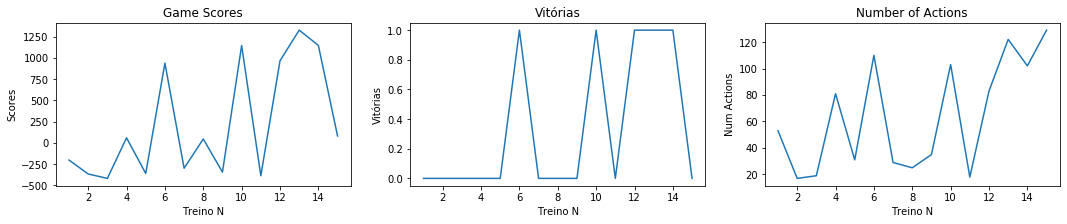

Wins:  5  Loss:  10
Avg Score:  222.2
Avg NumActions:  63.8


In [8]:
printGraphs(gamesScores,results,numActions)

In [9]:
layoutType='mediumClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType,10, pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
Action Score:  [2.248953158533279, 2.246765145692569]
-- epsilon:  0.09
W:  [[1.46742169 1.0687134  1.67272206 0.80631089 0.74816848]]   -  ACTION:  East
Action Score:  [2.2864443079338765, 2.2560743466061735]
-- epsilon:  0.09
W:  [[1.46811339 1.06870361 1.67437684 0.80632456 0.74816848]]   -  ACTION:  East
Action Score:  [2.2872792163600546, 0.5617451071006965]
-- epsilon:  0.09
W:  [[1.46767903 1.0687122  1.67333769 0.80631417 0.74816848]]   -  ACTION:  East
Action Score:  [2.286094898416592, 0.5614091084422234]
-- epsilon:  0.09
W:  [[1.46723831 1.06872274 1.67228334 0.80630116 0.74816848]]   -  ACTION:  East
Action Score:  [2.2814886163686636, 0.55923597355056]
-- epsilon:  0.09
W:  [[1.46678769 1.06873959 1.6712053  0.80628431 0.74816848]]   -  ACTION:  North
Action Score:  [2.284078278671341, 0.5608132496856816]
-- epsilon:  0.09
W:  [[1.46636026 1.06875556 1.67018275 0.80626344 0.748168

Action Score:  [2.2954290659751035, 0.23987925330390758]
-- epsilon:  0.09
W:  [[1.48822231 1.06794665 1.70784346 0.80395164 0.75230535]]   -  ACTION:  East
Action Score:  [0.5631952435567239, 2.320308978765545, 0.5631952435567239, 0.5557689324108456]
-- epsilon:  0.09
W:  [[1.48785731 1.06795743 1.70697025 0.80394776 0.75230535]]   -  ACTION:  South
Action Score:  [0.554859304327762, 2.318850369952084]
-- epsilon:  0.09
W:  [[1.4884748  1.06793919 1.7084475  0.80395353 0.75230535]]   -  ACTION:  South
Action Score:  [0.5633710987743036, 2.3245858730399886, 2.3245858730399886]
-- epsilon:  0.09
W:  [[1.48911443 1.06792655 1.70997772 0.80395883 0.75230535]]   -  ACTION:  South
Action Score:  [2.2969598875790522, 2.298807525049469]
-- epsilon:  0.09
W:  [[1.48956765 1.06791981 1.71111645 0.80396234 0.75230535]]   -  ACTION:  South
Action Score:  [0.5702195652216248, 0.5712374729642686, 0.5712374729642686, 2.3302185462199088]
-- epsilon:  0.09
W:  [[1.49029125 1.06790956 1.71284756 0.8039

Action Score:  [0.1103073551392187, 0.049040706178365326]
-- epsilon:  0.09
W:  [[1.50502924 1.06959635 1.71365781 0.80110187 0.75197197]]   -  ACTION:  North
Action Score:  [0.19667996972202845, 0.07175089842303994]
-- epsilon:  0.09
W:  [[1.50502821 1.06959635 1.71371533 0.80110187 0.75197837]]   -  ACTION:  North
Action Score:  [0.11584681350925019, 0.11161693520364983, 0.11161693520364983, 0.43293855909840345]
-- epsilon:  0.09
W:  [[1.50502515 1.06959635 1.71409726 0.80110187 0.75199364]]   -  ACTION:  West
Action Score:  [0.19496513688868122, 1.716309384674563]
-- epsilon:  0.09
W:  [[1.5050074  1.06959635 1.72297518 0.80110187 0.75205529]]   -  ACTION:  West
Action Score:  [1.7545153404709584, 0.4339491122226641, 0.4321838105378841]
-- epsilon:  0.09
W:  [[1.50498735 1.06959635 1.72186121 0.80110187 0.7520487 ]]   -  ACTION:  South
Action Score:  [0.4326778885935044, 1.7527879667702762]
-- epsilon:  0.09
W:  [[1.50496445 1.06959635 1.72058916 0.80110187 0.75204221]]   -  ACTION:

Action Score:  [-0.005899505846704392, -0.003818555611705879]
-- epsilon:  0.09
W:  [[1.50485576 1.06960271 1.71897326 0.80110187 0.75188195]]   -  ACTION:  West
Action Score:  [-0.004686083675467156, -0.002783326893500108]
-- epsilon:  0.09
W:  [[1.50485575 1.06960265 1.71897329 0.80110187 0.75188195]]   -  ACTION:  East
Action Score:  [-0.001534222428527545, -0.001307871477453264]
-- epsilon:  0.09
W:  [[1.50485575 1.0696026  1.71897332 0.80110187 0.75188195]]   -  ACTION:  West
Action Score:  [-0.0021754011828792495, -0.0002726443585987738]
-- epsilon:  0.09
W:  [[1.50485575 1.06960257 1.71897334 0.80110187 0.75188195]]   -  ACTION:  East
Action Score:  [0.00097645979545737, 0.0002673492383929166]
-- epsilon:  0.09
W:  [[1.50485575 1.06960255 1.71897336 0.80110187 0.75188195]]   -  ACTION:  East
Action Score:  [0.0025026857447727167, 0.0013025761777818966]
-- epsilon:  0.09
W:  [[1.50485575 1.06960251 1.71897339 0.80110187 0.75188195]]   -  ACTION:  East
Action Score:  [0.0043945085

Action Score:  [2.3803812924891963, 0.5846096965705736]
-- epsilon:  0.07500000000000001
W:  [[1.52056718 1.0680016  1.74423351 0.8010193  0.75188195]]   -  ACTION:  East
Action Score:  [2.3791613113268584, 0.5842576942655906]
-- epsilon:  0.07500000000000001
W:  [[1.52009522 1.06801554 1.74310442 0.80100166 0.75188195]]   -  ACTION:  North
Action Score:  [2.38166581745872, 0.5858077712000263]
-- epsilon:  0.07500000000000001
W:  [[1.51963488 1.06802913 1.74200312 0.80097918 0.75188195]]   -  ACTION:  North
Action Score:  [2.37654025716571, 0.5881136115386367, 2.390633236978294, 2.3808991149671392]
-- epsilon:  0.07500000000000001
W:  [[1.52026323 1.06801671 1.74350636 0.80102094 0.75188195]]   -  ACTION:  East
Action Score:  [2.4036004407547487, 2.3542383202985486]
-- epsilon:  0.07500000000000001
W:  [[1.52083374 1.06800723 1.74487121 0.80107553 0.75188195]]   -  ACTION:  East
Action Score:  [2.4232302204488905, 2.395415097761771, 0.5968315356471299]
-- epsilon:  0.07500000000000001


Action Score:  [0.48338087374678174, 1.9493016015863855]
-- epsilon:  0.07500000000000001
W:  [[1.52777978 1.06748495 1.72567152 0.79814073 0.75122654]]   -  ACTION:  West
Action Score:  [0.518428138921136, 2.5142516776887067]
-- epsilon:  0.07500000000000001
W:  [[1.52782752 1.06748495 1.72832372 0.79817347 0.75387874]]   -  ACTION:  West
Action Score:  [0.5791149113209272, 2.3687522309648568]
-- epsilon:  0.07500000000000001
W:  [[1.52659269 1.06761095 1.72517362 0.79804747 0.75387874]]   -  ACTION:  East
Action Score:  [0.24639534855710463, 2.331933835862513]
-- epsilon:  0.07500000000000001
W:  [[1.53269841 1.06745754 1.74051462 0.79823686 0.75387874]]   -  ACTION:  West
Action Score:  [0.5826408926735354, 2.3862421077781804]
-- epsilon:  0.07500000000000001
W:  [[1.53347984 1.06744456 1.7423841  0.79826607 0.75387874]]   -  ACTION:  West
Action Score:  [2.392257005504775, 0.588319375922584]
-- epsilon:  0.07500000000000001
W:  [[1.5330277  1.06745207 1.74130241 0.798244   0.753878

Action Score:  [-3.0311743441347625, -0.17399370214980206]
-- epsilon:  0.07500000000000001
W:  [[1.53800085 1.07165835 1.73590201 0.79514229 0.75302444]]   -  ACTION:  West
Action Score:  [-3.1155997038877925, -0.20274068976016496]
-- epsilon:  0.07500000000000001
W:  [[1.53800089 1.07165708 1.73590215 0.79514229 0.75302446]]   -  ACTION:  West
Action Score:  [-0.20233509264258534, -3.155151468308963]
-- epsilon:  0.07500000000000001
W:  [[1.53790021 1.0744198  1.73559518 0.79514229 0.75297534]]   -  ACTION:  South
Action Score:  [-3.1789983555761228, -0.1731950640929508]
-- epsilon:  0.07500000000000001
W:  [[1.53790698 1.07429888 1.73561453 0.79514229 0.75297821]]   -  ACTION:  South
Action Score:  [-3.1822329497686015, -0.12472695132926688, -0.2063511638589872, -0.2063511638589872]
-- epsilon:  0.07500000000000001
W:  [[1.53791987 1.07415878 1.73564956 0.79514229 0.75297821]]   -  ACTION:  South
Action Score:  [-3.1608964495777063, -0.010413588964956033]
-- epsilon:  0.075000000000

Action Score:  [2.3995654722360698, 0.564097206303717]
-- epsilon:  0.07500000000000001
W:  [[1.55024454 1.07722028 1.76705224 0.79514229 0.75297821]]   -  ACTION:  North
Action Score:  [0.563764239770052, 2.398222892562713]
-- epsilon:  0.07500000000000001
W:  [[1.55083587 1.07719818 1.76846692 0.79514229 0.75297821]]   -  ACTION:  West
Action Score:  [-0.018888924557932257, -0.005797974488912647]
-- epsilon:  0.07500000000000001
W:  [[1.55082882 1.07749856 1.76835317 0.79514229 0.75297821]]   -  ACTION:  West
Action Score:  [-0.020845006414684834, -0.0033494844894348848]
-- epsilon:  0.07500000000000001
W:  [[1.55082884 1.07749812 1.76835337 0.79514229 0.75297821]]   -  ACTION:  West
Action Score:  [-0.018897930715327763, -0.0001963682000508983]
-- epsilon:  0.07500000000000001
W:  [[1.55082889 1.07749756 1.76835366 0.79514229 0.75297821]]   -  ACTION:  West
Action Score:  [-0.0164440536621811, 0.00394929508811157]
-- epsilon:  0.07500000000000001
W:  [[1.55082898 1.07749684 1.768354

Action Score:  [1.83464957002555, 1.8613259894621272, 2.4220092359779875, 0.46575147375894665]
-- epsilon:  0.06
W:  [[1.57364775 1.07608623 1.7808549  0.79250237 0.75246392]]   -  ACTION:  East
Action Score:  [2.333927479147503, 2.387471021050136]
-- epsilon:  0.06
W:  [[1.57404484 1.07604632 1.78185261 0.79250545 0.75249164]]   -  ACTION:  West
Action Score:  [2.4143137815774933, 1.8430273200990823, 2.306860962835068, 0.5742299729795746]
-- epsilon:  0.06
W:  [[1.57365497 1.07608363 1.78091991 0.79250286 0.7524726 ]]   -  ACTION:  North
Action Score:  [2.4094029770910184, 2.311017746997332]
-- epsilon:  0.06
W:  [[1.57416375 1.07603494 1.7821371  0.79250591 0.75249162]]   -  ACTION:  North
Action Score:  [0.5707139128955048, 2.4278978710214667]
-- epsilon:  0.06
W:  [[1.5748115  1.07600332 1.78368674 0.7925102  0.75250712]]   -  ACTION:  East
Action Score:  [2.4373390393126804, 0.5895654469114636]
-- epsilon:  0.06
W:  [[1.57435574 1.07601678 1.7825964  0.79250684 0.75249811]]   -  A

Action Score:  [0.08113879206172657, 0.054012523655153424]
-- epsilon:  0.06
W:  [[1.57175799 1.07608317 1.72347487 0.79243486 0.75183582]]   -  ACTION:  East
Action Score:  [0.1254579918134478, 0.05647822069978729]
-- epsilon:  0.06
W:  [[1.57175751 1.07608317 1.72348976 0.79243486 0.75184244]]   -  ACTION:  East
Action Score:  [0.23534549927389442, 0.0866805874387389]
-- epsilon:  0.06
W:  [[1.57175616 1.07608317 1.72356474 0.79243486 0.75188461]]   -  ACTION:  East
Action Score:  [0.5112904070284261, 0.1346546683647318]
-- epsilon:  0.06
W:  [[1.5717526  1.07608317 1.72401037 0.79243486 0.75208267]]   -  ACTION:  North
Action Score:  [1.8044316054580078, 0.21849650943149324]
-- epsilon:  0.06
W:  [[1.57173483 1.07608317 1.73289595 0.79243486 0.75306996]]   -  ACTION:  North
Action Score:  [0.4771473912543838, 0.4771473912543838, 0.6183480088809418, 1.808254052846478]
-- epsilon:  0.06
W:  [[1.57171193 1.07608317 1.73162393 0.79243486 0.75299046]]   -  ACTION:  West
Action Score:  [0

Action Score:  [2.427040429585774, 0.587039882520306]
-- epsilon:  0.06
W:  [[1.5945386  1.07744712 1.78908292 0.79243486 0.75286357]]   -  ACTION:  East
Action Score:  [0.5867004016458659, 2.4256709684438844, 0.5867004016458659]
-- epsilon:  0.06
W:  [[1.59405059 1.07747955 1.78791543 0.79243486 0.75286357]]   -  ACTION:  East
Action Score:  [0.5863601966444428, 2.4242985861837827, 0.5863601966444428]
-- epsilon:  0.06
W:  [[1.59356302 1.07751195 1.78674901 0.79243486 0.75286357]]   -  ACTION:  East
Action Score:  [2.42292746703704, 0.5860203047609422]
-- epsilon:  0.06
W:  [[1.59307592 1.07754432 1.7855837  0.79243486 0.75286357]]   -  ACTION:  East
Action Score:  [0.23608362471651798, 0.07688978091281551]
-- epsilon:  0.06
W:  [[1.5923301  1.07803242 1.7836313  0.79243486 0.75286357]]   -  ACTION:  East
Action Score:  [0.1181552035216368, 0.13125629197465705, 0.5851119182752469, 0.13125629197465705]
-- epsilon:  0.06
W:  [[1.5925759  1.07799323 1.78425833 0.79243486 0.75286357]]   -

Action Score:  [2.470616839856292, 0.6079641237194993]
-- epsilon:  0.044999999999999984
W:  [[1.6296264  1.07768476 1.7884584  0.78894907 0.75393701]]   -  ACTION:  South
Action Score:  [0.6107927185590334, 2.4755299336866905]
-- epsilon:  0.044999999999999984
W:  [[1.63021281 1.07765613 1.78986128 0.7889777  0.75395893]]   -  ACTION:  South
Action Score:  [0.46831327872867556, 1.8524761889000814, 2.4734056333862595, 1.8529017641907561]
-- epsilon:  0.044999999999999984
W:  [[1.62943879 1.07769392 1.78800956 0.78894876 0.75393   ]]   -  ACTION:  East
Action Score:  [2.4661691046620593, 1.8162380034504955]
-- epsilon:  0.044999999999999984
W:  [[1.62858321 1.07773569 1.78596273 0.78892349 0.75390473]]   -  ACTION:  East
Action Score:  [2.4619126095511072, 0.47094625686874453]
-- epsilon:  0.044999999999999984
W:  [[1.62773903 1.07777691 1.78394315 0.7889033  0.75387979]]   -  ACTION:  East
Action Score:  [0.606256984293765, 2.4564012761124316, 0.46424922805656976]
-- epsilon:  0.044999

Action Score:  [1.8198393268153137, 0.4476406910502829]
-- epsilon:  0.02999999999999997
W:  [[1.6696074  1.1141905  1.77748694 0.78443737 0.75379876]]   -  ACTION:  North
Action Score:  [1.812868649405421, 0.44523214533602606]
-- epsilon:  0.02999999999999997
W:  [[1.66958    1.1141905  1.77596488 0.7844345  0.75379099]]   -  ACTION:  North
Action Score:  [1.8120983496685237, 0.4453641064831551]
-- epsilon:  0.02999999999999997
W:  [[1.66955351 1.1141905  1.77449303 0.78443146 0.75378228]]   -  ACTION:  North
Action Score:  [1.8125533593365275, 0.4462272589577682]
-- epsilon:  0.02999999999999997
W:  [[1.66952719 1.1141905  1.77303063 0.78442814 0.7537702 ]]   -  ACTION:  North
Action Score:  [1.8099373556806615, 0.44677383811703036, 1.812580893448656]
-- epsilon:  0.02999999999999997
W:  [[1.66950368 1.1141905  1.77172479 0.78442488 0.75375714]]   -  ACTION:  West
Action Score:  [1.7777020925318148, 1.815726230979882]
-- epsilon:  0.02999999999999997
W:  [[1.66948058 1.1141905  1.770

Action Score:  [1.835119288972144, 1.835119288972144, 0.6238470864347931]
-- epsilon:  0.02999999999999997
W:  [[1.68933759 1.11024564 1.75626608 0.78527105 0.75104505]]   -  ACTION:  North
Action Score:  [1.7829292098330263, 1.8363368578205774]
-- epsilon:  0.02999999999999997
W:  [[1.68934054 1.11024564 1.75479075 0.78527105 0.75088112]]   -  ACTION:  South
Action Score:  [0.5187502434787461, 1.8686301199148334, 1.1862001318233364]
-- epsilon:  0.02999999999999997
W:  [[1.689318   1.11024564 1.7535382  0.78527105 0.75074195]]   -  ACTION:  South
Action Score:  [0.6226914008471269, 1.8308672919985802]
-- epsilon:  0.02999999999999997
W:  [[1.68928879 1.11024564 1.7519154  0.78527105 0.75064053]]   -  ACTION:  South
Action Score:  [0.6222604039589277, 1.8292376307069396, 1.8292376307069396, 1.8292376307069396]
-- epsilon:  0.02999999999999997
W:  [[1.6892648  1.11024564 1.75058297 0.78527105 0.75055725]]   -  ACTION:  South
Action Score:  [1.830599692608597, 1.8110120286908706]
-- epsi

Action Score:  [0.5431865027288119, 2.4641611408169313]
-- epsilon:  0.02999999999999997
W:  [[1.70863937 1.11148661 1.78245639 0.78527105 0.75459307]]   -  ACTION:  West
Action Score:  [0.5821861283920606, 2.4793006710911163]
-- epsilon:  0.02999999999999997
W:  [[1.70925871 1.11146346 1.78393807 0.78527105 0.75459307]]   -  ACTION:  West
Action Score:  [0.5961252541865061, 2.4872935747922047]
-- epsilon:  0.02999999999999997
W:  [[1.70985148 1.11144928 1.78535618 0.78527105 0.75459307]]   -  ACTION:  West
Action Score:  [0.6027899964336451, 2.490888564095012]
-- epsilon:  0.02999999999999997
W:  [[1.71042834 1.11143787 1.78673623 0.78527105 0.75459307]]   -  ACTION:  West
Action Score:  [0.08769712724129661, 0.2619389910201746]
-- epsilon:  0.02999999999999997
W:  [[1.70967701 1.11158417 1.78476938 0.78527105 0.75459307]]   -  ACTION:  West
Action Score:  [0.14315132304167325, 0.6026248504900698]
-- epsilon:  0.02999999999999997
W:  [[1.70997369 1.11155389 1.78552623 0.78527105 0.754

Action Score:  [2.5917615482277236, 2.535072978759734]
-- epsilon:  0.015000000000000013
W:  [[1.75353316 1.11028808 1.83991601 0.7852063  0.75459307]]   -  ACTION:  East
Action Score:  [2.6108653898506087, 2.5836012821084826, 0.6362882885175141]
-- epsilon:  0.015000000000000013
W:  [[1.75305168 1.1102996  1.83876415 0.78513431 0.75459307]]   -  ACTION:  South
Action Score:  [2.556781100052998, 2.6510664891405713]
-- epsilon:  0.015000000000000013
W:  [[1.75369739 1.11028887 1.84030891 0.78530595 0.75459307]]   -  ACTION:  South
Action Score:  [0.6733108541832683, 2.7640161674165498]
-- epsilon:  0.015000000000000013
W:  [[1.7545486  1.11027848 1.84234529 0.78581505 0.75459307]]   -  ACTION:  East
Action Score:  [3.3572246304524076, 0.7141801831029608]
-- epsilon:  0.015000000000000013
W:  [[1.75573735 1.11026738 1.84518918 0.78865894 0.75459307]]   -  ACTION:  East
Action Score:  [2.633284270829697, 0.47104242073811564]
-- epsilon:  0.015000000000000013
W:  [[1.75575246 1.11026738 1.

Action Score:  [1.8420770822352706, 1.8025604376008069]
-- epsilon:  0.015000000000000013
W:  [[1.76285078 1.1098559  1.7970499  0.77669229 0.75715078]]   -  ACTION:  East
Action Score:  [1.844233269452651, 0.455084313580342]
-- epsilon:  0.015000000000000013
W:  [[1.76282424 1.1098559  1.79557576 0.77669229 0.75712069]]   -  ACTION:  East
Action Score:  [1.848337728376579, 1.8391366088710808, 0.45719830272841927]
-- epsilon:  0.015000000000000013
W:  [[1.76279793 1.1098559  1.79411393 0.77669229 0.75708008]]   -  ACTION:  North
Action Score:  [1.837905836583369, 1.811618333658927]
-- epsilon:  0.015000000000000013
W:  [[1.76280107 1.1098559  1.79254415 0.77669229 0.75698197]]   -  ACTION:  North
Action Score:  [0.4748897136232767, 0.4748897136232767, 1.9083836747506444, 0.4748897136232767]
-- epsilon:  0.015000000000000013
W:  [[1.76278345 1.1098559  1.79156526 0.77669229 0.75687321]]   -  ACTION:  East
Action Score:  [1.9073923883671413, 0.47464067720789593]
-- epsilon:  0.0150000000

Action Score:  [0.621885950200022, 2.555173067863117]
-- epsilon:  0.015000000000000013
W:  [[1.78157509 1.10914731 1.81694573 0.77669229 0.75823639]]   -  ACTION:  West
Action Score:  [2.5567145728506544, 0.6222677892140756]
-- epsilon:  0.015000000000000013
W:  [[1.78105299 1.10915286 1.81569669 0.77669229 0.75823639]]   -  ACTION:  North
Action Score:  [2.555247271361605, 0.6235377972152306]
-- epsilon:  0.015000000000000013
W:  [[1.78052132 1.10915852 1.81442475 0.77669229 0.75823639]]   -  ACTION:  North
Action Score:  [2.5521195974843973, 0.623167684437629]
-- epsilon:  0.015000000000000013
W:  [[1.77998514 1.10916611 1.81314204 0.77669229 0.75823639]]   -  ACTION:  North
Action Score:  [0.2678440448534747, 0.09088236044368675]
-- epsilon:  0.015000000000000013
W:  [[1.77920516 1.10931798 1.81110021 0.77669229 0.75823639]]   -  ACTION:  North
Action Score:  [0.14494756448251245, 0.14494756448251245, 0.6134418739186915]
-- epsilon:  0.015000000000000013
W:  [[1.77950485 1.10928022

Action Score:  [2.605066028805186, 0.6392293497043101]
-- epsilon:  0.0
W:  [[1.81434505 1.10663395 1.84468967 0.77658941 0.75823639]]   -  ACTION:  East
Action Score:  [2.601557958257461, 0.6375983902130228]
-- epsilon:  0.0
W:  [[1.81379107 1.10665032 1.84336435 0.77656871 0.75823639]]   -  ACTION:  North
Action Score:  [2.6037150130432414, 0.6390340110552433]
-- epsilon:  0.0
W:  [[1.81325531 1.10666614 1.84208264 0.77654255 0.75823639]]   -  ACTION:  North
Action Score:  [2.594865178533444, 0.6392864962929401, 2.61052732458763, 2.6010901755681175]
-- epsilon:  0.0
W:  [[1.81380293 1.10665304 1.84339272 0.77657894 0.75823639]]   -  ACTION:  East
Action Score:  [2.6215589652835884, 2.563843375652882]
-- epsilon:  0.0
W:  [[1.81429408 1.10664129 1.84456772 0.77662594 0.75823639]]   -  ACTION:  East
Action Score:  [2.64041535411805, 2.613449175675445, 0.6432244225652632]
-- epsilon:  0.0
W:  [[1.81380189 1.10665306 1.84339024 0.77655235 0.75823639]]   -  ACTION:  South
Action Score:  [

Action Score:  [1.8609160322196379, 0.461280489119189]
-- epsilon:  0.0
W:  [[1.82310366 1.1064383  1.79628967 0.76774757 0.75913712]]   -  ACTION:  East
Action Score:  [1.8594710209120195, 1.8594710209120195, 1.9134541053512013, 0.4757916952034481]
-- epsilon:  0.0
W:  [[1.82308338 1.1064383  1.79516321 0.76774757 0.75901196]]   -  ACTION:  East
Action Score:  [2.0177317029552078, 1.8389552923006323]
-- epsilon:  0.0
W:  [[1.82306905 1.1064383  1.79436725 0.76774757 0.75881297]]   -  ACTION:  East
Action Score:  [2.585995461471994, 2.6407226636459096, 0.6346489165191858]
-- epsilon:  0.0
W:  [[1.82426259 1.1064383  1.7972226  0.76774757 0.75913023]]   -  ACTION:  East
Action Score:  [1.8775049625215177, 1.9833566293693228]
-- epsilon:  0.0
W:  [[1.82427631 1.1064383  1.79036098 0.76774757 0.75741483]]   -  ACTION:  West
Action Score:  [3.260038633391847, 1.9760661374965536, 0.633295400411528]
-- epsilon:  0.0
W:  [[1.83048446 1.10628341 1.79795041 0.76774757 0.75741483]]   -  ACTION: 

Action Score:  [2.6034564494534775, 0.6320039743839279, 0.6274924100577012]
-- epsilon:  0.0
W:  [[1.84707506 1.10545278 1.83955872 0.76774757 0.75741483]]   -  ACTION:  South
Action Score:  [0.6272554710597781, 2.602500123116594]
-- epsilon:  0.0
W:  [[1.84759938 1.10544241 1.84081307 0.76774757 0.75741483]]   -  ACTION:  South
Action Score:  [0.627620569528596, 2.5994621735316747]
-- epsilon:  0.0
W:  [[1.84811775 1.1054271  1.8420532  0.76774757 0.75741483]]   -  ACTION:  West
Action Score:  [0.6279815907582899, 2.5920066805166675]
-- epsilon:  0.0
W:  [[1.84862385 1.10540239 1.84326395 0.76774757 0.75741483]]   -  ACTION:  West
Action Score:  [0.6194218913119365, 2.5717726195400834]
-- epsilon:  0.0
W:  [[1.84909398 1.1053574  1.84438866 0.76774757 0.75741483]]   -  ACTION:  West
Action Score:  [2.4944924491657825, 0.5980940776329697]
-- epsilon:  0.0
W:  [[1.84832911 1.10556072 1.84255882 0.76774757 0.75741483]]   -  ACTION:  North
Action Score:  [2.4923203071370623, 0.59755352882

Action Score:  [0.6389857940964045, 2.6473963503700464, 0.6447531114168983, 2.6416290330495524]
-- epsilon:  0
W:  [[1.88255261 1.10483358 1.86780037 0.76305651 0.75704813]]   -  ACTION:  South
Action Score:  [2.611486367312898, 2.653244773271375]
-- epsilon:  0
W:  [[1.88308272 1.10482477 1.86906857 0.76305938 0.75705564]]   -  ACTION:  South
Action Score:  [0.6494091938172439, 0.28631555831224703]
-- epsilon:  0
W:  [[1.88149407 1.10493734 1.8650159  0.76301886 0.75698359]]   -  ACTION:  North
Action Score:  [2.6112479599946488, 0.20905336362999544]
-- epsilon:  0
W:  [[1.88690278 1.10484297 1.87860561 0.7630565  0.75703668]]   -  ACTION:  North
Action Score:  [0.6515870007319654, 0.6537957375882476, 0.6531750960230642, 2.664970741781113]
-- epsilon:  0
W:  [[1.88758905 1.10483157 1.88024742 0.76306157 0.75704309]]   -  ACTION:  West
Action Score:  [0.6541419565504131, 2.667592189698424]
-- epsilon:  0
W:  [[1.88810357 1.10482302 1.88147832 0.76306583 0.75704856]]   -  ACTION:  West


Action Score:  [0.4664816225638552, 1.9027981194508068]
-- epsilon:  0
W:  [[1.89815832 1.10407419 1.86427971 0.76077356 0.75633962]]   -  ACTION:  West
Action Score:  [0.46563512053276307, 1.9010636529563365]
-- epsilon:  0
W:  [[1.89813329 1.10407419 1.86288898 0.76077356 0.75633481]]   -  ACTION:  West
Action Score:  [0.4645430549743335, 1.8991504938679566]
-- epsilon:  0
W:  [[1.89810826 1.10407419 1.86149836 0.76077356 0.75633095]]   -  ACTION:  West
Action Score:  [1.8975551347561226, 0.46391272796243443]
-- epsilon:  0
W:  [[1.89808042 1.10407419 1.85995155 0.76077356 0.75632709]]   -  ACTION:  North
Action Score:  [1.8956796584956241, 0.46308254482352196]
-- epsilon:  0
W:  [[1.89805256 1.10407419 1.858404   0.76077356 0.75632389]]   -  ACTION:  North
Action Score:  [1.8942839704404548, 0.46251991609133275]
-- epsilon:  0
W:  [[1.89802479 1.10407419 1.85686141 0.76077356 0.75632039]]   -  ACTION:  North
Action Score:  [0.20423689725449634, 0.0719081240617743]
-- epsilon:  0
W: 

Action Score:  [1.9464406752873173, 0.4829240662396417]
-- epsilon:  0
W:  [[1.9291801  1.10508123 1.87284409 0.75586019 0.75586539]]   -  ACTION:  North
Action Score:  [1.9562397621662115, 0.48655829851010124]
-- epsilon:  0
W:  [[1.92915305 1.10508123 1.87134149 0.75585735 0.75577148]]   -  ACTION:  North
Action Score:  [1.9548636481802, 0.48628297018489025]
-- epsilon:  0
W:  [[1.92912442 1.10508123 1.86975059 0.75585406 0.75567205]]   -  ACTION:  North
Action Score:  [1.9901523423589127, 0.49523511552571203]
-- epsilon:  0
W:  [[1.92910055 1.10508123 1.86842477 0.75585106 0.75552473]]   -  ACTION:  North
Action Score:  [1.9349312499927447, 0.4950306577544768, 1.9889854052719111]
-- epsilon:  0
W:  [[1.92907434 1.10508123 1.86696825 0.75584741 0.7553629 ]]   -  ACTION:  West
Action Score:  [1.912034223316866, 2.092626074020075]
-- epsilon:  0
W:  [[1.92906172 1.10508123 1.86626728 0.75584547 0.75518766]]   -  ACTION:  West
Action Score:  [1.950522471340491, 1.9500792286249908, 0.511

Action Score:  [0.46654578662201523, 1.8533521470446013, 0.49268048682367305]
-- epsilon:  0
W:  [[1.91890668 1.11310623 1.7963922  0.75542314 0.75263738]]   -  ACTION:  East
Action Score:  [1.8462924621775312, 0.4753657307874276]
-- epsilon:  0
W:  [[1.91887879 1.11310623 1.79484268 0.75542314 0.75260576]]   -  ACTION:  East
Action Score:  [1.806364227524298, 0.2256934377067776]
-- epsilon:  0
W:  [[1.91888235 1.11310623 1.79306217 0.75542314 0.75256942]]   -  ACTION:  East
Action Score:  [0.4561866741891249, 0.4561866741891249, 1.8393609461727287, 0.4653324831518158]
-- epsilon:  0
W:  [[1.91886033 1.11310623 1.79183865 0.75542314 0.75255031]]   -  ACTION:  East
Action Score:  [1.8339036405663074, 0.45588054077400886]
-- epsilon:  0
W:  [[1.91883285 1.11310623 1.79031187 0.75542314 0.75253504]]   -  ACTION:  East
Action Score:  [1.8310701593084526, 1.8310701593084526, 0.45303085789523106]
-- epsilon:  0
W:  [[1.91880578 1.11310623 1.78880835 0.75542314 0.75252261]]   -  ACTION:  Nort

Action Score:  [0.6396415337591561, 2.641490952909606]
-- epsilon:  0
W:  [[1.94586584 1.1163013  1.85227575 0.75542314 0.75247168]]   -  ACTION:  South
Action Score:  [0.6399822913844304, 2.6428660083630646]
-- epsilon:  0
W:  [[1.94638446 1.11627598 1.85351645 0.75542314 0.75247168]]   -  ACTION:  East
Action Score:  [2.6443240141473625, 0.64034360524086]
-- epsilon:  0
W:  [[1.94583278 1.11630291 1.85219666 0.75542314 0.75247168]]   -  ACTION:  East
Action Score:  [2.642773069406285, 0.6399592598345916]
-- epsilon:  0
W:  [[1.94527156 1.11633032 1.85085403 0.75542314 0.75247168]]   -  ACTION:  East
Action Score:  [2.641195295210749, 0.639568265721054]
-- epsilon:  0
W:  [[1.94471078 1.11635769 1.84951245 0.75542314 0.75247168]]   -  ACTION:  North
Action Score:  [2.639618752073263, 0.6391775766806075]
-- epsilon:  0
W:  [[1.94415054 1.11638505 1.84817215 0.75542314 0.75247168]]   -  ACTION:  North
Action Score:  [0.6387872577998003, 2.6380437026368506, 2.6470445395031983]
-- epsilon

Action Score:  [0.4482052587866533, 2.599842803195322]
-- epsilon:  0
W:  [[1.96858974 1.11584137 1.82743576 0.7479706  0.75380054]]   -  ACTION:  West
Action Score:  [1.8721765583685608, 0.46830544587984285]
-- epsilon:  0
W:  [[1.96845771 1.11584137 1.82010069 0.7479706  0.75370998]]   -  ACTION:  South
Action Score:  [0.46039331917060367, 1.8617619392195208]
-- epsilon:  0
W:  [[1.968432   1.11584137 1.81867197 0.7479706  0.75369818]]   -  ACTION:  South
Action Score:  [0.4582681092104031, 1.8616407234393386]
-- epsilon:  0
W:  [[1.96840776 1.11584137 1.81732568 0.7479706  0.75368471]]   -  ACTION:  South
Action Score:  [0.4556285269575411, 1.8602938703106484]
-- epsilon:  0
W:  [[1.96838337 1.11584137 1.81597067 0.7479706  0.75367116]]   -  ACTION:  South
Action Score:  [0.4562845889373479, 1.8576302615313787, 1.8607061564961875]
-- epsilon:  0
W:  [[1.96835923 1.11584137 1.81462941 0.7479706  0.7536546 ]]   -  ACTION:  East
Action Score:  [1.8593642508598707, 1.8169212388749785]
-

Action Score:  [2.531544735439667, 0.6063640786342681, 0.6063640786342681, 2.6108442130426455]
-- epsilon:  0
W:  [[1.98417339 1.11508089 1.82806299 0.7479706  0.75520301]]   -  ACTION:  West
Action Score:  [2.573160768058069, 2.634690718708253]
-- epsilon:  0
W:  [[1.98476989 1.11505177 1.82949001 0.7479706  0.75520301]]   -  ACTION:  West
Action Score:  [2.636367667072353, 0.6291237935607047, 2.614521754810568]
-- epsilon:  0
W:  [[1.98529168 1.1150263  1.83073834 0.7479706  0.75520301]]   -  ACTION:  South
Action Score:  [2.598128786492042, 2.6468245021116115]
-- epsilon:  0
W:  [[1.98583934 1.11501012 1.83204853 0.7479706  0.75520301]]   -  ACTION:  South
Action Score:  [0.6388588313277103, 2.6529144167792253]
-- epsilon:  0
W:  [[1.98637037 1.11499962 1.83331892 0.7479706  0.75520301]]   -  ACTION:  West
Action Score:  [0.6437791525777186, 2.654406858567495]
-- epsilon:  0
W:  [[1.98688552 1.11498944 1.83455133 0.7479706  0.75520301]]   -  ACTION:  West
Action Score:  [0.644137824

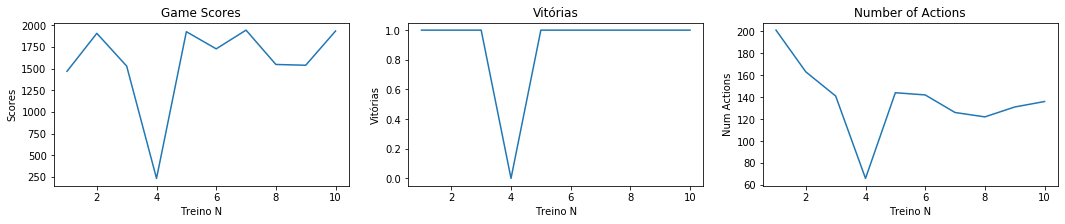

Wins:  9  Loss:  1
Avg Score:  1575.8
Avg NumActions:  137.2


In [10]:
printGraphs(gamesScores,results,numActions)

In [11]:
layoutType='originalClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType,10,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
Action Score:  [2.758095528630349, 2.758008818749863]
-- epsilon:  0
W:  [[2.03298352 1.1178965  1.89070178 0.74793428 0.75520301]]   -  ACTION:  East
Action Score:  [2.740651418227671, 2.7412314812162895, 2.7001959667904734]
-- epsilon:  0
W:  [[2.03334137 1.11789548 1.89155788 0.74793665 0.75520301]]   -  ACTION:  East
Action Score:  [2.7426397556408455, 2.701368340591456]
-- epsilon:  0
W:  [[2.03375985 1.11789444 1.89255903 0.74793974 0.75520301]]   -  ACTION:  East
Action Score:  [2.744095417147988, 0.673190834908536]
-- epsilon:  0
W:  [[2.03317481 1.1178959  1.8911594  0.7479349  0.75520301]]   -  ACTION:  East
Action Score:  [2.7429215581871658, 0.6731861595890789]
-- epsilon:  0
W:  [[2.03258136 1.1178972  1.88973967 0.74792935 0.75520301]]   -  ACTION:  East
Action Score:  [2.7416562780558893, 0.6730526182557737]
-- epsilon:  0
W:  [[2.03198803 1.11789851 1.88832023 0.74792305 0.755

Action Score:  [0.45772971733889767, 1.867782365861382]
-- epsilon:  0
W:  [[2.03018775 1.11788622 1.82132815 0.7437326  0.75400916]]   -  ACTION:  West
Action Score:  [0.45976039234356003, 1.8707531197990699]
-- epsilon:  0
W:  [[2.03016383 1.11788622 1.81999931 0.74373063 0.75398839]]   -  ACTION:  West
Action Score:  [1.8731197508106596, 0.46126820629340554, 1.8670407312700508]
-- epsilon:  0
W:  [[2.03013979 1.11788622 1.81866375 0.7437285  0.75396114]]   -  ACTION:  South
Action Score:  [1.8310906243248313, 1.8866559088571897]
-- epsilon:  0
W:  [[2.03011716 1.11788622 1.81740672 0.74372631 0.75391085]]   -  ACTION:  South
Action Score:  [0.472423375057321, 1.9024741636368898]
-- epsilon:  0
W:  [[2.03009464 1.11788622 1.81615528 0.74372395 0.75383264]]   -  ACTION:  South
Action Score:  [0.24614056959080874, 2.0020898735633725]
-- epsilon:  0
W:  [[2.03009628 1.11788622 1.81533454 0.74372225 0.75362745]]   -  ACTION:  South
Action Score:  [0.5349157275589891, 1.268451380011899, 0

Action Score:  [0.649143236892998, 2.7057242871161677]
-- epsilon:  0
W:  [[2.05111288 1.11692408 1.84848678 0.74388386 0.75581493]]   -  ACTION:  West
Action Score:  [2.7036859634671475, 2.708244372107293, 0.6609647564761846, 2.717284627303524]
-- epsilon:  0
W:  [[2.05164067 1.11691364 1.84974944 0.74391893 0.75581493]]   -  ACTION:  West
Action Score:  [2.667695383757839, 2.727861301447245]
-- epsilon:  0
W:  [[2.05216163 1.11690334 1.85099576 0.74396878 0.75581493]]   -  ACTION:  West
Action Score:  [0.6707376494141735, 2.74606676543452]
-- epsilon:  0
W:  [[2.05270202 1.11689266 1.85228855 0.74404958 0.75581493]]   -  ACTION:  West
Action Score:  [0.680210120521212, 2.7837596524034707]
-- epsilon:  0
W:  [[2.05329497 1.11688093 1.85370709 0.7442072  0.75581493]]   -  ACTION:  West
Action Score:  [0.697373974522528, 2.8888057603592925]
-- epsilon:  0
W:  [[2.05407802 1.11686545 1.85558041 0.74467553 0.75581493]]   -  ACTION:  West
Action Score:  [3.4450720869377216, 2.7876964533202

Action Score:  [1.8639064426745167, 1.8225462274296735]
-- epsilon:  0
W:  [[2.06344334 1.11683693 1.8235091  0.74239414 0.75533435]]   -  ACTION:  North
Action Score:  [0.4534388196357176, 1.8625120877888544]
-- epsilon:  0
W:  [[2.06341891 1.11683693 1.82215194 0.74239263 0.75533248]]   -  ACTION:  West
Action Score:  [0.4530818035009872, 1.861212348486462]
-- epsilon:  0
W:  [[2.06339451 1.11683693 1.82079657 0.74239102 0.75533063]]   -  ACTION:  West
Action Score:  [0.4529333510070194, 1.8600931266388934]
-- epsilon:  0
W:  [[2.06337015 1.11683693 1.81944354 0.74238929 0.75532846]]   -  ACTION:  West
Action Score:  [1.8589139044512368, 0.4527342405927966]
-- epsilon:  0
W:  [[2.06334293 1.11683693 1.81793098 0.74238722 0.75532583]]   -  ACTION:  North
Action Score:  [1.8577299452006655, 0.45261431018291876]
-- epsilon:  0
W:  [[2.06331572 1.11683693 1.81641932 0.74238498 0.75532271]]   -  ACTION:  North
Action Score:  [1.856459569166415, 0.4524243906048705]
-- epsilon:  0
W:  [[2.0

Action Score:  [2.660378609000287, 2.702560965668493]
-- epsilon:  0
W:  [[2.0738013  1.11653114 1.83972559 0.74237169 0.75531197]]   -  ACTION:  South
Action Score:  [0.6598146018133049, 2.703945626143684]
-- epsilon:  0
W:  [[2.07429952 1.11652784 1.84091751 0.74237243 0.75531197]]   -  ACTION:  South
Action Score:  [0.6601353932694696, 2.7053234564151754]
-- epsilon:  0
W:  [[2.07479726 1.11652454 1.84210827 0.74237314 0.75531197]]   -  ACTION:  East
Action Score:  [2.706701505428441, 0.6604577755071631]
-- epsilon:  0
W:  [[2.07422446 1.11652834 1.84073793 0.74237236 0.75531197]]   -  ACTION:  East
Action Score:  [0.04765869902951189, 0.09924686535534752]
-- epsilon:  0
W:  [[2.07393288 1.1166004  1.83990485 0.74235997 0.75531197]]   -  ACTION:  West
Action Score:  [0.06656147080192165, 0.15819581603478503]
-- epsilon:  0
W:  [[2.07394505 1.11659805 1.83993792 0.7423603  0.75531197]]   -  ACTION:  West
Action Score:  [0.28634597646288384, 0.09811170760919774]
-- epsilon:  0
W:  [[2

Action Score:  [0.06113098632476787, 0.03179284700022486]
-- epsilon:  0
W:  [[2.09454073 1.11621621 1.89102915 0.74235784 0.75531197]]   -  ACTION:  North
Action Score:  [0.09952734902472238, 0.04517654988674987, 0.04062103021038605, 0.04517654988674987]
-- epsilon:  0
W:  [[2.09454461 1.11621392 1.89104023 0.74235925 0.75531197]]   -  ACTION:  North
Action Score:  [0.16415238238820296, 0.06568698987118181]
-- epsilon:  0
W:  [[2.09455516 1.11621121 1.89106889 0.74236197 0.75531197]]   -  ACTION:  North
Action Score:  [0.2992153479496959, 0.10214928868594325]
-- epsilon:  0
W:  [[2.09459561 1.11620697 1.89117479 0.74236858 0.75531197]]   -  ACTION:  North
Action Score:  [0.6792384253001846, 0.16416206202790962]
-- epsilon:  0
W:  [[2.09485833 1.11619506 1.89184499 0.74239074 0.75531197]]   -  ACTION:  North
Action Score:  [2.7291602450412102, 0.299314721110699]
-- epsilon:  0
W:  [[2.10065146 1.11614469 1.90640059 0.7425363  0.75531197]]   -  ACTION:  North
Action Score:  [2.789777923

Action Score:  [0.034441522653934284, 0.022458736273359935, 0.01965676330036723]
-- epsilon:  0
W:  [[2.09999079 1.11616068 1.90258997 0.72294717 0.75464135]]   -  ACTION:  North
Action Score:  [0.052672194313171945, 0.02646936975403108]
-- epsilon:  0
W:  [[2.09999062 1.11616068 1.90259042 0.72294717 0.75464683]]   -  ACTION:  North
Action Score:  [0.19571965749688175, 0.05142140299826898]
-- epsilon:  0
W:  [[2.09998867 1.11616068 1.90259617 0.72294717 0.75488978]]   -  ACTION:  North
Action Score:  [0.08938378819114576, 0.7639022760756798]
-- epsilon:  0
W:  [[2.09998084 1.11616068 1.90262338 0.72294717 0.75880812]]   -  ACTION:  East
Action Score:  [0.0062957740956095295, -0.015104459674500892]
-- epsilon:  0
W:  [[2.09997292 1.11625541 1.90257327 0.72294717 0.75876602]]   -  ACTION:  East
Action Score:  [0.01733233286618694, 0.0012753909989188256]
-- epsilon:  0
W:  [[2.09997308 1.11625461 1.90257408 0.72294717 0.75876658]]   -  ACTION:  East
Action Score:  [0.025559420863538247, 

Action Score:  [1.9674954064894996, 0.4888578872690905]
-- epsilon:  0
W:  [[2.11524337 1.11576092 1.87774991 0.71895299 0.75828564]]   -  ACTION:  North
Action Score:  [1.966412493112901, 0.4887582081783245]
-- epsilon:  0
W:  [[2.11521461 1.11576092 1.87615212 0.71894589 0.75818578]]   -  ACTION:  North
Action Score:  [2.002136938376286, 0.4979434142319899, 0.4979434142319899, 0.4979434142319899]
-- epsilon:  0
W:  [[2.11519064 1.11576092 1.87482021 0.7189391  0.75803779]]   -  ACTION:  North
Action Score:  [2.0013741356726547, 0.49799146654827586]
-- epsilon:  0
W:  [[2.11516142 1.11576092 1.873197   0.71892949 0.75785743]]   -  ACTION:  North
Action Score:  [2.10572683322799, 0.5151030252204074]
-- epsilon:  0
W:  [[2.11514583 1.11576092 1.87233124 0.71892348 0.75764099]]   -  ACTION:  North
Action Score:  [2.1057556332862806, 0.5154590663922076]
-- epsilon:  0
W:  [[2.11511523 1.11576092 1.87063087 0.71890943 0.7572159 ]]   -  ACTION:  North
Action Score:  [2.673107934737577, 0.55

Action Score:  [2.7640092537719334, 0.6838398751588117]
-- epsilon:  0
W:  [[2.13375039 1.11538557 1.87525717 0.72082899 0.75742144]]   -  ACTION:  East
Action Score:  [2.7606029306142936, 0.6799667211318807]
-- epsilon:  0
W:  [[2.13314357 1.11540349 1.87380544 0.72081448 0.75742144]]   -  ACTION:  East
Action Score:  [2.760587978045672, 2.760262556897091, 0.6771801621213809]
-- epsilon:  0
W:  [[2.13254809 1.11542108 1.87238085 0.72079689 0.75742144]]   -  ACTION:  North
Action Score:  [2.7612777680799816, 2.719124598441857]
-- epsilon:  0
W:  [[2.13295793 1.11540898 1.87336134 0.72081221 0.75742144]]   -  ACTION:  North
Action Score:  [2.723218572999379, 0.6770508734825013]
-- epsilon:  0
W:  [[2.13228171 1.11542995 1.87166229 0.72077753 0.75742144]]   -  ACTION:  North
Action Score:  [2.760447459548968, 0.6789229011512281, 0.6743705903567973, 0.6876823503405081]
-- epsilon:  0
W:  [[2.13181082 1.11544386 1.87053577 0.72075993 0.75742144]]   -  ACTION:  North
Action Score:  [2.75676

Action Score:  [0.46219065026324363, 1.89510794467793]
-- epsilon:  0
W:  [[2.13317223 1.11545768 1.85098437 0.70032672 0.75714302]]   -  ACTION:  South
Action Score:  [0.462261442492411, 1.8943220494540902, 1.8943220494540902]
-- epsilon:  0
W:  [[2.13314743 1.11545768 1.84960663 0.70032581 0.75713487]]   -  ACTION:  South
Action Score:  [1.8496409717824334, 1.8937461549080497]
-- epsilon:  0
W:  [[2.13312267 1.11545768 1.84823103 0.70032486 0.75712531]]   -  ACTION:  South
Action Score:  [0.46350976295119445, 1.8947100465087694]
-- epsilon:  0
W:  [[2.13309811 1.11545768 1.84686697 0.70032386 0.75711167]]   -  ACTION:  South
Action Score:  [0.46419265612390787, 1.895150166128634]
-- epsilon:  0
W:  [[2.13307348 1.11545768 1.84549837 0.70032281 0.75709478]]   -  ACTION:  West
Action Score:  [0.4669668525391026, 1.899916298387937]
-- epsilon:  0
W:  [[2.1330494  1.11545768 1.84416057 0.70032172 0.75706748]]   -  ACTION:  West
Action Score:  [0.4691435936655952, 1.9041909217707351]
-- e

Action Score:  [0.08850424421190303, 0.04129901429126206]
-- epsilon:  0
W:  [[2.14519806 1.11544479 1.87161885 0.70029685 0.75973096]]   -  ACTION:  South
Action Score:  [0.05506635227189731, 0.13645163105155134]
-- epsilon:  0
W:  [[2.1452086  1.11543205 1.8716475  0.70029759 0.75973096]]   -  ACTION:  South
Action Score:  [0.07495053998608975, 0.2305143119714949, 0.07495053998608975]
-- epsilon:  0
W:  [[2.14523747 1.11538955 1.87172307 0.70029877 0.75973096]]   -  ACTION:  South
Action Score:  [0.09773178482965159, 0.4006404682243716]
-- epsilon:  0
W:  [[2.14541627 1.11493342 1.87217919 0.70030222 0.75973096]]   -  ACTION:  South
Action Score:  [0.021563358747696354, 2.4485373127811454, -3.9133402171905867]
-- epsilon:  0
W:  [[2.14669319 1.11413134 1.87538754 0.70030779 0.75973096]]   -  ACTION:  South
Action Score:  [-3.653624472997842, 2.495292947740845]
-- epsilon:  0
W:  [[2.14741291 1.11370088 1.87710935 0.70031054 0.75973096]]   -  ACTION:  South
Action Score:  [0.402514397

Action Score:  [0.6968598738853264, 2.8453068113448605]
-- epsilon:  0
W:  [[2.1723958  1.11389183 1.93906924 0.70035181 0.75973096]]   -  ACTION:  West
Action Score:  [2.846417349402465, 0.6973163565417848, 2.8471368721938943]
-- epsilon:  0
W:  [[2.17284763 1.11388996 1.94015017 0.7003548  0.75973096]]   -  ACTION:  West
Action Score:  [2.8043929839964985, 2.8486282272146424]
-- epsilon:  0
W:  [[2.17329782 1.11388809 1.9412272  0.70035813 0.75973096]]   -  ACTION:  West
Action Score:  [0.6979286141931602, 2.850155237030303]
-- epsilon:  0
W:  [[2.17374763 1.11388622 1.94230329 0.70036185 0.75973096]]   -  ACTION:  West
Action Score:  [0.698463282490508, 2.851731755198758]
-- epsilon:  0
W:  [[2.17419708 1.11388435 1.94337851 0.70036605 0.75973096]]   -  ACTION:  West
Action Score:  [0.6990379399117475, 2.853371802623153]
-- epsilon:  0
W:  [[2.17464618 1.11388249 1.94445294 0.70037083 0.75973096]]   -  ACTION:  West
Action Score:  [0.6996629737606791, 2.854726952476268]
-- epsilon: 

Action Score:  [0.03843680943739234, 0.07718709732390107]
-- epsilon:  0
W:  [[2.17654851 1.11374193 1.90623545 0.69625752 0.76189915]]   -  ACTION:  West
Action Score:  [0.053888853934753, 0.12240560988897481]
-- epsilon:  0
W:  [[2.17654801 1.11374193 1.90625093 0.69625752 0.76190163]]   -  ACTION:  West
Action Score:  [0.21685875639515603, 0.0781936490701911]
-- epsilon:  0
W:  [[2.17654688 1.11374193 1.90631384 0.69625752 0.76190862]]   -  ACTION:  North
Action Score:  [0.48777452156664763, 0.12419780045862545]
-- epsilon:  0
W:  [[2.17654336 1.11374193 1.90675412 0.69625752 0.76194456]]   -  ACTION:  North
Action Score:  [1.9235661558212198, 0.21941386548686181]
-- epsilon:  0
W:  [[2.1765235  1.11374193 1.9166856  0.69625752 0.76222044]]   -  ACTION:  North
Action Score:  [0.4959911419008025, 2.0035017961848944, 0.4959911419008025]
-- epsilon:  0
W:  [[2.17650587 1.11374193 1.91570628 0.69625752 0.76215923]]   -  ACTION:  East
Action Score:  [2.701736629187648, 0.647674467747302]

Action Score:  [0.7008980939851663, 2.843218759800129]
-- epsilon:  0
W:  [[2.18733306 1.11651344 1.908114   0.69615549 0.76215923]]   -  ACTION:  West
Action Score:  [2.8615675597242105, 0.7063634125567735, 2.836060377638901]
-- epsilon:  0
W:  [[2.1878353  1.11650874 1.90931554 0.69623058 0.76215923]]   -  ACTION:  North
Action Score:  [2.897743635089282, 2.803561851018034]
-- epsilon:  0
W:  [[2.18831818 1.11650518 1.91047075 0.69635894 0.76215923]]   -  ACTION:  North
Action Score:  [2.9958314849095773, 0.7321493003449666]
-- epsilon:  0
W:  [[2.18797209 1.11650773 1.90964279 0.69615195 0.76215923]]   -  ACTION:  North
Action Score:  [0.7657361681369216, 3.5169210653305636]
-- epsilon:  0
W:  [[2.18993635 1.11649323 1.91434197 0.70085113 0.76215923]]   -  ACTION:  East
Action Score:  [2.613165573418387, 0.4774221111243599]
-- epsilon:  0
W:  [[2.18995431 1.11649323 1.90536095 0.69187011 0.76213151]]   -  ACTION:  East
Action Score:  [1.9481558629929872, 0.47474814533843496]
-- epsi

Action Score:  [0.46518362001912816, 1.887470521356075]
-- epsilon:  0
W:  [[2.18836027 1.11649323 1.82715815 0.68383744 0.76102404]]   -  ACTION:  West
Action Score:  [1.8819285991822547, 0.46779278339182, 1.8924370598142575]
-- epsilon:  0
W:  [[2.18833633 1.11649323 1.82582793 0.6838282  0.76098709]]   -  ACTION:  West
Action Score:  [1.841027926590678, 1.9013089400433931]
-- epsilon:  0
W:  [[2.18831282 1.11649323 1.82452186 0.68381741 0.76093485]]   -  ACTION:  West
Action Score:  [0.4869399646676966, 1.9552979788715148]
-- epsilon:  0
W:  [[2.18829503 1.11649323 1.82353353 0.68380753 0.76082503]]   -  ACTION:  West
Action Score:  [2.058780402332244, 0.5047096592789732, 1.9189164749169632]
-- epsilon:  0
W:  [[2.18828288 1.11649323 1.82285837 0.68380195 0.76065624]]   -  ACTION:  South
Action Score:  [1.909837180568121, 2.7517000519798716]
-- epsilon:  0
W:  [[2.19107762 1.11649323 1.82954436 0.68384838 0.76073879]]   -  ACTION:  South
Action Score:  [0.4680474120228818, 1.8793172

Action Score:  [1.8352207421873072, 1.8348237198615591, 0.44725966716393223, 1.835449365138138]
-- epsilon:  0
W:  [[2.22800942 1.15786339 1.7893374  0.67702421 0.76313482]]   -  ACTION:  West
Action Score:  [1.789112148759522, 1.8339577671486962]
-- epsilon:  0
W:  [[2.22798539 1.15786339 1.7880023  0.67702118 0.7631296 ]]   -  ACTION:  West
Action Score:  [0.4476288445234992, 0.4468777442621538, 1.8321454288634038]
-- epsilon:  0
W:  [[2.22796134 1.15786339 1.78666609 0.67701842 0.76312498]]   -  ACTION:  West
Action Score:  [0.44638635881352584, 1.8301631175147985]
-- epsilon:  0
W:  [[2.22793729 1.15786339 1.7853301  0.6770159  0.76312128]]   -  ACTION:  West
Action Score:  [0.4456307553977839, 1.8285161460951191]
-- epsilon:  0
W:  [[2.22791331 1.15786339 1.78399811 0.67701358 0.76311795]]   -  ACTION:  West
Action Score:  [0.44517880156056355, 1.8272881415329316]
-- epsilon:  0
W:  [[2.22788942 1.15786339 1.78267045 0.67701107 0.76311463]]   -  ACTION:  West
Action Score:  [1.826

Action Score:  [0.014756202964952003, -2.00209568189186]
-- epsilon:  0
W:  [[2.23019121 1.16044027 1.75236211 0.67720728 0.76521323]]   -  ACTION:  North
Action Score:  [0.10712447550615549, -1.981212117899026]
-- epsilon:  0
W:  [[2.23013227 1.16072502 1.75220194 0.67692253 0.76521323]]   -  ACTION:  North
Action Score:  [0.3296070151268632, -1.9448424539300035]
-- epsilon:  0
W:  [[2.23006012 1.16091389 1.75201307 0.67649757 0.76521323]]   -  ACTION:  North
Action Score:  [1.2040562988711203, -1.8727308416975275, 0.10696816457607307]
-- epsilon:  0
W:  [[2.23066932 1.16022318 1.75356716 0.68271392 0.76521323]]   -  ACTION:  North
Action Score:  [2.516843432842942, -1.6914329737613518]
-- epsilon:  0
W:  [[2.23065878 1.16022318 1.75883998 0.68798674 0.7657991 ]]   -  ACTION:  North
Action Score:  [1.847618712358431, 0.62757598705161]
-- epsilon:  0
W:  [[2.23053551 1.16022318 1.75199209 0.68797913 0.76537111]]   -  ACTION:  North
Action Score:  [1.8406933208151512, 0.6256977768684813

Action Score:  [0.7015705037846758, 2.7188168630303995]
-- epsilon:  0
W:  [[2.25353624 1.15971723 1.76218231 0.69011272 0.76438321]]   -  ACTION:  East
Action Score:  [2.7142315308731773, 0.685784125124668]
-- epsilon:  0
W:  [[2.25294098 1.15972215 1.76075825 0.69008365 0.76438321]]   -  ACTION:  East
Action Score:  [2.708115809942644, 0.6761338880181751]
-- epsilon:  0
W:  [[2.25234264 1.15972852 1.75932683 0.69006129 0.76438321]]   -  ACTION:  East
Action Score:  [2.7041709781660845, 0.6706312678120866]
-- epsilon:  0
W:  [[2.25175289 1.15973479 1.75791593 0.69004387 0.76438321]]   -  ACTION:  East
Action Score:  [2.6991867419118183, 0.6657783246703877]
-- epsilon:  0
W:  [[2.25116133 1.15974316 1.75650071 0.69002972 0.76438321]]   -  ACTION:  East
Action Score:  [2.6964203736551835, 2.6963264818437294, 0.6613954868398406]
-- epsilon:  0
W:  [[2.2505781  1.15975469 1.75510544 0.69001249 0.76438321]]   -  ACTION:  North
Action Score:  [2.6923105745859095, 2.6481509018652547]
-- epsi

Action Score:  [0.08470719758237612, 0.03038605749328465]
-- epsilon:  0
W:  [[2.25170391 1.15982749 1.75118048 0.67099333 0.76391506]]   -  ACTION:  South
Action Score:  [0.03001792356271936, 0.08513437628112605]
-- epsilon:  0
W:  [[2.25170407 1.15982749 1.75118028 0.67099329 0.7639061 ]]   -  ACTION:  South
Action Score:  [0.04757454837590516, 0.1917231937165837]
-- epsilon:  0
W:  [[2.25170271 1.15982749 1.75118217 0.67099369 0.76407693]]   -  ACTION:  South
Action Score:  [0.04800973994241803, 0.19234008093513486]
-- epsilon:  0
W:  [[2.25170304 1.15982749 1.75118166 0.67099359 0.76403569]]   -  ACTION:  South
Action Score:  [-0.12562808340324638, -2.0597200399579862, -0.12375597826370262]
-- epsilon:  0
W:  [[2.25170454 1.16009801 1.75117324 0.67099199 0.76403569]]   -  ACTION:  West
Action Score:  [-0.12479908040166288, -0.04008384486611631]
-- epsilon:  0
W:  [[2.25170423 1.16007009 1.75117597 0.67099247 0.76403569]]   -  ACTION:  West
Action Score:  [-0.041289082001725555, -0.

Action Score:  [0.6548253656153579, 2.7224241885188776]
-- epsilon:  0
W:  [[2.2654657  1.1578204  1.7855353  0.67103759 0.76403569]]   -  ACTION:  West
Action Score:  [0.6598233593360097, 2.726641614301366]
-- epsilon:  0
W:  [[2.2659658  1.15781332 1.78673173 0.67103936 0.76403569]]   -  ACTION:  West
Action Score:  [0.6628171073033993, 2.7298332598981654]
-- epsilon:  0
W:  [[2.26646141 1.15780805 1.78791739 0.67104126 0.76403569]]   -  ACTION:  West
Action Score:  [2.7324570108153647, 0.6649394180565458]
-- epsilon:  0
W:  [[2.26588416 1.15781283 1.78653642 0.67103886 0.76403569]]   -  ACTION:  South
Action Score:  [0.1608412513710854, 0.6667520195586656]
-- epsilon:  0
W:  [[2.26428921 1.15785791 1.78246766 0.67100809 0.76403569]]   -  ACTION:  South
Action Score:  [0.29211604162443333, 0.2926978761176894, 2.6824156165188215]
-- epsilon:  0
W:  [[2.27112023 1.157819   1.79963104 0.67104355 0.76403569]]   -  ACTION:  West
Action Score:  [0.6708515075106196, 2.747586385941469]
-- ep

Action Score:  [1.8341575477203238, 1.833030498757387, 0.4460333903407277]
-- epsilon:  0
W:  [[2.27307916 1.15777176 1.78722301 0.66602696 0.76527755]]   -  ACTION:  South
Action Score:  [1.786078086149534, 1.8326667053717296]
-- epsilon:  0
W:  [[2.27305515 1.15777176 1.78588895 0.66602696 0.76526966]]   -  ACTION:  South
Action Score:  [0.4458305644398671, 1.8321183161221306]
-- epsilon:  0
W:  [[2.27303128 1.15777176 1.78456287 0.66602696 0.76526045]]   -  ACTION:  South
Action Score:  [0.44549904475289753, 1.830791740754041]
-- epsilon:  0
W:  [[2.27300732 1.15777176 1.78323162 0.66602696 0.76525121]]   -  ACTION:  East
Action Score:  [1.8304701448809113, 0.44579000476876446]
-- epsilon:  0
W:  [[2.27298062 1.15777176 1.78174867 0.66602696 0.76523895]]   -  ACTION:  East
Action Score:  [1.8289866142351794, 0.4454192484148178]
-- epsilon:  0
W:  [[2.27295379 1.15777176 1.78025762 0.66602696 0.76522663]]   -  ACTION:  East
Action Score:  [1.8288230510251722, 0.445832570384598]
-- ep

Action Score:  [-0.00915126077110675, -0.012139765714203714]
-- epsilon:  0
W:  [[2.27984168 1.15870347 1.79676421 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.012431078974233383, -0.008890596155522571, -0.009385425614674661]
-- epsilon:  0
W:  [[2.27984168 1.15870349 1.7967642  0.66602696 0.76512533]]   -  ACTION:  East
Action Score:  [-0.00859928141525703, -0.012691742648829345]
-- epsilon:  0
W:  [[2.27984169 1.15870351 1.7967642  0.66602696 0.76512533]]   -  ACTION:  East
Action Score:  [-0.006137514568303047, -0.008890596453662955]
-- epsilon:  0
W:  [[2.27984167 1.15870344 1.79676422 0.66602696 0.76512533]]   -  ACTION:  East
Action Score:  [-0.005078914683126483, -0.00576882988545482, -0.006464481617042736]
-- epsilon:  0
W:  [[2.27984167 1.15870344 1.79676422 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.0053702295566276405, -0.006137514142124613]
-- epsilon:  0
W:  [[2.27984168 1.15870347 1.79676421 0.66602696 0.76512533]]   -  ACTION:  North

Action Score:  [-0.005057114843516382, -0.005311301536621652]
-- epsilon:  0
W:  [[2.27984236 1.1587048  1.79676392 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.00540626481002412, -0.00540626481002412]
-- epsilon:  0
W:  [[2.27984238 1.15870482 1.79676392 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.00549419529452137, -0.005893561784571458]
-- epsilon:  0
W:  [[2.2798424  1.15870485 1.79676391 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.005406265002966962, -0.005406265002966962]
-- epsilon:  0
W:  [[2.27984241 1.15870487 1.7967639  0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.005057115147823238, -0.005311301873856514]
-- epsilon:  0
W:  [[2.27984242 1.15870488 1.7967639  0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.004969184818300011, -0.004969184818300011]
-- epsilon:  0
W:  [[2.27984244 1.1587049  1.79676389 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.004878387282028962, -0.0

Action Score:  [-0.005057118414696527, -0.005311305463670727]
-- epsilon:  0
W:  [[2.27984325 1.15870574 1.7967636  0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.0049691880843251365, -0.0049691880843251365]
-- epsilon:  0
W:  [[2.27984327 1.15870576 1.79676359 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.0047206776878156945, -0.0048742249428157065]
-- epsilon:  0
W:  [[2.27984328 1.15870577 1.79676358 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.004632747356834828, -0.004632747356834828]
-- epsilon:  0
W:  [[2.2798433  1.15870579 1.79676358 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.004580810348942999, -0.004695496939690649]
-- epsilon:  0
W:  [[2.27984331 1.1587058  1.79676357 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.0047904602043724424, -0.0047904602043724424]
-- epsilon:  0
W:  [[2.27984333 1.15870582 1.79676356 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.004878390659512

Action Score:  [-0.005494203231972647, -0.005893570714229058]
-- epsilon:  0
W:  [[2.27984413 1.15870682 1.79676327 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.005406272898622591, -0.005406272898622591]
-- epsilon:  0
W:  [[2.27984414 1.15870684 1.79676327 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.005057122301646679, -0.005311309767612129]
-- epsilon:  0
W:  [[2.27984415 1.15870685 1.79676326 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.0049691919703641185, -0.0049691919703641185]
-- epsilon:  0
W:  [[2.27984417 1.15870687 1.79676326 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.004720681252329904, -0.004874228827870672]
-- epsilon:  0
W:  [[2.27984418 1.15870688 1.79676325 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.004632750920437882, -0.004632750920437882]
-- epsilon:  0
W:  [[2.2798442  1.1587069  1.79676325 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.004456197368897239,

Action Score:  [-0.005260776423741901, -0.005580627997300164]
-- epsilon:  0
W:  [[2.27984498 1.15870792 1.79676296 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.0056755912939513865, -0.0056755912939513865]
-- epsilon:  0
W:  [[2.27984501 1.15870795 1.79676295 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.005260776612314397, -0.005580628208750899]
-- epsilon:  0
W:  [[2.27984502 1.15870796 1.79676294 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.005172846279680328, -0.005172846279680328]
-- epsilon:  0
W:  [[2.27984503 1.15870798 1.79676294 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.0048783977760846284, -0.005077883141403427]
-- epsilon:  0
W:  [[2.27984505 1.158708   1.79676293 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.004790467443776335, -0.004790467443776335]
-- epsilon:  0
W:  [[2.27984506 1.15870801 1.79676293 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.004580817137531527

Action Score:  [-0.0042281719581886415, -0.0042281719581886415, -0.0041837108839633125]
-- epsilon:  0
W:  [[2.27984581 1.1587088  1.79676252 0.66602696 0.76512533]]   -  ACTION:  West
Action Score:  [-0.004360154483049076, -0.004295159761461797]
-- epsilon:  0
W:  [[2.27984583 1.15870882 1.79676251 0.66602696 0.76512533]]   -  ACTION:  West
Action Score:  [-0.004481291964857878, -0.004397926347619092]
-- epsilon:  0
W:  [[2.27984585 1.15870884 1.7967625  0.66602696 0.76512533]]   -  ACTION:  West
Action Score:  [-0.004592740846093799, -0.004492889614483564]
-- epsilon:  0
W:  [[2.27984587 1.15870885 1.7967625  0.66602696 0.76512533]]   -  ACTION:  West
Action Score:  [-0.004695507436111126, -0.004580820054306044]
-- epsilon:  0
W:  [[2.27984588 1.15870887 1.79676249 0.66602696 0.76512533]]   -  ACTION:  West
Action Score:  [-0.004790470706934564, -0.004790470706934564]
-- epsilon:  0
W:  [[2.2798459  1.15870889 1.79676248 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.

Action Score:  [-0.02651392048364628, -0.02078872255909741]
-- epsilon:  0
W:  [[2.27984671 1.15871151 1.79676218 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.02642599874117102, -0.034767526193352036]
-- epsilon:  0
W:  [[2.27984678 1.15871228 1.79676215 0.66602696 0.76512533]]   -  ACTION:  North
Action Score:  [-0.049215246743122866, -0.026331051334282703]
-- epsilon:  0
W:  [[2.27984676 1.15871212 1.79676216 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.04912730977360749, -0.026228281433485337]
-- epsilon:  0
W:  [[2.27984675 1.15871195 1.79676216 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.049032339893685266, -0.02611682919879494]
-- epsilon:  0
W:  [[2.27984674 1.15871178 1.79676217 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.048929566602775476, -0.02599568831660219, -0.02599568831660219]
-- epsilon:  0
W:  [[2.27984672 1.15871161 1.79676218 0.66602696 0.76512533]]   -  ACTION:  South
Action Score:  [-0.04881

Action Score:  [2.7750708511042017, 0.6793728607927436]
-- epsilon:  0
W:  [[2.30015005 1.15851285 1.81007999 0.66597283 0.76512533]]   -  ACTION:  East
Action Score:  [2.7737350046719538, 0.6793306306926163]
-- epsilon:  0
W:  [[2.29954576 1.15851435 1.80863432 0.66596545 0.76512533]]   -  ACTION:  East
Action Score:  [2.7724075238815757, 0.6792683799065201]
-- epsilon:  0
W:  [[2.29894194 1.15851607 1.80718977 0.6659569  0.76512533]]   -  ACTION:  East
Action Score:  [2.7713946558909672, 0.6792859601310106]
-- epsilon:  0
W:  [[2.29833951 1.15851778 1.80574855 0.6659469  0.76512533]]   -  ACTION:  East
Action Score:  [2.770580612324329, 0.6794093904683516]
-- epsilon:  0
W:  [[2.29773802 1.1585195  1.80430957 0.665935   0.76512533]]   -  ACTION:  East
Action Score:  [2.769945712840826, 0.6795930241814365]
-- epsilon:  0
W:  [[2.29713734 1.15852133 1.80287254 0.66592063 0.76512533]]   -  ACTION:  East
Action Score:  [2.7698194824500417, 0.6800538241422908]
-- epsilon:  0
W:  [[2.29653

Action Score:  [0.43333621874896755, 0.43333621874896755, 0.43333621874896755, 1.7815845548829792]
-- epsilon:  0
W:  [[2.29772121 1.15851365 1.73391732 0.65300268 0.76447487]]   -  ACTION:  West
Action Score:  [0.4336307331460866, 1.7814323300984523]
-- epsilon:  0
W:  [[2.29769813 1.15851365 1.73263496 0.65299948 0.76446728]]   -  ACTION:  West
Action Score:  [0.4334417000124159, 1.7803258621614975]
-- epsilon:  0
W:  [[2.29767493 1.15851365 1.73134585 0.65299591 0.76445965]]   -  ACTION:  West
Action Score:  [1.7796452315570264, 0.4337739056314334, 1.7800281612559783]
-- epsilon:  0
W:  [[2.29765184 1.15851365 1.73006344 0.65299195 0.76445075]]   -  ACTION:  West
Action Score:  [1.7325856653754381, 1.779998437047122]
-- epsilon:  0
W:  [[2.2976288  1.15851365 1.7287832  0.65298752 0.76444017]]   -  ACTION:  West
Action Score:  [0.43492454944213654, 1.7803356573856348]
-- epsilon:  0
W:  [[2.2976058  1.15851365 1.72750563 0.65298253 0.76442739]]   -  ACTION:  West
Action Score:  [1.7

Action Score:  [0.6413457107380981, 2.6457817061617135]
-- epsilon:  0
W:  [[2.31427927 1.15842351 1.69502077 0.652105   0.76896957]]   -  ACTION:  South
Action Score:  [0.6354199852007592, 2.6336278036030176]
-- epsilon:  0
W:  [[2.31475573 1.15839185 1.69616064 0.65210683 0.76897309]]   -  ACTION:  East
Action Score:  [2.5951219780137844, 0.6218034438185968]
-- epsilon:  0
W:  [[2.31408687 1.15849186 1.69456049 0.65210405 0.76896755]]   -  ACTION:  East
Action Score:  [2.376876183967414, 0.5817190490700341]
-- epsilon:  0
W:  [[2.31288994 1.15920773 1.69169702 0.65209863 0.76895483]]   -  ACTION:  East
Action Score:  [-4.370176111171261, -0.25798503885493074]
-- epsilon:  0
W:  [[2.31282868 1.16441998 1.69143963 0.65206244 0.76887339]]   -  ACTION:  West
Action Score:  [-4.380968363339212, -0.25080001617448694]
-- epsilon:  0
W:  [[2.31282993 1.16434695 1.69144419 0.65206291 0.76887453]]   -  ACTION:  West
Action Score:  [-4.3815031993691935, -0.2386878270572896]
-- epsilon:  0
W:  [

Action Score:  [0.42666350207717274, 1.7638365477876135]
-- epsilon:  0
W:  [[2.33264322 1.17156153 1.71911898 0.64721377 0.76874654]]   -  ACTION:  South
Action Score:  [0.42656766670417967, 1.7628497517830517, 1.762559769421743]
-- epsilon:  0
W:  [[2.33262029 1.17156153 1.71784481 0.64721377 0.76874365]]   -  ACTION:  East
Action Score:  [1.7617538344736992, 1.7147678829281519]
-- epsilon:  0
W:  [[2.33259447 1.17156153 1.71641064 0.64721377 0.76874006]]   -  ACTION:  East
Action Score:  [1.7607699947892606, 0.42635932115099]
-- epsilon:  0
W:  [[2.33256869 1.17156153 1.71497815 0.64721377 0.76873564]]   -  ACTION:  East
Action Score:  [1.7596243743533766, 0.42620886249545686]
-- epsilon:  0
W:  [[2.3325429  1.17156153 1.71354529 0.64721377 0.76873068]]   -  ACTION:  North
Action Score:  [1.758191028486582, 0.42585068422873945]
-- epsilon:  0
W:  [[2.33251708 1.17156153 1.71211127 0.64721377 0.76872572]]   -  ACTION:  North
Action Score:  [1.7570994113600573, 0.4257353933300526]
-- 

Action Score:  [0.0197209648700021, 0.011944204418914351]
-- epsilon:  0
W:  [[2.34052781 1.17149307 1.7073754  0.64721377 0.76857781]]   -  ACTION:  East
Action Score:  [0.025535374859934835, 0.015132924784336473]
-- epsilon:  0
W:  [[2.34052792 1.171493   1.70737586 0.64721377 0.76857781]]   -  ACTION:  East
Action Score:  [0.033696258885513135, 0.019334374306217077]
-- epsilon:  0
W:  [[2.34052815 1.17149286 1.7073767  0.64721377 0.76857781]]   -  ACTION:  East
Action Score:  [0.04565399974790112, 0.0250270999820143]
-- epsilon:  0
W:  [[2.34052866 1.17149261 1.70737839 0.64721377 0.76857781]]   -  ACTION:  East
Action Score:  [0.06417585116911077, 0.0330093162220947]
-- epsilon:  0
W:  [[2.34052985 1.17149209 1.70738202 0.64721377 0.76857781]]   -  ACTION:  East
Action Score:  [0.09648655787324713, 0.045654121188816656]
-- epsilon:  0
W:  [[2.34053308 1.17149119 1.70739125 0.64721377 0.76857781]]   -  ACTION:  East
Action Score:  [0.1559680763447378, 0.06513667805167793]
-- epsilon

Action Score:  [-0.012536120160146129, -0.00814505443316836]
-- epsilon:  0
W:  [[2.35370628 1.17151742 1.74043768 0.64721377 0.76857781]]   -  ACTION:  South
Action Score:  [-0.01373237153111309, -0.008993444923047867]
-- epsilon:  0
W:  [[2.35370629 1.17151748 1.74043766 0.64721377 0.76857781]]   -  ACTION:  South
Action Score:  [-0.014734841851286548, -0.009717786973984408]
-- epsilon:  0
W:  [[2.35370629 1.17151754 1.74043764 0.64721377 0.76857781]]   -  ACTION:  West
Action Score:  [-0.015583232483954762, -0.010341136409947466]
-- epsilon:  0
W:  [[2.3537063  1.1715176  1.74043763 0.64721377 0.76857781]]   -  ACTION:  West
Action Score:  [-0.01630757469134837, -0.01088143124309663]
-- epsilon:  0
W:  [[2.35370631 1.17151765 1.74043762 0.64721377 0.76857781]]   -  ACTION:  West
Action Score:  [-0.011352796761367879, -0.016930924291294332]
-- epsilon:  0
W:  [[2.35370631 1.17151768 1.74043761 0.64721377 0.76857781]]   -  ACTION:  South
Action Score:  [-0.01747121909722307, -0.011766

Action Score:  [0.0029987207008316504, 0.006984973671885785]
-- epsilon:  0
W:  [[2.35370646 1.17151788 1.74043778 0.64721377 0.76857781]]   -  ACTION:  West
Action Score:  [0.0051848062912329546, 0.010525159706187327]
-- epsilon:  0
W:  [[2.3537065  1.1715177  1.74043803 0.64721377 0.76857781]]   -  ACTION:  West
Action Score:  [0.007939904684301911, 0.013976253696292327]
-- epsilon:  0
W:  [[2.35370656 1.17151748 1.74043835 0.64721377 0.76857781]]   -  ACTION:  West
Action Score:  [0.020267184386576553, 0.005742048295387766, 0.009321685032143954, 0.009321685032143954]
-- epsilon:  0
W:  [[2.35370669 1.17151717 1.7404389  0.64721377 0.76857781]]   -  ACTION:  North
Action Score:  [0.02906207544233388, 0.010396630753393834]
-- epsilon:  0
W:  [[2.35370696 1.17151673 1.74043989 0.64721377 0.76857781]]   -  ACTION:  North
Action Score:  [0.04189016905364988, 0.01668757526519915]
-- epsilon:  0
W:  [[2.35370753 1.17151609 1.74044178 0.64721377 0.76857781]]   -  ACTION:  North
Action Score

Pacman emerges victorious! Score: 3416
Average Score: 3416.0
Scores:        3416.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.7970563082338566, 2.7969971702355094]
-- epsilon:  0
W:  [[2.38468608 1.17118251 1.77946857 0.64717    0.76857781]]   -  ACTION:  East
Action Score:  [2.7763422475454016, 2.7768413512973384, 2.728822420584663]
-- epsilon:  0
W:  [[2.38502082 1.17118168 1.78026937 0.64717222 0.76857781]]   -  ACTION:  East
Action Score:  [2.77806178942988, 2.7298242775403283]
-- epsilon:  0
W:  [[2.38542683 1.17118073 1.78124069 0.64717522 0.76857781]]   -  ACTION:  East
Action Score:  [2.7794447318023163, 0.6795734184028854]
-- epsilon:  0
W:  [[2.38482972 1.17118212 1.77981219 0.64717028 0.76857781]]   -  ACTION:  East
Action Score:  [2.7780552945859243, 0.6793624870201536]
-- epsilon:  0
W:  [[2.38422381 1.17118354 1.77836263 0.64716461 0.76857781]]   -  ACTION:  East
Action Score:  [2.77

Action Score:  [0.46874694508709414, 2.742737847047173]
-- epsilon:  0
W:  [[2.38768925 1.17115862 1.72929277 0.64253349 0.76802622]]   -  ACTION:  West
Action Score:  [0.6908271707705929, 2.738983751700958]
-- epsilon:  0
W:  [[2.38815857 1.17115581 1.73041555 0.6425564  0.76802834]]   -  ACTION:  West
Action Score:  [0.6830161759605704, 2.7368326576162785]
-- epsilon:  0
W:  [[2.38863398 1.1711523  1.73155287 0.64257417 0.76803092]]   -  ACTION:  West
Action Score:  [0.6787470664077968, 2.73624029869609]
-- epsilon:  0
W:  [[2.38911479 1.17114875 1.73270314 0.64258837 0.76803379]]   -  ACTION:  West
Action Score:  [0.05531294105928138, 0.11231207515173848]
-- epsilon:  0
W:  [[2.38915698 1.17114875 1.73138456 0.6423774  0.76796868]]   -  ACTION:  West
Action Score:  [0.19818566467603677, 0.10652516479802399, 0.07453499074884033]
-- epsilon:  0
W:  [[2.38915596 1.17114875 1.7314415  0.64238373 0.76797045]]   -  ACTION:  North
Action Score:  [0.4407766458233671, 0.16810220336912599]
--

Action Score:  [0.6657882766945594, 2.7322674787674286]
-- epsilon:  0
W:  [[2.39746086 1.17113738 1.73061687 0.62170958 0.77154391]]   -  ACTION:  South
Action Score:  [0.6599232675156346, 2.718612591148124]
-- epsilon:  0
W:  [[2.39790389 1.17112082 1.73167674 0.62171499 0.77154526]]   -  ACTION:  South
Action Score:  [0.05533152959780046, 0.13558760014966842]
-- epsilon:  0
W:  [[2.39743035 1.17169272 1.73038995 0.62159316 0.77151702]]   -  ACTION:  South
Action Score:  [0.0743880743600919, 0.26563160082756143, 0.2262502707469132]
-- epsilon:  0
W:  [[2.3974799  1.1716603  1.73051966 0.62159912 0.77151851]]   -  ACTION:  East
Action Score:  [0.6387835689126, 0.09489014898506529]
-- epsilon:  0
W:  [[2.3977404  1.17158646 1.73118421 0.62161093 0.7715219 ]]   -  ACTION:  East
Action Score:  [2.6419669853892134, 0.22513022023288848]
-- epsilon:  0
W:  [[2.40341248 1.1710164  1.74543566 0.6216666  0.77153885]]   -  ACTION:  East
Action Score:  [2.7053725146085648, 0.5439314999683541, 0.

Action Score:  [2.7596671623887525, 2.8230471501881547]
-- epsilon:  0
W:  [[2.42271323 1.17158933 1.79377235 0.62200694 0.77153885]]   -  ACTION:  West
Action Score:  [0.6934643977375994, 2.8384094308201586]
-- epsilon:  0
W:  [[2.42321323 1.17158225 1.79496852 0.6220817  0.77153885]]   -  ACTION:  West
Action Score:  [0.7014177963081373, 2.8700593983140723]
-- epsilon:  0
W:  [[2.42375711 1.17157455 1.79626967 0.62222627 0.77153885]]   -  ACTION:  West
Action Score:  [0.7158023224224829, 2.958024317847435]
-- epsilon:  0
W:  [[2.42445989 1.1715646  1.79795097 0.6226466  0.77153885]]   -  ACTION:  West
Action Score:  [3.4288148505539793, 2.8736258272088158, 0.7493354327859975]
-- epsilon:  0
W:  [[2.42521533 1.17155657 1.79975824 0.62445387 0.77153885]]   -  ACTION:  North
Action Score:  [2.4220313687199058, 2.915900495862705]
-- epsilon:  0
W:  [[2.42392102 1.17157102 1.79650621 0.62364086 0.77153885]]   -  ACTION:  South
Action Score:  [1.3062577945260663, 2.8737916429511032, 0.7507

Action Score:  [0.46460617823531825, 1.886492468504543]
-- epsilon:  0
W:  [[2.42894871 1.17443838 1.80190379 0.60266511 0.77138798]]   -  ACTION:  West
Action Score:  [0.4714738343534724, 1.914724468976181]
-- epsilon:  0
W:  [[2.4289278  1.17443838 1.80074187 0.602536   0.77138476]]   -  ACTION:  West
Action Score:  [1.9977657229336672, 0.4851229120756333]
-- epsilon:  0
W:  [[2.4289107  1.17443838 1.79979199 0.60229853 0.77138148]]   -  ACTION:  South
Action Score:  [0.5143930417753382, 2.4488241224586735]
-- epsilon:  0
W:  [[2.42894298 1.17443838 1.8015854  0.60409194 0.77138848]]   -  ACTION:  South
Action Score:  [0.3493544906568463, 2.404755106289111]
-- epsilon:  0
W:  [[2.42894757 1.17443838 1.79929304 0.60179959 0.77137678]]   -  ACTION:  South
Action Score:  [0.44839370594461675, 1.847578455143704]
-- epsilon:  0
W:  [[2.42884332 1.17443838 1.79350156 0.60179959 0.77134252]]   -  ACTION:  East
Action Score:  [1.843595474593786, 0.44808186107644493]
-- epsilon:  0
W:  [[2.42

Action Score:  [0.6638794623719817, 2.767097632504287]
-- epsilon:  0
W:  [[2.43642632 1.17331618 1.75970876 0.60179959 0.77338412]]   -  ACTION:  West
Action Score:  [0.09001293403175362, 0.04123193758974969]
-- epsilon:  0
W:  [[2.43612617 1.17358086 1.75885119 0.60179959 0.77338412]]   -  ACTION:  East
Action Score:  [0.14200847119725218, 0.05656414097672589]
-- epsilon:  0
W:  [[2.4361348  1.17357321 1.75887464 0.60179959 0.77338412]]   -  ACTION:  East
Action Score:  [0.2518879754774347, 0.08051039919783796]
-- epsilon:  0
W:  [[2.43616831 1.17354163 1.75896236 0.60179959 0.77338412]]   -  ACTION:  North
Action Score:  [0.6315434207204977, 0.14201718987670636]
-- epsilon:  0
W:  [[2.43643448 1.17343298 1.75964137 0.60179959 0.77338412]]   -  ACTION:  North
Action Score:  [2.6824049708003845, 0.27498120345187105]
-- epsilon:  0
W:  [[2.44224549 1.17284896 1.77424189 0.60179959 0.77338412]]   -  ACTION:  North
Action Score:  [0.6589648375171846, 0.6589648375171846, 2.748186546852869

Action Score:  [0.6597701556076767, 0.15106923956439242]
-- epsilon:  0
W:  [[2.45576264 1.17381842 1.80764913 0.60179959 0.77338412]]   -  ACTION:  North
Action Score:  [2.7524365955190344, 0.2867424716610605]
-- epsilon:  0
W:  [[2.46168445 1.17340512 1.82252807 0.60179959 0.77338412]]   -  ACTION:  North
Action Score:  [0.6785426393069639, 0.6785426393069639, 2.8189175863319376]
-- epsilon:  0
W:  [[2.46236191 1.1733601  1.82414878 0.60179959 0.77338412]]   -  ACTION:  West
Action Score:  [0.6790149121286133, 5.283184641219017]
-- epsilon:  0
W:  [[2.50040911 1.17261478 1.85098037 0.60179959 0.77338412]]   -  ACTION:  West
Pacman emerges victorious! Score: 3473
Average Score: 3473.0
Scores:        3473.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.8962615686327835, 2.8962130993514523]
-- epsilon:  0
W:  [[2.49285652 1.17263626 1.83291198 0.60175441 0.77338412]]   -  ACTION:  East
Action Score:  

Action Score:  [1.8560116835276448, 0.45876964609084603]
-- epsilon:  0
W:  [[2.4887839  1.17261154 1.76909924 0.59536822 0.77141698]]   -  ACTION:  East
Action Score:  [1.8830627174864538, 0.4650477707584855]
-- epsilon:  0
W:  [[2.48876039 1.17261154 1.76779319 0.5952231  0.77141188]]   -  ACTION:  East
Action Score:  [1.9637775574234555, 0.4771855492600461]
-- epsilon:  0
W:  [[2.48874345 1.17261154 1.76685189 0.59498778 0.77140898]]   -  ACTION:  East
Action Score:  [2.409306286364359, 0.5055144740431664]
-- epsilon:  0
W:  [[2.48877262 1.17261154 1.76847267 0.59660856 0.77141458]]   -  ACTION:  South
Action Score:  [0.342808442111875, 2.3627729480853406]
-- epsilon:  0
W:  [[2.48877718 1.17261154 1.76619419 0.59433008 0.7714067 ]]   -  ACTION:  South
Action Score:  [0.43961224469684695, 1.8147635604005443]
-- epsilon:  0
W:  [[2.48867472 1.17261154 1.7605023  0.59432282 0.77138447]]   -  ACTION:  South
Action Score:  [0.43823572861230015, 1.8091269269871944]
-- epsilon:  0
W:  [[2

Action Score:  [2.7495910575534257, 0.6714682043068607]
-- epsilon:  0
W:  [[2.48935408 1.17267109 1.73234476 0.60237621 0.77106109]]   -  ACTION:  East
Action Score:  [2.746344333522261, 0.6681320330991919]
-- epsilon:  0
W:  [[2.48875255 1.17271106 1.73090571 0.60236182 0.77106109]]   -  ACTION:  East
Action Score:  [2.76031723791837, 2.743607172201916, 0.6657371343816042]
-- epsilon:  0
W:  [[2.48820394 1.17273157 1.72959324 0.60234561 0.77106109]]   -  ACTION:  North
Action Score:  [2.7673468264687577, 2.707597938495636]
-- epsilon:  0
W:  [[2.48863296 1.1727213  1.7306196  0.60236165 0.77106109]]   -  ACTION:  North
Action Score:  [2.7216614034507005, 0.6656537241769812]
-- epsilon:  0
W:  [[2.48793295 1.17273889 1.72886079 0.60232576 0.77106109]]   -  ACTION:  North
Action Score:  [2.7665007162031316, 0.6671199218711988, 0.6737165781369274, 0.681036509209818]
-- epsilon:  0
W:  [[2.48748549 1.1727496  1.72779031 0.60230903 0.77106109]]   -  ACTION:  North
Action Score:  [2.763267

Action Score:  [0.6800110076841159, 2.79128554726882]
-- epsilon:  0
W:  [[2.49447437 1.17265035 1.74952868 0.58232315 0.77542343]]   -  ACTION:  West
Action Score:  [2.793128086144236, 2.794494975059197, 0.681731257487421, 0.6827497747778613]
-- epsilon:  0
W:  [[2.49387834 1.17265762 1.74810276 0.58231137 0.77541709]]   -  ACTION:  South
Action Score:  [2.7411549807743607, 2.7938303723205564]
-- epsilon:  0
W:  [[2.49433965 1.17265199 1.74920638 0.58232241 0.775422  ]]   -  ACTION:  South
Action Score:  [0.6784160462866871, 2.793046602248265]
-- epsilon:  0
W:  [[2.49480083 1.17264636 1.75030967 0.58233603 0.775422  ]]   -  ACTION:  South
Action Score:  [0.6797478821947959, 2.796252530129548]
-- epsilon:  0
W:  [[2.49527427 1.17264058 1.75144232 0.58235372 0.775422  ]]   -  ACTION:  South
Action Score:  [0.6836041505151857, 2.7970758899217865, 2.7956736570795604, 2.801771107657859]
-- epsilon:  0
W:  [[2.49575361 1.17263611 1.75258905 0.58237713 0.775422  ]]   -  ACTION:  West
Action

Action Score:  [0.6651068676067503, 2.7346828692505127]
-- epsilon:  0
W:  [[2.50196388 1.17258601 1.70198273 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6677566780256102, 2.7453809348101106]
-- epsilon:  0
W:  [[2.5024794  1.17258346 1.70321601 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6681155244127841, 2.746829703427098]
-- epsilon:  0
W:  [[2.50296349 1.17258107 1.70437414 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6684525034806744, 2.7481901872318426]
-- epsilon:  0
W:  [[2.50344684 1.17257868 1.70553047 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6687889603562303, 2.749548562792243]
-- epsilon:  0
W:  [[2.50392972 1.17257629 1.7066857  0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6696338585682362, 2.7512925975217035]
-- epsilon:  0
W:  [[2.50441332 1.17257428 1.70784261 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6703574391620848, 2.752651660584113]
-- epsilon:  0
W:  [[2.504895

Action Score:  [2.7293393228076432, 2.783261391277735]
-- epsilon:  0
W:  [[2.51735323 1.17307963 1.74047927 0.57641674 0.77499499]]   -  ACTION:  South
Action Score:  [0.6700896384851325, 2.7845865368418075]
-- epsilon:  0
W:  [[2.51782429 1.1730718  1.7416062  0.57641674 0.77499499]]   -  ACTION:  South
Action Score:  [0.6704176133678413, 2.7859104251789044]
-- epsilon:  0
W:  [[2.5182949  1.17306398 1.74273207 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6707452770867632, 2.787233057486561]
-- epsilon:  0
W:  [[2.51876507 1.17305617 1.74385686 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [0.6710726299371235, 2.7885544349564695]
-- epsilon:  0
W:  [[2.51923478 1.17304837 1.74498059 0.57641674 0.77499499]]   -  ACTION:  West
Action Score:  [2.792035787351865, 0.6749839866775287]
-- epsilon:  0
W:  [[2.51864048 1.17305562 1.74355881 0.57641674 0.77499499]]   -  ACTION:  South
Action Score:  [0.04512090469059833, 0.02371228667269506]
-- epsilon:  0
W:  [[2.5

Action Score:  [0.15080851645314108, 0.06063047191814873]
-- epsilon:  0
W:  [[2.53109729 1.17268238 1.77469309 0.57641674 0.77499499]]   -  ACTION:  East
Action Score:  [0.07384857503037034, 0.2862959772866365, 0.0880999234516239]
-- epsilon:  0
W:  [[2.53113833 1.17266728 1.77480052 0.57641674 0.77499499]]   -  ACTION:  East
Action Score:  [0.673428760006539, 0.13656712303324442]
-- epsilon:  0
W:  [[2.53140707 1.17262443 1.7754861  0.57641674 0.77499499]]   -  ACTION:  East
Action Score:  [2.764663859339228, 0.2721474995300228]
-- epsilon:  0
W:  [[2.53732044 1.17239228 1.79034381 0.57641674 0.77499499]]   -  ACTION:  East
Action Score:  [2.832625120701401, 0.6779247253267517, 0.6636769025188866]
-- epsilon:  0
W:  [[2.53692818 1.17240694 1.7894054  0.57641674 0.77499499]]   -  ACTION:  North
Action Score:  [2.8315225188419024, 0.6634034516939892]
-- epsilon:  0
W:  [[2.53630535 1.17243022 1.78791536 0.57641674 0.77499499]]   -  ACTION:  North
Action Score:  [2.829771770688418, 0.66

Action Score:  [2.8883257131154787, 0.7073509555565473]
-- epsilon:  0
W:  [[2.57101857 1.18045175 1.80634676 0.57628257 0.77499499]]   -  ACTION:  East
Action Score:  [2.888290706083013, 0.7078036570759217]
-- epsilon:  0
W:  [[2.57038032 1.18045401 1.80481985 0.57625871 0.77499499]]   -  ACTION:  North
Action Score:  [2.8889498029590346, 0.7084703043595354]
-- epsilon:  0
W:  [[2.56974417 1.18045665 1.80329796 0.57622765 0.77499499]]   -  ACTION:  North
Action Score:  [0.7096135718218645, 2.891018386779277]
-- epsilon:  0
W:  [[2.57018212 1.18045448 1.8043457  0.57625675 0.77499499]]   -  ACTION:  West
Action Score:  [0.7126752133183325, 2.8992931360003285]
-- epsilon:  0
W:  [[2.57063806 1.18045223 1.80543646 0.57630038 0.77499499]]   -  ACTION:  West
Action Score:  [2.9139325451892972, 0.7172405922206223, 2.8935325605781745]
-- epsilon:  0
W:  [[2.57111039 1.18045027 1.80656643 0.57637101 0.77499499]]   -  ACTION:  North
Action Score:  [2.943585564142662, 2.8508738091628554]
-- eps

Action Score:  [1.7443295071961227, 1.8018085617740427]
-- epsilon:  0
W:  [[2.57481053 1.18044266 1.73704735 0.56859925 0.77741692]]   -  ACTION:  South
Action Score:  [0.4426808548263444, 1.8061636493910818]
-- epsilon:  0
W:  [[2.57478774 1.18044266 1.73578126 0.56859664 0.77738175]]   -  ACTION:  South
Action Score:  [0.4516790126232822, 1.8317886539021397]
-- epsilon:  0
W:  [[2.57476764 1.18044266 1.73466483 0.56859453 0.77731197]]   -  ACTION:  West
Action Score:  [0.46078393380648075, 1.8683657902894342]
-- epsilon:  0
W:  [[2.5747486  1.18044266 1.73360676 0.56859269 0.77719441]]   -  ACTION:  West
Action Score:  [0.5156819706952944, 2.5580563882645717]
-- epsilon:  0
W:  [[2.57481367 1.18044266 1.73722184 0.56859847 0.78080949]]   -  ACTION:  West
Action Score:  [-0.005093469996609312, 0.05102196495136345]
-- epsilon:  0
W:  [[2.57463123 1.18085132 1.73666561 0.56856371 0.78074768]]   -  ACTION:  East
Action Score:  [0.09395970901930174, 0.03053070109693789]
-- epsilon:  0
W:

Action Score:  [0.6549666569450352, 2.7382426609787514]
-- epsilon:  0
W:  [[2.59291955 1.18038572 1.78277796 0.56868616 0.78075367]]   -  ACTION:  West
Action Score:  [2.822304362789794, 0.6554866371419664, 2.739413572455371]
-- epsilon:  0
W:  [[2.59365467 1.18031537 1.78453661 0.56869513 0.78075367]]   -  ACTION:  North
Action Score:  [2.8471237250793164, 2.772963611761546]
-- epsilon:  0
W:  [[2.5941165  1.18029282 1.78564147 0.56870004 0.78075367]]   -  ACTION:  North
Action Score:  [2.8583121752033893, 0.6794477051681483]
-- epsilon:  0
W:  [[2.5935258  1.18031027 1.78422832 0.56869283 0.78075367]]   -  ACTION:  North
Action Score:  [2.8571154233485707, 0.6881784014529743]
-- epsilon:  0
W:  [[2.59289409 1.18032893 1.78271706 0.56868389 0.78075367]]   -  ACTION:  North
Action Score:  [0.6881123717269741, 2.8464076361121213]
-- epsilon:  0
W:  [[2.59330424 1.1803089  1.78369827 0.5686907  0.78075367]]   -  ACTION:  West
Action Score:  [0.6793454796033186, 2.82518700780222]
-- epsi

Action Score:  [1.8048784099296473, 0.4352417735648431]
-- epsilon:  0
W:  [[2.59772334 1.17968587 1.74733587 0.56439074 0.78291372]]   -  ACTION:  East
Action Score:  [2.8326104609109795, 0.6907397141648335]
-- epsilon:  0
W:  [[2.60054056 1.17967727 1.75407564 0.56439074 0.78292173]]   -  ACTION:  South
Action Score:  [0.6927007677426275, 2.8404304796450854]
-- epsilon:  0
W:  [[2.60101467 1.17967559 1.75520986 0.56439074 0.78292329]]   -  ACTION:  South
Action Score:  [0.6929554461128892, 2.8415441107764616]
-- epsilon:  0
W:  [[2.60146597 1.17967372 1.75628953 0.56439074 0.78292489]]   -  ACTION:  South
Action Score:  [0.6931261761614085, 2.8426242090142546, 2.842812435071883]
-- epsilon:  0
W:  [[2.60191737 1.17967184 1.75736943 0.56439074 0.78292648]]   -  ACTION:  West
Action Score:  [2.792137180975116, 2.844299783857924]
-- epsilon:  0
W:  [[2.602369   1.17967024 1.75844989 0.56439074 0.78292796]]   -  ACTION:  West
Action Score:  [1.8063665044210027, 0.4356604185464179]
-- eps

Action Score:  [0.6725714195904683, 2.8066394770937357]
-- epsilon:  0
W:  [[2.61023919 1.17951674 1.72665642 0.56439074 0.78221169]]   -  ACTION:  South
Action Score:  [0.6777194723179369, 2.810757007967921]
-- epsilon:  0
W:  [[2.61071083 1.17951006 1.72778475 0.56439074 0.78221169]]   -  ACTION:  West
Action Score:  [0.6808164998166664, 2.8138196117924448]
-- epsilon:  0
W:  [[2.61117792 1.17950509 1.7289022  0.56439074 0.78221169]]   -  ACTION:  West
Action Score:  [0.6828787407337347, 2.816293235849329]
-- epsilon:  0
W:  [[2.61164222 1.17950125 1.73001295 0.56439074 0.78221169]]   -  ACTION:  West
Action Score:  [2.8184120817277964, 0.6843628559350652]
-- epsilon:  0
W:  [[2.61103454 1.17950528 1.72855917 0.56439074 0.78221169]]   -  ACTION:  South
Action Score:  [0.16482141500802602, 0.68534656267675]
-- epsilon:  0
W:  [[2.60938531 1.17954344 1.72435197 0.56439074 0.78221169]]   -  ACTION:  South
Action Score:  [0.2996738719408788, 0.3001188128623865, 2.7606575668315916]
-- eps

Action Score:  [0.7013035550530409, 2.8885344261096346, 0.7022705250569654]
-- epsilon:  0
W:  [[2.63542798 1.17947876 1.78947143 0.56439074 0.78221169]]   -  ACTION:  South
Action Score:  [0.7019994328362475, 2.888131628070336]
-- epsilon:  0
W:  [[2.63585863 1.17947618 1.7905017  0.56439074 0.78221169]]   -  ACTION:  South
Action Score:  [0.7029908810708145, 2.8898536763172187]
-- epsilon:  0
W:  [[2.63629582 1.17947402 1.7915476  0.56439074 0.78221169]]   -  ACTION:  South
Action Score:  [0.7038069590706626, 2.8914715487556015]
-- epsilon:  0
W:  [[2.63673211 1.17947221 1.79259136 0.56439074 0.78221169]]   -  ACTION:  West
Action Score:  [0.704317961017305, 2.8928582278402697]
-- epsilon:  0
W:  [[2.63716717 1.17947054 1.79363217 0.56439074 0.78221169]]   -  ACTION:  West
Action Score:  [0.0023524407522954862, 0.000729091837655434]
-- epsilon:  0
W:  [[2.63718142 1.17951427 1.79355212 0.56439074 0.78221169]]   -  ACTION:  East
Action Score:  [0.0031776605677800735, 0.001287365771496

Action Score:  [-0.023928628450347364, -0.06029245303725974]
-- epsilon:  0
W:  [[2.64925975 1.20026937 1.82359567 0.56439074 0.78221169]]   -  ACTION:  East
Action Score:  [-0.02582467055293705, -0.06325441089112126]
-- epsilon:  0
W:  [[2.64925974 1.20026914 1.82359571 0.56439074 0.78221169]]   -  ACTION:  East
Action Score:  [-0.027376439715957438, -0.027376439715957438, -0.06560462818298855]
-- epsilon:  0
W:  [[2.64925974 1.20026886 1.82359575 0.56439074 0.78221169]]   -  ACTION:  North
Action Score:  [-0.028662505850461005, -0.06750065833673981]
-- epsilon:  0
W:  [[2.64925973 1.20026856 1.82359579 0.56439074 0.78221169]]   -  ACTION:  North
Action Score:  [-0.029740239749594718, -0.06905241517775959]
-- epsilon:  0
W:  [[2.64925972 1.20026824 1.82359582 0.56439074 0.78221169]]   -  ACTION:  North
Action Score:  [-0.03065232400082315, -0.07033846866051467]
-- epsilon:  0
W:  [[2.64925971 1.2002679  1.82359586 0.56439074 0.78221169]]   -  ACTION:  North
Action Score:  [-0.07141618

Action Score:  [3.019417327309104, 2.925024676733324]
-- epsilon:  0
W:  [[2.68340275 1.20015609 1.83894585 0.56443686 0.78221169]]   -  ACTION:  North
Action Score:  [3.098392882468778, 0.7546627036232872]
-- epsilon:  0
W:  [[2.68295846 1.20015904 1.83788294 0.56417114 0.78221169]]   -  ACTION:  North
Action Score:  [0.7817618047273709, 3.519377908853877]
-- epsilon:  0
W:  [[2.68458714 1.20014556 1.84177932 0.56806751 0.78221169]]   -  ACTION:  East
Action Score:  [2.4079541505691924, 0.45645208151928973]
-- epsilon:  0
W:  [[2.6846081  1.20014556 1.83130112 0.55758932 0.78216512]]   -  ACTION:  East
Action Score:  [1.8844395381153791, 0.45622260657225844]
-- epsilon:  0
W:  [[2.68450529 1.20014556 1.82558945 0.55758087 0.78213598]]   -  ACTION:  North
Action Score:  [1.8802341736073196, 0.45578369853922107]
-- epsilon:  0
W:  [[2.68447732 1.20014556 1.82403562 0.55757838 0.78212519]]   -  ACTION:  North
Action Score:  [1.879788073222644, 0.45609272985181126]
-- epsilon:  0
W:  [[2.

Action Score:  [0.8418173971189578, 2.94201302940066]
-- epsilon:  0
W:  [[2.68853116 1.20018142 1.79039473 0.55723686 0.79149888]]   -  ACTION:  South
Action Score:  [0.7646553509227618, 2.930366858221057]
-- epsilon:  0
W:  [[2.68891009 1.20017679 1.79130127 0.55727312 0.79149888]]   -  ACTION:  South
Action Score:  [0.7378335159716454, 2.9224109371713607]
-- epsilon:  0
W:  [[2.68930402 1.20017025 1.7922437  0.5572993  0.79149888]]   -  ACTION:  West
Action Score:  [0.7255701746681091, 2.91574452985158]
-- epsilon:  0
W:  [[2.6897045  1.20016067 1.79320177 0.55731886 0.79149888]]   -  ACTION:  West
Action Score:  [0.7153709555913056, 2.9074538453492353]
-- epsilon:  0
W:  [[2.69010231 1.2001458  1.79415348 0.55733373 0.79149888]]   -  ACTION:  West
Action Score:  [0.7047902763163201, 2.8921595269898903]
-- epsilon:  0
W:  [[2.69048182 1.20012058 1.7950614  0.55734494 0.79149888]]   -  ACTION:  West
Action Score:  [0.005438450125205132, -0.016218027271951638]
-- epsilon:  0
W:  [[2.6

Action Score:  [0.5102818814967525, 2.9095776200316164]
-- epsilon:  0
W:  [[2.69838669 1.20035046 1.82359493 0.57085473 0.7955155 ]]   -  ACTION:  West
Action Score:  [0.510873525842377, 2.9112318035741267]
-- epsilon:  0
W:  [[2.6988165  1.20028619 1.82462318 0.57085997 0.79555663]]   -  ACTION:  West
Action Score:  [0.42310541788395295, 2.881088453153554]
-- epsilon:  0
W:  [[2.69915005 1.20023632 1.82542116 0.5708647  0.79555663]]   -  ACTION:  West
Action Score:  [2.882615447885404, 0.42372549005862403]
-- epsilon:  0
W:  [[2.69851892 1.20033069 1.82391128 0.57085421 0.79555663]]   -  ACTION:  North
Action Score:  [2.8815893271130477, 0.4237278391492531]
-- epsilon:  0
W:  [[2.6978796  1.20042628 1.8223818  0.57084157 0.79555663]]   -  ACTION:  North
Action Score:  [2.8807772475222433, 0.42384525927936856]
-- epsilon:  0
W:  [[2.69724127 1.20052172 1.82085468 0.5708263  0.79555663]]   -  ACTION:  North
Action Score:  [0.42413045671320565, 2.8779864965577495, 2.88031616209597]
-- e

Action Score:  [0.45390842570010465, 1.8730644204006806]
-- epsilon:  0
W:  [[2.6974266  1.2002218  1.8168075  0.55008524 0.79547533]]   -  ACTION:  South
Action Score:  [0.4542685521332279, 1.872689932815351, 1.8709482724495041]
-- epsilon:  0
W:  [[2.69740218 1.2002218  1.81545035 0.55008338 0.79546411]]   -  ACTION:  East
Action Score:  [1.8726598719802408, 1.816393339517894]
-- epsilon:  0
W:  [[2.69737492 1.2002218  1.81393599 0.55008145 0.79544897]]   -  ACTION:  East
Action Score:  [0.11658481920035814, 0.45436776781163773]
-- epsilon:  0
W:  [[2.69739837 1.2002218  1.81100453 0.55006537 0.79536754]]   -  ACTION:  West
Action Score:  [0.20310282809447072, 1.8111297547990144]
-- epsilon:  0
W:  [[2.69737959 1.2002218  1.82039372 0.55007926 0.7954231 ]]   -  ACTION:  West
Action Score:  [0.45399345162777455, 0.4551648834070157, 1.8733618938710117]
-- epsilon:  0
W:  [[2.69736417 1.2002218  1.81953689 0.55007788 0.79541929]]   -  ACTION:  West
Action Score:  [0.4543614800875682, 1.

Action Score:  [0.5297110862018627, 2.6300657248708808]
-- epsilon:  0
W:  [[2.70353396 1.20009476 1.79051553 0.54313512 0.7964634 ]]   -  ACTION:  South
Action Score:  [0.5307177473885643, 1.9276750729587455, 2.925305524205303]
-- epsilon:  0
W:  [[2.70494081 1.20009476 1.7938812  0.54313512 0.79648331]]   -  ACTION:  West
Action Score:  [1.7940024550231235, 1.8466338274726009]
-- epsilon:  0
W:  [[2.70476148 1.20009476 1.78391852 0.54313512 0.79643248]]   -  ACTION:  West
Action Score:  [0.4461008886448985, 1.836667659591484]
-- epsilon:  0
W:  [[2.70473619 1.20009476 1.78251346 0.54313512 0.79642532]]   -  ACTION:  West
Action Score:  [0.44493146805110484, 1.8347383779075872]
-- epsilon:  0
W:  [[2.70471208 1.20009476 1.78117423 0.54313512 0.79641936]]   -  ACTION:  West
Action Score:  [0.4445966748046627, 1.833398692589078]
-- epsilon:  0
W:  [[2.70468808 1.20009476 1.7798408  0.54313512 0.79641344]]   -  ACTION:  West
Action Score:  [0.4436141569500829, 1.8316361724925307]
-- epsi

Action Score:  [0.6600333210384133, 2.826804466444049]
-- epsilon:  0
W:  [[2.68646168 1.2235766  1.72440956 0.54313512 0.79633864]]   -  ACTION:  South
Action Score:  [0.6752572506080728, 2.8351147777447183, 2.8351147777447183]
-- epsilon:  0
W:  [[2.6869392  1.22356518 1.72555195 0.54313512 0.79633864]]   -  ACTION:  South
Action Score:  [2.7758355475352765, 2.8364568857191066]
-- epsilon:  0
W:  [[2.68739297 1.22355432 1.72663752 0.54313512 0.79633864]]   -  ACTION:  South
Action Score:  [0.6759058554693241, 2.837732241000931]
-- epsilon:  0
W:  [[2.68784609 1.22354348 1.72772154 0.54313512 0.79633864]]   -  ACTION:  South
Action Score:  [0.6762214347837654, 2.839005770247039]
-- epsilon:  0
W:  [[2.68829878 1.22353265 1.72880452 0.54313512 0.79633864]]   -  ACTION:  East
Action Score:  [2.8402780853928036, 0.676536713245317]
-- epsilon:  0
W:  [[2.68768096 1.22354743 1.72732648 0.54313512 0.79633864]]   -  ACTION:  East
Action Score:  [0.04331959441541388, 0.09448511821412643]
-- e

Action Score:  [2.875946231386777, 0.7018060899360886]
-- epsilon:  0
W:  [[2.70983018 1.24627243 1.73905089 0.54299655 0.79633864]]   -  ACTION:  East
Action Score:  [2.875931867410718, 0.7023037680118931]
-- epsilon:  0
W:  [[2.70919613 1.24627768 1.73753403 0.54297285 0.79633864]]   -  ACTION:  North
Action Score:  [2.8767467143723437, 0.7031358047025302]
-- epsilon:  0
W:  [[2.70856459 1.24628291 1.73602315 0.54294201 0.79633864]]   -  ACTION:  North
Action Score:  [0.7036161890254886, 2.877745837455846]
-- epsilon:  0
W:  [[2.7090034  1.24627824 1.73707295 0.54297117 0.79633864]]   -  ACTION:  West
Action Score:  [0.7052926005664075, 2.8837807904270027]
-- epsilon:  0
W:  [[2.70945704 1.24627182 1.7381582  0.54301458 0.79633864]]   -  ACTION:  West
Action Score:  [2.899110671648021, 0.7096110933176276, 2.8784205950081514]
-- epsilon:  0
W:  [[2.70993663 1.24626672 1.73930555 0.54308629 0.79633864]]   -  ACTION:  North
Action Score:  [2.928089646069491, 2.834044822111956]
-- epsilo

Action Score:  [2.944196169870252, 0.712421984502404]
-- epsilon:  0
W:  [[2.71307489 1.24622288 1.68044536 0.53600739 0.79416757]]   -  ACTION:  East
Action Score:  [3.3462058678650073, 2.868528272636195, 0.7400102878986003]
-- epsilon:  0
W:  [[2.71362796 1.2462183  1.68176847 0.53733051 0.79416757]]   -  ACTION:  North
Action Score:  [2.2158716319544696, 2.8918128498862927]
-- epsilon:  0
W:  [[2.71252765 1.24622787 1.67900388 0.53663936 0.79416757]]   -  ACTION:  South
Action Score:  [1.218765881921362, 2.868154821146932, 0.7408930667255773]
-- epsilon:  0
W:  [[2.71181714 1.24623375 1.67730409 0.53645049 0.79416757]]   -  ACTION:  South
Action Score:  [0.8157445535407865, 2.8400595793853034]
-- epsilon:  0
W:  [[2.71217126 1.24623082 1.67815128 0.53650344 0.79416757]]   -  ACTION:  South
Action Score:  [0.7414899339464343, 2.8289867863148954]
-- epsilon:  0
W:  [[2.71258601 1.24622739 1.67914351 0.53654313 0.79416757]]   -  ACTION:  South
Action Score:  [0.7157010982806795, 2.8235

Action Score:  [0.43372928207253214, 1.7719503729051624]
-- epsilon:  0
W:  [[2.71945136 1.24621771 1.69669651 0.51468398 0.79393936]]   -  ACTION:  West
Action Score:  [1.780030145555439, 0.4375640070401944, 1.7654236708567201]
-- epsilon:  0
W:  [[2.71942948 1.24621771 1.69548112 0.51467778 0.79389075]]   -  ACTION:  North
Action Score:  [1.8349283923191912, 1.7248433235514105]
-- epsilon:  0
W:  [[2.71941068 1.24621771 1.69443637 0.51467313 0.79377466]]   -  ACTION:  North
Action Score:  [1.9444553060782583, 0.4704070696253053]
-- epsilon:  0
W:  [[2.71939816 1.24621771 1.69374102 0.51466959 0.79360082]]   -  ACTION:  North
Action Score:  [2.840053513910512, 0.6186840840851034]
-- epsilon:  0
W:  [[2.72143664 1.24621771 1.69861776 0.51469844 0.79364113]]   -  ACTION:  North
Action Score:  [0.43163561760816993, 1.7577369310708013]
-- epsilon:  0
W:  [[2.72125807 1.24621771 1.68869704 0.51462955 0.79355914]]   -  ACTION:  West
Action Score:  [0.42771247976825083, 1.7474436463399274]
-

Action Score:  [0.4148003649215343, 1.7162935495438758]
-- epsilon:  0
W:  [[2.7377065  1.24772961 1.65786021 0.50451808 0.79248578]]   -  ACTION:  South
Action Score:  [0.4144930139696091, 1.7150637889835953]
-- epsilon:  0
W:  [[2.73768422 1.24772961 1.65662233 0.50451808 0.7924734 ]]   -  ACTION:  South
Action Score:  [0.4152295797282302, 1.712450007950476, 1.715684263217884]
-- epsilon:  0
W:  [[2.7376622  1.24772961 1.65539874 0.50451808 0.79245829]]   -  ACTION:  West
Action Score:  [1.656472659088472, 1.7144600966666281]
-- epsilon:  0
W:  [[2.73763993 1.24772961 1.65416138 0.50451808 0.79244301]]   -  ACTION:  West
Action Score:  [1.7158208207685186, 0.4159894952977318]
-- epsilon:  0
W:  [[2.73761513 1.24772961 1.65278361 0.50451808 0.79242149]]   -  ACTION:  South
Action Score:  [0.41564488690483553, 1.7144422671371193]
-- epsilon:  0
W:  [[2.73759283 1.24772961 1.65154503 0.50451808 0.79240213]]   -  ACTION:  South
Action Score:  [0.41719381346049433, 1.7169931699858032]
-- 

Action Score:  [0.018064324751481012, 0.009219420591930417]
-- epsilon:  0
W:  [[2.75286337 1.24766969 1.64069129 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.01330324779661779, 0.023470398554808217, 0.01330324779661779]
-- epsilon:  0
W:  [[2.75286348 1.24766955 1.64069172 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.03096981689613976, 0.01703893494988075]
-- epsilon:  0
W:  [[2.7528637  1.24766929 1.64069252 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.04178578001637958, 0.021978464773770804]
-- epsilon:  0
W:  [[2.75286417 1.24766876 1.64069408 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.02867115136230829, 0.05817979932332058, 0.02867115136230829]
-- epsilon:  0
W:  [[2.75286525 1.24766757 1.64069738 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.08467320271367479, 0.03797358308216653]
-- epsilon:  0
W:  [[2.75286796 1.24766455 1.64070512 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.131202

Action Score:  [-0.011389267912735535, -0.017114497726574637]
-- epsilon:  0
W:  [[2.76699384 1.24719751 1.6757882  0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.011010527062763354, -0.016815236653502548]
-- epsilon:  0
W:  [[2.76699384 1.2471975  1.6757882  0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.010581318577296234, -0.01647935050367886]
-- epsilon:  0
W:  [[2.76699384 1.24719749 1.6757882  0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.010092260876940175, -0.01610060955834915]
-- epsilon:  0
W:  [[2.76699384 1.24719748 1.67578821 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.015671400948850445, -0.014621769182347265]
-- epsilon:  0
W:  [[2.76699387 1.24719789 1.67578813 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.015182348594244412, -0.0240305417109012]
-- epsilon:  0
W:  [[2.76699387 1.24719789 1.67578813 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.02572691964628817, -0.014621

Action Score:  [0.3063090306786439, 0.10471074416160954]
-- epsilon:  0
W:  [[2.78529666 1.24710984 1.72098086 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.6993551840424954, 0.16850535254517796]
-- epsilon:  0
W:  [[2.78556801 1.24710129 1.72167309 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.825457663281756, 0.30567981801016464]
-- epsilon:  0
W:  [[2.79157303 1.24704235 1.7367611  0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.702893172002564, 0.702893172002564, 2.8972761626691703]
-- epsilon:  0
W:  [[2.79224214 1.24703419 1.73836182 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7033589578545396, 2.8991566168380722]
-- epsilon:  0
W:  [[2.79267674 1.24702888 1.73940154 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7036614991830119, 2.900378025989892]
-- epsilon:  0
W:  [[2.79310873 1.24702361 1.74043501 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7039622220110644, 2.9015920935561272, 0.70

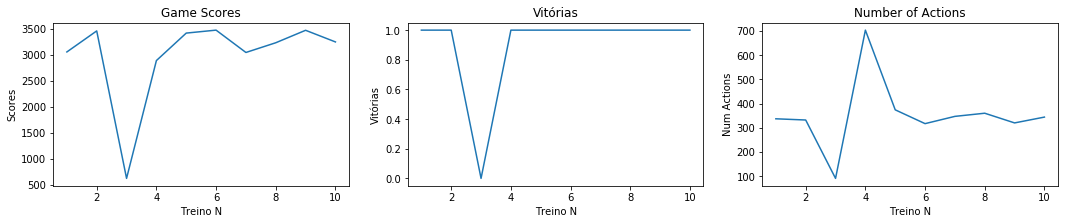

Wins:  9  Loss:  1
Avg Score:  2989.5
Avg NumActions:  352.5


In [12]:
printGraphs(gamesScores,results,numActions)

#### Análise para o resultado do treinamento
&emsp;&emsp;Percebemos através do treinamento que o pacman aprende o equilíbrio entre procurar por comidas e fugir dos fantasmas, e com as features de pílula e fantasmas comíveis, o agente aprende que essas outras interações do jogo são positivas e têm boa recompensa.\
&emsp;&emsp;Alguns desafios foram encontrados no começo do desenvolvimento, observamos que se em um futuro estado havia uma comida e um fantasma, o peso de comer a comida era maior que o de fugir do fantasma, e que o reforço negativo com a morte do agente, na feature *futureScore*, não era suficiente para equilibrar esses pesos. Assim, adicionamos um reforço negativo em *futureScore* caso houvesse um fantasma naquele estado, pois a função *getScore* do GameState não calculava a morte do pacman. Assim, o agente aprendeu que fugir do fantasma era mais importante que comer uma comida.\
&emsp;No entanto, com essa modificação o agente ficou enviesado para fugir dos fantasmas ao invés de buscar as comidas para ganhar o jogo, e o treinamento não era capaz de balancear esses pesos. Então, adicionamos um reforço positivo também em *futureScore*, para que, caso não ohouvesse um fantasma no próximo estado, o agente fosse em busca das comidas disponíveis.

### Teste 
&emsp;&emsp;Teste do modelo final do agente, resultante do treinamento anterior. Realizamos 30 jogos para cada um dos mapas.

In [13]:
layoutType='smallClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  smallClassic
------------------------------------------ train --------------------
Action Score:  [2.9727967590077364, 2.973045944231866]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.913800016611981, 2.969750346323963]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.720236679438206, 2.9699526463898422]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.954597287126309, 0.7198658624801995, 2.9872683352773817]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.903930883973855, 3.011793519812168]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [3.081865475625843, 0.7222307922359639, 2.9872683352773817]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.460254037019687, 2.9549607845

Action Score:  [2.95087918334844, 0.6675846805437076]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6614183484321042, 2.948465990992612]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6577002446542357, 2.95087918334844]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6552870522984077, 2.954597287126309]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-0.061894860348480366, -0.005219394754326943]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.05660303888065889, 0.008515726130142329]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.04851384960476792, 0.03604476195325267]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.10311

Action Score:  [0.5397434215416026, -4.752469088380692, 2.695030765036905]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-4.727943903845906, 2.68367910819509]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-4.752469088380692, 2.6775127760834865]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.6737946723056183, -4.763820745222508]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.6713814799497904, -4.769987077334111]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.6737946723056183, -4.773705181111979]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.6775127760834865, -4.776118373467807]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:

Action Score:  [2.9393576390189535, 0.7139018304344755, 2.9813043032316577]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.8886912358665, 3.005829487766444]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [3.075901443580119, 0.7069911441286088, 2.9813043032316577]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.4298613297146776, 2.9245680772431015]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9628057247871302, 0.8015882844770696, 0.9773431302129354]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9814008125071583, 1.1799768458709137, 2.8927337689734554]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9946400330567764, 2.956875627972372, 2.9813043032316577]
W:  [[2.84163676 1

Action Score:  [3.081865475625843, 0.7222307922359639, 2.9872683352773817]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.460254037019687, 2.9549607845481107]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.081865475625843, 0.8389946934678507, 0.9536020687069847]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.0188072214979393, 1.2173832548616947, 3.011793519812168]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.0291216610976606, 2.9913572560132566, 2.996446044094851]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.9590497052839857, 1.2144584739117983, 3.005829487766444]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9813043032316577, 2.956875627972372, 0.8260169597363552

Action Score:  [0.024771847526714658, 0.08535751252475861, -0.03251603488516338]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.07242583459446382, 0.043561772606477575, -0.029104338950892955]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-0.009141613389469061, 0.2142965487291853, -2.2834928862664325]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.06275355027722465, 0.49287314706997726, 0.1509240285323589]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.20462426441194612, 1.8337656359490007]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6206887717393903, 1.8724608058234162, 0.5320854712031597]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8566849102968745, 0.475399120200

Action Score:  [0.6552870522984077, 2.6775127760834865]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.42391018846185446, -3.3664272903396055]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.015376301924599295, -3.429426357715266]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.1243527486830721, -4.773705181111979]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.1864261973625948, -5.024370358582408]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-5.10884536101669, -0.11446831279360026]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.039025587011714546, -5.145344078827387]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.46

Action Score:  [0.29734082773888204, 2.6268463729310327]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.42762829223972293, 0.678936337385523, 2.911302832275868]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6675846805437076, 2.95087918334844]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.68947315517519, 2.9576550181445427]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.024855055225448855, 0.06803037639209464]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.03642816228658318, 0.1061821898358883]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.05797742361049564, 0.17569184607114796]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score

Action Score:  [0.7301211153276779, 3.005829487766444]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.8015882844770696, 0.7314198193878942, 2.956875627972372]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6428492851296916, 0.7315163286633948, 2.856856927596854]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-1.9108323251778203, 0.07006116344997898]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.23672859094826465, 0.1174618390610771, 0.20085174957166313]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.15872820698368212, 0.2533253473321431, 0.6183241005949056]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.28951879310536627, 2.8000241923327964, 0.3253956344819678]
W:  [[2.8416

Action Score:  [3.0859543963617178, 0.7314198193878942, 2.9913572560132566]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.464342957755562, 2.9590497052839857]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.075901443580119, 0.8360699125179543, 0.9554583656971619]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.015882440548043, 1.2144584739117983, 3.005829487766444]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.0291216610976606, 2.9913572560132566, 2.996446044094851]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.961974486233882, 1.2173832548616947, 3.011793519812168]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9872683352773817, 2.9721152760797276, 0.8319809917820793

Action Score:  [0.7314198193878942, 2.9637863142782392, 2.9393576390189535]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.8886912358665, 0.3139474683646518]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.7314198193878942, 0.7139018304344755, 2.9393576390189535]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9356395352410853, 0.720068162546079]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.844559299351554, 0.68947315517519]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-1.936136086999425, 2.844559299351554, 0.5970880078636184]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.5930203387733007, 2.9356395352410853, 0.5946748155077903]
W:  [[2.84163676 1.2468803  1.78741429 0.5

Action Score:  [1.851129504721195, 0.4617249281720737]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.8543556580369847, 0.45696220315408265]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.8591183830549758, 0.45373604983829297]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.45614924219412106, 1.865284715166579]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [4.718273135211267, 0.4598673459719895]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Pacman emerges victorious! Score: 1174
Average Score: 1174.0
Scores:        1174.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.9727967590077364, 2.973045944231866]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79

Average Score: -110.0
Scores:        -110.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [2.9727967590077364, 2.973045944231866]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.913800016611981, 2.969750346323963]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.716147758702331, 2.960763619237912]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.954597287126309, 0.7198658624801995, 2.9872683352773817]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.903930883973855, 3.011793519812168]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [3.081865475625843, 0.7222307922359639, 2.9872683352773817]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]] 

Action Score:  [0.7414727721694933, 0.1982986231061612]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.3240004211462508, 2.9131199111257855, 0.35987726252285235]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7314198193878942, 0.7139018304344755, 2.9393576390189535]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.846972491707382, 0.6956394872867934]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.5370881553820332, 0.6008061116414869]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.591507698290263, 0.20085174957166313]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.07006116344997898, 0.05254317449656026, -1.9283503141312388]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808

Action Score:  [0.7282522734460195, 2.985094387253036]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7290435712976691, 5.8329940192161285]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Pacman emerges victorious! Score: 1365
Average Score: 1365.0
Scores:        1365.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.9727967590077364, 2.973045944231866]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.913800016611981, 2.969750346323963]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.720236679438206, 2.9699526463898422]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.9637863142782392, 0.7239547832160745, 2.9913572560132566]
W:  [[2.84163676 1.2468803  1.78741429 0.

Action Score:  [2.9660322425460945, 0.7108791353941486]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9636190501902666, 0.7198658624801995]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.95087918334844, 0.716147758702331]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.911302832275868, 0.6985815071488486]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.7009946995046767, 2.9174691643874713]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7047128032825452, 2.9288208212292863]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7108791353941486, 2.9533460057640726]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7129212409433665

Action Score:  [2.994282036963153, 2.9872683352773817, 0.8389946934678507]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9549607845481107, 2.975916678435566, 2.961974486233882]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9721152760797276, 0.7373838514336182]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7108791353941486, 2.9174691643874713, 0.7467559767707501]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.678936337385523, 2.6775127760834865, 2.911302832275868]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.907584728497999, 2.6268463729310327]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.948465990992612, 0.6614183484321042]
W:  [[2.84163676 1.2468803  1.78741429 0

Action Score:  [0.05878228847392644, 0.12627835100521903]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.0799556036497984, 0.2155797381511574]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.12368319896303048, 0.4713350728194479]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.21298458610896887, 1.8180621245498958]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.86872852770235, 0.4675498270436267, 0.49468514415339115]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.10214440343777484, 0.22546417404062924]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.13619489291473677, 0.12981449509672702, 0.48885306177286664]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -

Action Score:  [-0.48891368576013194, 1.0913098023372105, 2.8927337689734554]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.5134388702949182, -0.4756744652105147, 2.868208584438669]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.856856927596854, 0.6069724437530902, -0.5457464210241896]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-1.9108323251778203, -0.5134388702949182]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-1.886307140643034, 2.8927337689734554, -1.9221839820196356]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.7129212409433665, 2.868208584438669, -1.9108323251778203]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.856856927596854, -1.886307140643034]
W:  [[2.84

Action Score:  [2.9872683352773817, 2.9721152760797276, 0.8319809917820793]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.939807725350456, 2.960763619237912, 2.9549607845481107]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9721152760797276, 0.7373838514336182]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7260321945918029, 2.960763619237912, 0.7619090359684044]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7373838514336182, 2.969750346323963, 2.954597287126309]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.903930883973855, 0.31991150041037586]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.7222307922359639, 0.7047128032825452, 2.911302832275868]
W:  [[2.84163676 

Action Score:  [-0.0001468508348764913, -0.0001468508348764913, 0.007115477996120733]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.021326813862874033, 0.012490993625104328]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.043147604015564486, 0.043147604015564486, 0.022268537193775077]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.03647987306052838, 0.021326813862874033, 0.0792179943637091]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.05830066321321883, 0.1454207890687207, 0.05830066321321883]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.09437105356136344, 0.28808131572906687, 0.09437105356136344]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.16057384826637505, 0.145

Action Score:  [2.95087918334844, 0.6675846805437076]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6614183484321042, 2.948465990992612]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7009946995046767, 2.9660322425460945]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7137345663465029, 2.969750346323963]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.716147758702331, 2.960763619237912]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7198658624801995, 5.813752039282599]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Pacman emerges victorious! Score: 1321
Average Score: 1321.0
Scores:        1321.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ trai

Action Score:  [0.6614183484321042, 2.695030765036905]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.043126534273789804, -0.2321050938175782]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.009002262823276375, -0.02791505265256422]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.005914803491868455, -0.015071727530704057]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.010250853011984109, -0.024241910930631605]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.0006415744354899347, -0.005914803491868455]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.008858176853207883, -0.0001979002303851181]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  Nort

Action Score:  [0.7315163286633948, 2.856856927596854]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7069911441286088, 2.8506905954852506]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.846972491707382, 0.6956394872867934]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.844559299351554, 0.68947315517519]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.846972491707382, 0.6857550513973215]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.8506905954852506, 0.6833418590414935]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.6857550513973215, 2.856856927596854]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [5.709845347641542, 0.

Action Score:  [2.961974486233882, 1.2173832548616947, 3.011793519812168]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9872683352773817, 2.9721152760797276, 0.8319809917820793]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9549607845481107, 2.975916678435566, 2.961974486233882]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9721152760797276, 0.7373838514336182]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7108791353941486, 2.9174691643874713, 0.7467559767707501]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7222307922359639, 2.954597287126309, 2.911302832275868]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.903930883973855, 0.31991150041037586]
W:  [[2.84163676 1

Action Score:  [2.9805739600365735, 0.7443975531193897]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.976855856258705, 0.7330458962775743]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7290435712976691, 2.975723564933955]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7282522734460195, 2.978136757289783]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7258390810901914, 2.9789280551414326]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7253254675198006, 2.9800055991714416]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7239547832160745, 2.9813043032316577]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.106013672943761

Action Score:  [0.7129212409433665, -1.9108323251778203, 2.868208584438669]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-1.886307140643034, 2.856856927596854]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-1.9108323251778203, 2.6775127760834865]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-5.192630405992868, -2.319387158202997]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Pacman died! Score: -303
Average Score: -303.0
Scores:        -303.0
Win Rate:      0/1 (0.00)
Record:        Loss
------------------------------------------ train --------------------
Action Score:  [2.9727967590077364, 2.973045944231866]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.913800016611981, 2.969750346323963]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.

Action Score:  [0.3253956344819678, 2.8000241923327964]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6008061116414869, 0.7069911441286088, 2.9393576390189535]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6956394872867934, 2.9600682105003706]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7139018304344755, 2.9636190501902666]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.1061821898358883, 0.06394145565621964]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.17569184607114796, 0.07095515734199109]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.3240004211462508, 0.11127097791748283]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Sco

Action Score:  [0.7373838514336182, 0.7198658624801995, 2.954597287126309]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.907584728497999, 0.7108791353941486]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.6713814799497904, 0.6614183484321042]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.4198425193715368, 2.9051715361421713, 0.6577002446542357]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.4198425193715368, 2.907584728497999, 0.42149699610602637]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.911302832275868, 0.42149699610602637]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.856856927596854, 0.6577002446542357]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.7913687

Action Score:  [-0.24642706442054768, -0.2499236392747883, -0.04851384960476792]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.03477872872029865, -0.03908504992724018]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-0.04851384960476792, -0.043126534273789804, -0.24642706442054768]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-0.03477872872029865, -0.045433041605982924, -0.0021385867555419533]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.043126534273789804, -0.0007818600408292763]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.0021385867555419533, 0.018816934080505526]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.017317231752278877, 0.014371199156825068, 0.0354195966

Action Score:  [3.4018065229715915, 2.939807725350456]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.0234179615777474, 0.816827932584425, 0.9676708458956962]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9533460057640726, 1.195216493978269, 2.996640460614514]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.9721152760797276, 3.009879681164131, 2.9813043032316577]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.996640460614514, 1.195216493978269, 2.948996752502387]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.816827932584425, 2.9721152760797276, 2.9813043032316577]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.9245680772431015, 2.939807725350456, 2.945523971130557]
W:  

Action Score:  [0.7069911441286088, 2.9393576390189535, 2.8506905954852506]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.8886912358665, 0.3139474683646518]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.7069911441286088, 0.68947315517519, 2.8506905954852506]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.846972491707382, 0.6956394872867934]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.844559299351554, 0.68947315517519]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.6816873823070039, 2.844559299351554, 0.6857550513973215]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.6536325755639181, 2.6737946723056183, 0.6552870522984077]
W:  [[2.84163676 1.2468803  1.78741429 0.504

Action Score:  [0.03348166787354118, 0.06421535472656882]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.04938832367987596, 0.09809204992882753]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.07383268288291459, 0.1695050557419635]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.10776433424606671, 0.30102889526906024]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.20797436836734656, 0.20797436836734656, 1.2640713966610522]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.41094121705586895, 4.098629191515032]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.8411587005995488, 0.7414727721694933, 2.996446044094851]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  

W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.26856499543949836, 0.7222307922359639, 0.13067340024059637]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.903930883973855, 0.29734082773888204]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.954597287126309, 0.7047128032825452, 0.678936337385523]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.960763619237912, 0.6675846805437076]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9721152760797276, 0.6614183484321042, 2.9393576390189535]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.960763619237912, 2.8606364291234136, 0.7034615219203091]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action S

Action Score:  [-3.3873831842270614, 2.68367910819509, 2.6627232143076345]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.695030765036905, -4.752469088380692]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-4.763820745222508, 2.68367910819509, 0.4696714657279278]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-4.752469088380692, 2.6775127760834865, 2.6775127760834865]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-3.423260025603663, 0.02767393016989922]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-4.769987077334111, 0.02150759805829583, 0.44514628119314165]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-5.012072730337108, 2.6627232143076345]
W:  [[2.84163676 1.2468803  1.787

Action Score:  [2.9636190501902666, 0.6957435929383948]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.95087918334844, 0.6969270304143591]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.954597287126309, 0.6985815071488486]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.960763619237912, 0.7009946995046767]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.911302832275868, 2.9288208212292863, 0.7047128032825452]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9533460057640726, 2.8606364291234136]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [3.0234179615777474, 2.9721152760797276, 0.7222307922359639]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  Nort

Action Score:  [0.3008704499471816, 0.2833524609937629, 2.7938578602211934]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.846972491707382, 0.6956394872867934]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.5370881553820332, 0.6008061116414869]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.790139756443325, 0.28951879310536627]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.844559299351554, 0.68947315517519]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.6536325755639181, 2.6713814799497904, 0.6577002446542357]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.4198425193715368, -3.376311726229077, 0.42149699610602637]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.791368

Action Score:  [2.9174691643874713, 0.6675846805437076, 2.7195559495716912]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.871988085965229, 2.9288208212292863]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [5.794982768966945, 0.7034615219203091, 0.7108791353941486]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Pacman emerges victorious! Score: 970
Average Score: 970.0
Scores:        970.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.9727967590077364, 2.973045944231866]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.913800016611981, 2.969750346323963]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.720236679438206, 2.9699526463898422]
W:  [[2.84163676 1.2468

Action Score:  [-5.02195716622658, 0.02767393016989922]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-5.105127257238822, 0.44514628119314165]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-5.012072730337108, 2.6627232143076345]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-1.8162351848293592, -4.752469088380692, 2.695030765036905]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-4.727943903845906, 2.68367910819509]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.6775127760834865, -4.752469088380692, 2.6775127760834865]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.4337946243513263, -3.423260025603663]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION: 

Action Score:  [2.9288208212292863, 0.7047128032825452]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.29734082773888204, 0.09682464579183084]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.26856499543949836, 0.678936337385523, 0.17396785509103735]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.8606364291234136, 0.340635282589323]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.911302832275868, 0.7047128032825452, 0.7222307922359639]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9174691643874713, 0.7108791353941486]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9721152760797276, 0.7047128032825452, 2.911302832275868]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79

Action Score:  [-1.886307140643034, 0.6428492851296916, -0.5247905271367335]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.30680054676193946, 0.3008704499471816, 2.811375849174612]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6428492851296916, 0.7315163286633948, 2.856856927596854]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6183241005949056, 0.15872820698368212]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.28951879310536627, 2.8000241923327964, 0.3253956344819678]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7069911441286088, 2.8506905954852506, 0.68947315517519]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6956394872867934, 2.856856927596854]
W:  [[2.841636

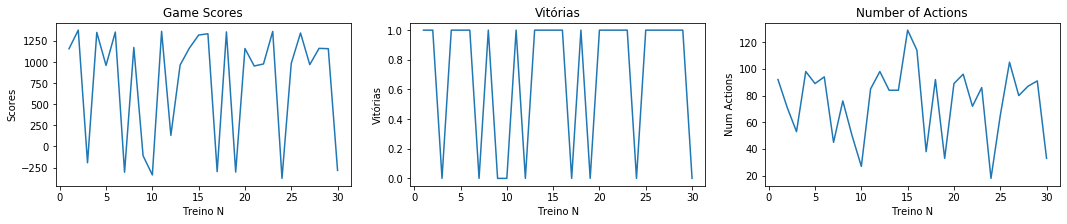

Wins:  21  Loss:  9
Avg Score:  763.2
Avg NumActions:  75.8


In [14]:
printGraphs(gamesScores,results,numActions)

In [ ]:
layoutType='mediumClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
Action Score:  [2.973180367413754, 2.9714308975080375]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9720100408293666, 2.9150094044916006]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.971604749692423, 0.7224759396087412]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.972788187168387, 0.7231419127425075]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.970632751876038, 0.7217202658486594]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9660322425460945, 0.7190937912977848]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9636190501902666, 0.7207482680322744, 2.9767640480097346, 2.970

Action Score:  [2.922095319877376, 2.99937285002107]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [3.0238980345558564, 2.9880211931792546, 0.7352099034092725]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.0939699903695312, 2.9396133088307943]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.4723585517633753, 0.7740135507120928]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.290931756286558, 0.43980111206249417]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.44520789517408504, 1.8440593706521182]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.846477441731428, 0.44666591576921616]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score

Action Score:  [0.020111547868936624, 0.011104596023065808]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.024611720622181345, 0.013252620589428079]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.028545067257544764, 0.015022759787342091]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.025665653322171664, 0.014558767840582354]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.06140427441013725, 0.028545067257544764]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.12719582686752845, 0.05009432858145722]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.2693380698310279, 0.08583294966942281]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Sco

Action Score:  [2.9782923750970767, 2.975621658094792, 0.728407891253313, 1.860491832894163]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.976637898362587, 2.9212021151865626]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.724363724411841, 2.974641499926661]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.10982691658644524, 0.31658855349592435]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7156842214694292, 0.172218251816338]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.3079090505535126, 2.891171936178044]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6931118432003209, 2.860709681328391, 0.6931118432003209, 2.955508020995791]
W:  [[2.84163676 1.2468803  1.78741429 0

Action Score:  [0.1806710262973248, 0.06140427441013725]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.5867917204787518, 0.12719582686752845]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.7798434690584584, 0.2693380698310279]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.925343247856219, 0.675458764012455, 0.5867917204787518, 0.675458764012455]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.8972884411131328, 0.675458764012455]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.8972884411131328, 0.6906984121198103, 2.9405828959635736]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9405828959635736, 2.883750160699517]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.791

Action Score:  [-0.02540011802866529, -0.0352524508050424]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.02732297519295286, -0.03825630209336657]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.028896692882905896, -0.016211090876734956]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.012169915995298519, -0.013827626834081005]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.019707665730975557, -0.010247058831010947]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.01813394804102253, -0.013827626834081005]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.016211090876734956, -0.0352524508050424]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East


Action Score:  [0.6932724839660269, 2.959239552951912]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.6936837262136473, 2.959905526085678]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.694202009910494, 2.9548171039340887]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7100210422419146, 2.956000541410053]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.9576550181445427, 0.7149855728719241]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7161690103478884, 2.9600682105003706]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.717823487082378, 2.9677079709261416, 2.9576550181445427, 2.973839267059838]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  Wes

Action Score:  [2.9665595688738384, 0.712865173003236]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9665595688738384, 0.712865173003236]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9627496568469995, 0.712865173003236]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.955735955161228, 0.712865173003236]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.883750160699517, 0.29973077713603746]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.8972884411131328, 0.6906984121198103, 0.6906984121198103, 0.6906984121198103]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.007493206895560878, 0.24128326308794218]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  

Action Score:  [1.844288802423269, 0.4468953475403671, 1.846365287096887]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.7894152885598351, 1.8497312957350636]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.8498908932952425, 1.846365287096887, 0.4489718322139849, 1.8498908932952425]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.8526746280712625, 1.7910422634808287]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.45064114142216316, 1.8528996645210534]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.8526746280712625, 0.4552811731883605, 1.862788521506177]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.7998521750328171, 1.8727925750835952]
W:  [[2.84163676 1.2468803  1.7874142

Action Score:  [2.9674323119763786, 0.7201922793272527]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.962276192490691, 0.7175478281326149]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.948496583132224, 0.7113470874068051]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.95294803216459, 0.7137651584861148]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.29973077713603746, 2.883750160699517]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6998874392717406, 2.925343247856219, 0.675458764012455, 0.6998874392717406]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.675458764012455, 2.8366762043225155]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  Sou

Action Score:  [2.949771923115504, 0.675458764012455, 0.6998874392717406, 2.949771923115504]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.2937667450903135, 2.8685105125921613]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.675458764012455, 0.5867917204787518, 0.675458764012455, 5.766980011059092]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Pacman emerges victorious! Score: 1936
Average Score: 1936.0
Scores:        1936.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.973180367413754, 2.9714308975080375]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9720100408293666, 2.9150094044916006]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.969958844797282, 0.

Action Score:  [2.789627905385366, -3.4119083687618477]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [3.1680164667792106, -4.727943903845906]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.4840912803734345, -4.906123933146832]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.5857386921296752, 1.9264936119922247]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.9264936119922247, 1.2325390165448984]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8880242993668417, 0.6390124788961314]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8880242993668417, 0.6390124788961314]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.529100157109

Action Score:  [-0.047458571391935704, -0.021011924448232088]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [-0.04653358119897093, -0.019707665730975557]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.042562623300308085, -0.021011924448232088]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.022104905939685372, -0.04413634099026112]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.02302989613265015, -0.04544059970751765]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.022104905939685372, -0.022104905939685372]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.021011924448232088, -0.012976943351051156]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION

Action Score:  [2.9699526463898422, 2.8788067999770277]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9813043032316577, 2.9637863142782392, 0.68947315517519]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.9131199111257855, 3.015882440548043]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7414727721694933, 3.091043184443312]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [3.4723585517633753, 0.7710867447858739]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.2897662954543567, 0.43796481234434054]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8429568483076266, 0.44556339342472456]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:

Action Score:  [0.7139779875475489, 2.970409280068038]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7197118352643129, 1.8451039918922407]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7197118352643129, 1.8451039918922407]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7205247962242746, 2.9677385630657533]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.71543600814268, 2.9576856102841544]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7064276766012036, 2.935113232015046]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.846446188481343, 2.935113232015046, 0.6852287481712824, 2.941493629833056]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
A

Action Score:  [-0.004219220146187235, -0.05944743276871789]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.020522799886306363, -0.01107814742569578]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.03450909930326877, 0.010933839051467109]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.04090530142952689, 0.020522799886306363]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.0333494676670515, 0.01935604010561443]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.1346490360679386, -0.0023891534209140863]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.20044058852532975, -0.023938414744826553]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action S

Action Score:  [2.89306704879574, 2.889640346917263]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.862788521506177, 0.46539506662327507, 1.862788521506177, 1.834176878196621]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.8566849102968745, 1.8159598398195378]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.4750673509405142, 1.8569564391256526]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.4651235377944971, 1.8535029626100104]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.46539506662327507, 1.8539142048576307]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.4598947535029296, 1.8518373365122889]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  W

Action Score:  [2.9627496568469995, 0.7058514713174646]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.955735955161228, 0.7058514713174646]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.29973077713603746, 0.09881068340091825]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.16460223585830946, 0.16460223585830946, 0.7058514713174646]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.898903219897171, 0.30674447882180894]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.712865173003236, 2.955735955161228, 0.7058514713174646, 0.712865173003236]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.712865173003236, 2.955735955161228]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79

Action Score:  [0.7058514713174646, 0.6906984121198103, 5.797372718364101]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Pacman emerges victorious! Score: 1930
Average Score: 1930.0
Scores:        1930.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.973180367413754, 2.9714308975080375]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9720100408293666, 2.9150094044916006]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.971604749692423, 0.7224759396087412]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9689782751415486, 0.720844655954525]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9677079709261416, 0.7200743609535187]
W:  [[2.84163676 1.2468803  1.78741429 0

Action Score:  [0.7176032519811507, 2.9633284736877865]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7180144942287712, 2.963994446821553]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.9548171039340887, 2.9633284736877865, 0.7134439898440234, 2.9648700567156876]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.897108758775897, 2.9660534941916517]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.969958844797282, 0.7149855728719241, 2.9727967590077364]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.9752099513635644, 2.9143095470091893]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [2.9789280551414326, 0.7258390810901914]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.791368

Action Score:  [2.9059169215829423, 0.30674447882180894]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.7058514713174646, 0.712865173003236, 2.9627496568469995]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9665595688738384, 0.712865173003236]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9120240903977637, 0.3105543908486477]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.7166750850300748, 2.9688568256618213, 0.7189723418180574, 0.7166750850300748]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7166750850300748, 2.9688568256618213]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.16841214788514824, 0.06688197433979148]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.

Action Score:  [2.970935909767062, 0.7174368894655121]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9627588647492744, 0.7155166583312551]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9462482518600446, 0.7133926646023576]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.902269043757527, 0.6972009205108252]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.6682074587363678, 0.6534952234127638]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.668831971557043, 0.6527375439056609]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.24634532089545574, 2.61327731699712]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6531634541525848, 

Action Score:  [2.96213705931652, 2.910905827801696]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.7178540792219898, 0.16398963832782998]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.20268829872410235, 1.7882712566281833]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.44908398684852596, 1.8440593706521182, 1.846477441731428, 0.44666591576921616]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.2052834507662909, 1.7896447064673704]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.4509402838387032, 1.8451039918922407, 0.4509402838387032, 0.44771053700933877]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.4509402838387032, 1.8451039918922407]
W:  [[2.84163676 1.2468803  1.7

Action Score:  [0.12719582686752845, 0.03852878333382531, 0.5867917204787518]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.2693380698310279, 2.7798434690584584]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.675458764012455, 2.8366762043225155, 0.675458764012455, 0.675458764012455]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.675458764012455, 5.678312967525388]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Pacman emerges victorious! Score: 1915
Average Score: 1915.0
Scores:        1915.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.973180367413754, 2.9714308975080375]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9720100408293666, 2.9150094044916006

Action Score:  [0.6998874392717406, 2.925343247856219]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6998874392717406, 2.925343247856219]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.949771923115504, 2.925343247856219, 0.6998874392717406]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.892939187851447, 2.959824875897103]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7099403920533396, 2.964913663978698]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.7150291801349341, 2.9678404699049166]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.717955986061153, 2.96967676962307]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [2.969

Action Score:  [0.038598020039143754, 0.020111547868936624]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.024611720622181345, 0.05009432858145722, 0.024611720622181345]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.038598020039143754, 0.08583294966942281, 0.038598020039143754]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.151624502126814, 0.060147281363056214]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.2937667450903135, 0.0958859024510218]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.161677454908413, 0.6998874392717406, 0.7099403920533396, 0.161677454908413]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9080809287146403, 0.3038196978719125]
W:  [[2.84163676 1.2468

Action Score:  [1.878101598266417, 1.878101598266417, 0.5369832521383611, 1.8842328944001137]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.8236820553581876, 1.8748948598139532]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [1.8824612708799473, 0.47716715519997244, 1.8649432819265288]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.9025350063823678, 1.8142768787740744]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.4824726639548569, 1.9712335123568554]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.5037681016602785, 2.347764491550615]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.32454345111923, 2.290286696651388]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.7913687

Action Score:  [0.1806710262973248, -0.6018039856751294]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-1.9423647052939739, 0.03852878333382531]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.0333494676670515, -0.20044058852532975, 0.1806710262973248]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [0.5867917204787518, -0.1346490360679386]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.007493206895560878, 2.7798434690584584]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.413613901076988, 2.8972884411131328, 0.6474039572693693, 0.5867917204787518]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.413613901076988, 2.8972884411131328]
W:  [[2.84163676 1.2468803  1.78741429 0.50451

Action Score:  [2.96967676962307, 0.717955986061153]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.970903995139108, 0.7197922857793067]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.9717644977949167, 0.7210195112953439]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7218800139511528, 2.972391066874102]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7225065830303383, 5.8140278300769745]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Pacman emerges victorious! Score: 1722
Average Score: 1722.0
Scores:        1722.0
Win Rate:      1/1 (1.00)
Record:        Win
------------------------------------------ train --------------------
Action Score:  [2.973180367413754, 2.9714308975080375]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.7913687

Action Score:  [1.8605462189201394, 1.8509288907637937, 0.45353543588089174]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.8133857679733212, 1.7978814012755575]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.854714136539615, 0.45732068165671297, 0.47282504835447664, 0.45732068165671297]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [1.8509288907637937, 0.4631527640372375]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [0.45353543588089174, 1.8509288907637937]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8509288907637937, 0.44908398684852596]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.854714136539615, 0.4509402838387032]
W:  [[2.84163676 1.2468803  1.78741429 0.5045180

Action Score:  [0.7099403920533396, 2.964913663978698]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7150291801349341, 2.964913663978698]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.717955986061153, 2.964913663978698]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.717955986061153, 2.964913663978698]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [-0.007888155269456625, -0.006430721519596587]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  West
Action Score:  [-0.0039147912519965035, -0.005751090970150118]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  [-0.0018978241090467293, -0.004594421801442972]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Score:  

Action Score:  [2.9829303801213376, 2.9091995072820374]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.994282036963153, 2.9767640480097346, 0.7198658624801995]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [2.926097644857281, 3.0226171335247782]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.7482074651462285, 3.0949863461264355]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [3.4741948514815286, 0.7740135507120928]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [2.2897662954543567, 0.43796481234434054]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8434772495046579, 0.44608379462175596]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  North
Action Scor

Action Score:  [0.4631527640372375, 1.854714136539615]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.45353543588089174, 1.8509288907637937, 1.8605462189201394]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8880242993668417, 1.803713483656082]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [1.8696608767281673, 0.47282504835447664]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  East
Action Score:  [0.5291001571093227, 1.9264936119922247, 1.2325390165448984, 0.5291001571093227]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.6390124788961314, 1.8880242993668417]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0.79136872]]   -  ACTION:  South
Action Score:  [0.15549066457922855, 0.21490077892263665]
W:  [[2.84163676 1.2468803  1.78741429 0.50451808 0

In [ ]:
printGraphs(gamesScores,results,numActions)

In [ ]:
layoutType='originalClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

In [ ]:
printGraphs(gamesScores,results,numActions)

#### Análise dos resultados dos testes
&emsp;&emsp;Percebemos que as considerações do passo de treinamento quanto às features e aos reforços foram bem sucedidos, como podemos ver no desempenho do modelo nos casos de teste. \
&emsp;&emsp;Fomos capazes de resolver alguns desafios do jogo, mas não todos. Percebemos que quase todas as vezes que o pacman morre, é por que ele foi encurralado por dois fantasmas, um cenário que não é previsto no nosso modelo.\
&emsp;&emsp;Como consideração final, esta seria uma melhoria a ser implementada.